# Week 4 - Counting Words & Phrases

This week, we take text corpora that we have developed, spidered, scraped, and encoded, and we find and count words, simple and parsed phrases and explore the statistical properties of those counts (e.g., word frequency distributions). Initially, we model how to search corpora for keywords or phrases. Next, we examine the distributions of terms and phrases across a corpus, and the correlation between different words and phrase counts. In order to do this effectively, we coarsely disambiguate words based of part-of-speech (POS) tagging, and normalize them through stemming and lemmatization. Next we distinguish *important* words and phrase within the corpus, and image them with Wordls! Then we calculate word frequenceis, conditional frequences (the frequency of word *shock* conditional on the presence of word *awe*), and statistically significant collocations of lengths 2 through $n$. Finally, we calculate and visualize Differences (Divergences and Distances) between the word frequency distributions from two corpora. 

Then we shift to focus not simply on the *ideas* in a corpus, but also extracting precise *claims*. This process involves a sequential pipeline of classifying and structuring tokens from text, each of which generates potentially useful data for the content analyst. Steps in this process, which we examine in this notebook, include: 1) tagging words by their part of speech (POS) to reveal the linguistic role they play in the sentence (e.g., Verb, Noun, Adjective, etc.); 2) tagging words as named entities (NER) such as places or organizations; 3) structuring or "parsing" sentences into nested phrases that are local to, describe or depend on one another; and 4) extracting informational claims from those phrases.

We will be introducing spaCy as a package for Computational Linguistics, and also walk you through how to use the Davies Corpora. 

While we wish to avoid using NLTK for heavy corpus analysis, some of its smaller functions can still be useful.

Of course, for final projects that draw on these tools, we encourage you to install the software on your own machines or shared servers at the university (RCC, SSRC) in order to perform these operations on much more text. 

For this notebook we will be using the following packages

In [1]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
import lucem_illud_2020 #pip install git+git://github.com/Computational-Content-Analysis-2020/lucem_illud_2020.git

#All these packages need to be installed from pip
import requests #for http requests
import pandas #gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import wordcloud #Makes word clouds
import numpy as np #For divergences/distances
import scipy #For divergences/distances
import seaborn as sns #makes our plots look nicer
import sklearn.manifold #For a manifold plot
import json #For API responses
import urllib.parse #For joining urls

# comp-linguistics
import spacy

#Displays the graphs
import graphviz #You also need to install the command line graphviz

#These are from the standard library
import os.path
import zipfile
import subprocess
import io
import tempfile

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook
%matplotlib inline

# Retrieving exemplary corpora

To get started we will need some examples. Let's start by downloading one of the corpuses from the Davies set purchased for this class and developed by a computational linguist at Brigham Young University. We can get a list of works available from the [corpora here](https://www.english-corpora.org/).

In this notebook, I will be accessing the data locally - you also have access to this data through the Dropbox download link. The same code can be modified slighlty to access the rest of the corpora on RCC. 
There is a notebook describing this process in the same repository, as well as in the same directory on RCC.

In [2]:
filepath = "/Users/rachelker/Documents/UChic MSCAPP/Curriculum/2019-20 Winter/Computational Content Analysis/Project/Data/"
corpus_name = filepath + "Davies Corpora/Movies"

This method extracts the text from the zip files and stroes the raw data.

In [3]:
def loadcorpus(corpus_name, corpus_style="text"):
    texts_raw = {}
    for file in os.listdir(corpus_name + "/"):
        if corpus_style in file:
            print(file)
            zfile = zipfile.ZipFile(corpus_name + "/" + file)
            for file in zfile.namelist():
                texts_raw[file] = []
                with zfile.open(file) as f:
                    for line in f:
                        texts_raw[file].append(line)
    return texts_raw

In [4]:
movie_raw = loadcorpus(corpus_name)

text_13_idi.zip
text_16_qll.zip
text_32_ldf.zip
text_19_gvc.zip
text_05_nko.zip
text_17_arp.zip
text_01_ote.zip
text_28_rfy.zip
text_31_akv.zip
text_22_etp.zip
text_11_uoy.zip
text_09_oii.zip
text_06_jfy.zip
text_14_lnc.zip
text_08_loh.zip
text_33_kje.zip
text_30_wkp.zip
text_07_oma.zip
text_03_mnq.zip
text_21_fqa.zip
text_29_oye.zip
text_27_fle.zip
text_23_fmh.zip
text_12_rcq.zip
text_00_myn.zip
text_10_aoy.zip
text_04_mlq.zip
text_20_cde.zip
text_02_mqu.zip
text_26_ngj.zip
text_24_ywo.zip
text_18_jfj.zip
text_25_byg.zip
text_15_guo.zip


In [5]:
list(movie_raw.keys())[:5]

['13.txt', '16.txt', '32.txt', '19.txt', '05.txt']

In [6]:
movie_raw['11.txt'][0:3]

[b'\r\n',
 b'@@216680 Hey , I \'m talking to you Give me 600 dollars You wish ! That \'s all we \'ve left And you still go to gamble Shut up I earn the money Even that you ca n\'t take it for gamble Shut up What \'re you doing ? Bastard , I \'m gon na beat you You gambling pig , I \'ll beat the shit out of you You bitch I \'ll beat you You dare to hit me with something ! I \'ll kill you All you know is gambling I \'ll beat you What \'re you doing ? Let go of me Stop You \'ll kill Mom Mom , are you all right ? Do n\'t touch my money Dad , where \'re you going ? Go away Dad , do n\'t go Get lost Dad , come back You take Marble with you The way she \'s now Do you want to give me trouble ? I \'m in more trouble than you I am a woman I \'m a sailor You take care of Marble Just gamble a bit less is enough to raise the kid No way Raising her would be like raising others @ @ @ @ @ @ @ @ @ @ take care of her Marry her when she grows up And you tell her to be smart Do n\'t marry a gambler Hey , 

It seems messy, but nothing we can't clean. This basic method replaces some of the issues with the formatting, and prints the errors if any for debugging. Let us clean one of the raw text files.

We ignore the non-unicode data for convenience for now.

In [7]:
def clean_raw_text(raw_texts):
    clean_texts = []
    for text in raw_texts:
        try:
            text = text.decode("utf-8")
            clean_text = text.replace(" \'m", "'m").replace(" \'ll", "'ll").replace(" \'re", "'re").replace(" \'s", "'s").replace(" \'re", "'re").replace(" n\'t", "n't").replace(" \'ve", "'ve").replace(" /'d", "'d")
            clean_texts.append(clean_text)
        except AttributeError:
            # print("ERROR CLEANING")
            # print(text)
            continue
        except UnicodeDecodeError:
            # print("Unicode Error, Skip")
            continue
    return clean_texts

In [8]:
clean_11 = clean_raw_text(movie_raw['11.txt'])

In [9]:
clean_11[1]

'@@216680 Hey , I\'m talking to you Give me 600 dollars You wish ! That\'s all we\'ve left And you still go to gamble Shut up I earn the money Even that you can\'t take it for gamble Shut up What\'re you doing ? Bastard , I\'m gon na beat you You gambling pig , I\'ll beat the shit out of you You bitch I\'ll beat you You dare to hit me with something ! I\'ll kill you All you know is gambling I\'ll beat you What\'re you doing ? Let go of me Stop You\'ll kill Mom Mom , are you all right ? Don\'t touch my money Dad , where\'re you going ? Go away Dad , don\'t go Get lost Dad , come back You take Marble with you The way she\'s now Do you want to give me trouble ? I\'m in more trouble than you I am a woman I\'m a sailor You take care of Marble Just gamble a bit less is enough to raise the kid No way Raising her would be like raising others @ @ @ @ @ @ @ @ @ @ take care of her Marry her when she grows up And you tell her to be smart Don\'t marry a gambler Hey , you want a quarrel ? No , never

This method cleaned a few basic formatting errors. You are welcome to experiment and add your own code to clean the text. Once it begins to look the way you want to, we can start using spaCy to do some heavier cleaning. spaCy does this through the use of language models. Make sure you have the spacy english language model loaded. 

In [10]:
nlp = spacy.load("en")

This model is going to be the basis of most of the tasks which NLTK would have done otherwise. While NLTK uses a bunch of clunky models from multiple places, spacy neatly packs all functionality in one model. This deep trained model will start by doing our word tokenizing and normalising. These methods are already included in lucem illud, and here we will just demonstrate them outside the package so to explain what goes on under the hood.

When we run text through a spacy model, it performs a lot of computation on each of the tokens. Each token is given certain attributes, such as a part of speech, information whether it is a number, a stop word, and so on. 

To perform a tokenization, we check if it is a punctuation or not and add this token. 

In [11]:
def word_tokenize(word_list):
    tokenized = []
    # pass word list through language model.
    doc = nlp(word_list)
    for token in doc:
        if not token.is_punct and len(token.text.strip()) > 0:
            tokenized.append(token.text)
    return tokenized

In [12]:
word_tokenize(clean_11[1])

['@@216680',
 'Hey',
 'I',
 "'m",
 'talking',
 'to',
 'you',
 'Give',
 'me',
 '600',
 'dollars',
 'You',
 'wish',
 'That',
 "'s",
 'all',
 'we',
 "'ve",
 'left',
 'And',
 'you',
 'still',
 'go',
 'to',
 'gamble',
 'Shut',
 'up',
 'I',
 'earn',
 'the',
 'money',
 'Even',
 'that',
 'you',
 'ca',
 "n't",
 'take',
 'it',
 'for',
 'gamble',
 'Shut',
 'up',
 'What',
 "'re",
 'you',
 'doing',
 'Bastard',
 'I',
 "'m",
 'gon',
 'na',
 'beat',
 'you',
 'You',
 'gambling',
 'pig',
 'I',
 "'ll",
 'beat',
 'the',
 'shit',
 'out',
 'of',
 'you',
 'You',
 'bitch',
 'I',
 "'ll",
 'beat',
 'you',
 'You',
 'dare',
 'to',
 'hit',
 'me',
 'with',
 'something',
 'I',
 "'ll",
 'kill',
 'you',
 'All',
 'you',
 'know',
 'is',
 'gambling',
 'I',
 "'ll",
 'beat',
 'you',
 'What',
 "'re",
 'you',
 'doing',
 'Let',
 'go',
 'of',
 'me',
 'Stop',
 'You',
 "'ll",
 'kill',
 'Mom',
 'Mom',
 'are',
 'you',
 'all',
 'right',
 'Do',
 "n't",
 'touch',
 'my',
 'money',
 'Dad',
 'where',
 "'re",
 'you',
 'going',
 'Go',
 'a

You can see how the sentence is broken into its constituent words. We can then do some analysis with this. 

Note: we still don't know which movie this is, just that it is raw movie text data. Maybe in the process of our text cleaning and counting we will come across something!

# Counting words

If we want to do some analysis we can start by simply counting the number of times each word occurs within the corpus.

In [13]:
def wordCounter(wordLst):
    wordCounts = {}
    for word in wordLst:
        #We usually need to normalize the case
        wLower = word.lower()
        if wLower in wordCounts:
            wordCounts[wLower] += 1
        else:
            wordCounts[wLower] = 1
    #convert to DataFrame
    countsForFrame = {'word' : [], 'count' : []}
    for w, c in wordCounts.items():
        countsForFrame['word'].append(w)
        countsForFrame['count'].append(c)
    return pandas.DataFrame(countsForFrame)

In [14]:
countedWords = wordCounter(word_tokenize(clean_11[1]))
countedWords[:10]

word  count
0  @@216680      1
1       hey     16
2         i    191
3        'm     24
4   talking      2
5        to    112
6       you    302
7      give     14
8        me     82
9       600      1

Lets sort and plot our counts to investigate the shape of our word frequency distribution.

First we need to sort the words by count.

In [15]:
#Doing this in place (changing the original DataFrame) as we don't need the unsorted DataFrame
countedWords.sort_values('count', ascending=False, inplace=True)
countedWords[:100]

word  count
6        you    302
2          i    191
13        's    126
5         to    112
31        it    109
25       the    106
29       n't    106
59        do     93
80         a     85
8         me     82
33      what     64
53        is     61
20        go     56
112     have     52
32       for     51
136     your     50
42       'll     48
12      that     48
57       are     41
18       and     41
212       he     41
61        my     40
94        be     40
45        of     39
68      come     38
54       let     37
34       're     37
72       she     31
90        no     31
182       if     29
..       ...    ...
305    there     14
111     will     14
154  husband     14
28        ca     14
69      back     13
77      more     13
167       oh     12
453       'd     12
95      like     12
440      man     12
55      stop     12
65      away     12
44       out     11
367     girl     11
134      can     11
62       dad     11
74      want     11
35     doing     11
104    never     10
317      who     10
93     would     10
325    night     10
302     over     10
149    think     10
51      kill     10
248  postman     10
187   please      9
328      but      9
215       as      9
135      say      9

[100 rows x 2 columns]

Punctuation and very common words (articles 'a' and 'the'; prepositions 'of' and 'to') make up the most common values, but this isn't very interesting and can actually get in the way of our analysis. We may remove these 'function words' by removing according to a stopword list, setting some frequency threshold, or using a weighting scheme (like tf.idf) to decrease their influence - we will look at these methods in more detail as we go through this tutorial. 

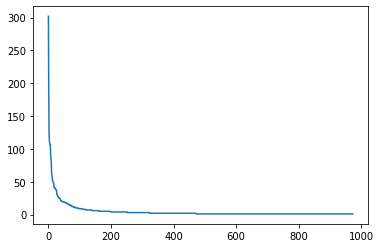

In [16]:
#Creating a figure and axis lets us do things like change the scaling or add a title
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(range(len(countedWords)), countedWords['count'])
plt.show()

This shows that likelihood of a word occurring is inversely proportional to its rank. This effect is called [Zipf's Law](https://en.wikipedia.org/wiki/Zipf%27s_law), and suggests that the most frequent word will occur approximately twice as often as the second most frequent word, three times as often as the third most frequent word, etc. Zipf's law is most easily observed by plotting the data on a log-log graph, with the axes being log (rank order) and log (frequency) resulting in a linear relationship.

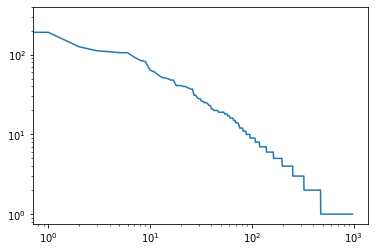

In [17]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(range(len(countedWords)), countedWords['count'])
ax.set_yscale('log')
ax.set_xscale('log')
plt.show()

(The same relationship occurs in many other rankings, such as population ranks of cities, corporation sizes, income rankings, etc.) 

The distribution was imagined by Zipf to be driven by a principle of 'least effort' where speakers did not work any harder than necessary to communicate a given idea, but the basis for this relationship is still not well understood and conforms at least as well to a process of [preferential attachment](https://en.wikipedia.org/wiki/Preferential_attachment) whereby people disproportionately attend to popular words.


# Getting and working with raw text

First, we will retrieve a collection of press releases from a *GitHub API* that archived them, based on a number of analyses by Justin Grimmer, a political scientist whose work we will read in two weeks!

GitHub API requests are made to `'https://api.github.com/'` and responses are in JSON, similar to Tumblr's API.

We will get the information on [github.com/lintool/GrimmerSenatePressReleases](https://github.com/lintool/GrimmerSenatePressReleases) as it contains a nice set documents.

In [18]:
r = requests.get('https://api.github.com/repos/lintool/GrimmerSenatePressReleases')
senateReleasesData = json.loads(r.text)
print(senateReleasesData.keys())
print()
print(senateReleasesData['description'])

dict_keys(['id', 'node_id', 'name', 'full_name', 'private', 'owner', 'html_url', 'description', 'fork', 'url', 'forks_url', 'keys_url', 'collaborators_url', 'teams_url', 'hooks_url', 'issue_events_url', 'events_url', 'assignees_url', 'branches_url', 'tags_url', 'blobs_url', 'git_tags_url', 'git_refs_url', 'trees_url', 'statuses_url', 'languages_url', 'stargazers_url', 'contributors_url', 'subscribers_url', 'subscription_url', 'commits_url', 'git_commits_url', 'comments_url', 'issue_comment_url', 'contents_url', 'compare_url', 'merges_url', 'archive_url', 'downloads_url', 'issues_url', 'pulls_url', 'milestones_url', 'notifications_url', 'labels_url', 'releases_url', 'deployments_url', 'created_at', 'updated_at', 'pushed_at', 'git_url', 'ssh_url', 'clone_url', 'svn_url', 'homepage', 'size', 'stargazers_count', 'watchers_count', 'language', 'has_issues', 'has_projects', 'has_downloads', 'has_wiki', 'has_pages', 'forks_count', 'mirror_url', 'archived', 'disabled', 'open_issues_count', 'lic

What we are interested in here is the `'contents_url'`

In [19]:
print(senateReleasesData['contents_url'])

https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/{+path}


We can use this to get any or all of the files from the repo.

In [20]:
r = requests.get('https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Whitehouse')
whitehouseLinks = json.loads(r.text)
whitehouseLinks[0]

{'name': '10Apr2007Whitehouse123.txt',
 'path': 'raw/Whitehouse/10Apr2007Whitehouse123.txt',
 'sha': 'f524289ee563dca58690c8d36c23dce5dbd9962a',
 'size': 2206,
 'url': 'https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Whitehouse/10Apr2007Whitehouse123.txt?ref=master',
 'html_url': 'https://github.com/lintool/GrimmerSenatePressReleases/blob/master/raw/Whitehouse/10Apr2007Whitehouse123.txt',
 'git_url': 'https://api.github.com/repos/lintool/GrimmerSenatePressReleases/git/blobs/f524289ee563dca58690c8d36c23dce5dbd9962a',
 'download_url': 'https://raw.githubusercontent.com/lintool/GrimmerSenatePressReleases/master/raw/Whitehouse/10Apr2007Whitehouse123.txt',
 'type': 'file',
 '_links': {'self': 'https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Whitehouse/10Apr2007Whitehouse123.txt?ref=master',
  'git': 'https://api.github.com/repos/lintool/GrimmerSenatePressReleases/git/blobs/f524289ee563dca58690c8d36c23dce5dbd9962a',
  'html': 'https:/

Now we have a list of information about Whitehouse press releases. Let's look at one of them.

In [21]:
r = requests.get(whitehouseLinks[0]['download_url'])
whitehouseRelease = r.text
print(whitehouseRelease[:1000])
len(whitehouseRelease)

SEN. WHITEHOUSE SHARES WESTERLY GIRL'S STORY IN PUSH FOR STEM CELL RESEARCH
  Sharing the story of Lila Barber, a 12 year old girl from Westerly, Sen. Sheldon Whitehouse (D-R.I.) on Tuesday, April 10, 2007, illustrated the hope stem cell research can offer in a speech on the Senate floor in favor of legislation to expand federal funding for stem cell research.  
   Whitehouse met Lila two weeks ago. She was diagnosed two years ago with osteosarcoma, a cancerous bone condition, and last year underwent cadaver bone transplant surgery. The procedure saved her leg and is helping her remain cancer-free, but the transplanted tissue will not grow with her and likely will break down over time. Stem cell research, Whitehouse explained, could vastly improve the care of patients like Lila by allowing surgeons to enhance transplants with a patient's own stem cells, which could replace the lost bone and cartilage, or grow entirely new replacement bones and joints. 
   "Stem cell research gives hope

2206

Now we have a string of correctly encoded text. For analysis of its words, next we need to tokenize it, or split it into a sequence of tokens or word instances.

In [22]:
whTokens = word_tokenize(whitehouseRelease)
whTokens[10:30]

['STEM',
 'CELL',
 'RESEARCH',
 'Sharing',
 'the',
 'story',
 'of',
 'Lila',
 'Barber',
 'a',
 '12',
 'year',
 'old',
 'girl',
 'from',
 'Westerly',
 'Sen.',
 'Sheldon',
 'Whitehouse',
 'D']

Previous iterations of the course used `nltk`s tokenizer, but as we saw before, we used spaCy's model (https://spacy.io/api/tokenizer). We intend to avoid using NLTK when we can - for production level code, it is a lot faster and cleaner to use spaCy.

That being said, `nltk` does have some useful methods for quick analysis of small corpuses. We will explore a few here, and encourage you to figure out for yourself which other ones might be useful.

To use the list of tokens in `nltk`, and take advantage of functions like `concordance`, shown above, we can convert it into a `Text`.

In [23]:
import nltk

In [24]:
whText = nltk.Text(whTokens)

whitehouseIndex = nltk.text.ConcordanceIndex(whText) 
whitehouseIndex.print_concordance('Whitehouse')

Displaying 5 of 5 matches:
ld girl from Westerly Sen. Sheldon Whitehouse D R.I. on Tuesday April 10 2007 il
ral funding for stem cell research Whitehouse met Lila two weeks ago She was dia
 down over time Stem cell research Whitehouse explained could vastly improve the
s research might help or even cure Whitehouse said Whitehouse also praised the e
 help or even cure Whitehouse said Whitehouse also praised the efforts of Rhode 


In [25]:
whText

<Text: SEN WHITEHOUSE SHARES WESTERLY GIRL 'S STORY IN...>

*Note* that the `Text` class is for doing rapid, exploratory analysis. It provides an easy interface to many of the operations we want to do, but it does not allow us much control over the particular operations it glosses. When you are doing a more complete analysis, you should be using the module specifically designed for that task instead of the shortcut method `Text` provides, e.g. use  [`collocations` Module](http://www.nltk.org/api/nltk.html#module-nltk.collocations) instead of `.collocations()`.

Now that we have gotten this loaded, let's glance at few features we will delve into more deeply later.

For example, we can find words that statistically tend to occur together and typically have a composite, idiomatic meaning irreducible to the semantics of its component words. We will do this later with more control over exactly how these are identified.

Or we can pick a word (or words) and find what words tend to occur around it.

In [26]:
whText.common_contexts(['stem'])

for_cell hope_cell time_cell own_cells joints_cell of_cell on_cells
the_cell embryonic_cells


We can also just count the number of times the word occurs.

In [27]:
whText.count('cell')

5


We can also plot each time a set of words occurs.

/usr/local/Cellar/python/3.7.6_1/Frameworks/Python.framework/Versions/3.7/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
/usr/local/Cellar/python/3.7.6_1/Frameworks/Python.framework/Versions/3.7/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/usr/local/Cellar/python/3.7.6_1/Frameworks/Python.framework/Versions/3.7/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/usr/local/Cellar/python/3.7.6_1/Frameworks/Python.framework/Versions/3.7/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 


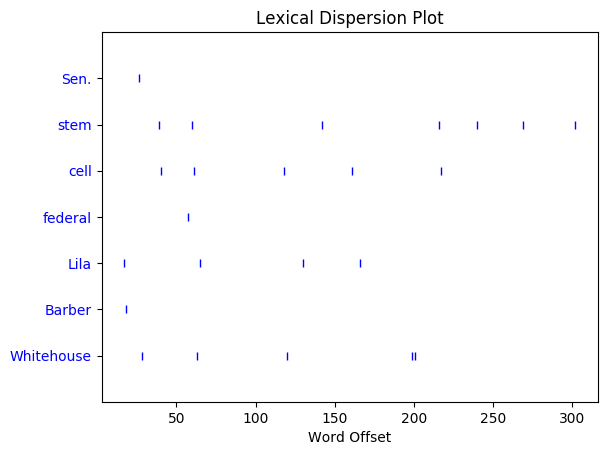

In [28]:
sns.reset_orig() #Seaborn messes with this plot, disabling it
whText.dispersion_plot(['Sen.','stem', 'cell', 'federal' ,'Lila', 'Barber', 'Whitehouse'])
sns.set() #Re-enabling seaborn

If we want to do an analysis of all the Whitehouse press releases we will first need to obtain them. By looking at the API we can see the the URL we want is [https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Whitehouse](https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Whitehouse), so we can create a function to scrape the individual files.

If you want to know more about downloading from APIs, refer back to the 1st notebook.

In [29]:
def getGithubFiles(target, maxFiles = 100):
    #We are setting a max so our examples don't take too long to run
    #For converting to a DataFrame
    releasesDict = {
        'name' : [], #The name of the file
        'text' : [], #The text of the file, watch out for binary files
        'path' : [], #The path in the git repo to the file
        'html_url' : [], #The url to see the file on Github
        'download_url' : [], #The url to download the file
    }

    #Get the directory information from Github
    r = requests.get(target)
    filesLst = json.loads(r.text)

    for fileDict in filesLst[:maxFiles]:
        #These are provided by the directory
        releasesDict['name'].append(fileDict['name'])
        releasesDict['path'].append(fileDict['path'])
        releasesDict['html_url'].append(fileDict['html_url'])
        releasesDict['download_url'].append(fileDict['download_url'])

        #We need to download the text though
        text = requests.get(fileDict['download_url']).text
        releasesDict['text'].append(text)

    return pandas.DataFrame(releasesDict)

whReleases = getGithubFiles('https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Whitehouse', maxFiles = 10)
whReleases[:5]

name  \
0  10Apr2007Whitehouse123.txt   
1    10Apr2008Whitehouse2.txt   
2    10Apr2008Whitehouse3.txt   
3   10Aug2007Whitehouse78.txt   
4   10Jan2008Whitehouse35.txt   

                                                text  \
0  SEN. WHITEHOUSE SHARES WESTERLY GIRL'S STORY I...   
1  SEN. WHITEHOUSE SAYS PRESIDENT BUSH MUST BEGIN...   
2  EPA MUST REVIEW LEGAL PROCESS TO ROOT OUT POLI...   
3  R.I. SENATORS PRAISE SEN. DENIAL OF LNG FACILI...   
4  SEN. WHITEHOUSE COMMENTS ON ONE-YEAR ANNIVERSA...   

                                        path  \
0  raw/Whitehouse/10Apr2007Whitehouse123.txt   
1    raw/Whitehouse/10Apr2008Whitehouse2.txt   
2    raw/Whitehouse/10Apr2008Whitehouse3.txt   
3   raw/Whitehouse/10Aug2007Whitehouse78.txt   
4   raw/Whitehouse/10Jan2008Whitehouse35.txt   

                                            html_url  \
0  https://github.com/lintool/GrimmerSenatePressR...   
1  https://github.com/lintool/GrimmerSenatePressR...   
2  https://github.com/lintool/GrimmerSenatePressR...   
3  https://github.com/lintool/GrimmerSenatePressR...   
4  https://github.com/lintool/GrimmerSenatePressR...   

                                        download_url  
0  https://raw.githubusercontent.com/lintool/Grim...  
1  https://raw.githubusercontent.com/lintool/Grim...  
2  https://raw.githubusercontent.com/lintool/Grim...  
3  https://raw.githubusercontent.com/lintool/Grim...  
4  https://raw.githubusercontent.com/lintool/Grim...

If you are having trouble downloading the data uncomment this next cell

In [ ]:
#whReleases = pandas.read_csv('../data/whReleases.csv')

Now we have all the texts in a DataFrame we can look at a few things.

First let's tokenize the texts with the same tokenizer as we used before. We will just save the tokens as a list for now; no need to convert to `Text`s.

In [30]:
whReleases['tokenized_text'] = whReleases['text'].apply(lambda x: word_tokenize(x))

Now lets see how long each of the press releases is:

In [31]:
whReleases['word_counts'] = whReleases['tokenized_text'].apply(lambda x: len(x))
whReleases['word_counts']

0    350
1    311
2    497
3    189
4    236
5    334
6    241
7    469
8    443
9    425
Name: word_counts, dtype: int64

In [32]:
whReleases[:5]

name  \
0  10Apr2007Whitehouse123.txt   
1    10Apr2008Whitehouse2.txt   
2    10Apr2008Whitehouse3.txt   
3   10Aug2007Whitehouse78.txt   
4   10Jan2008Whitehouse35.txt   

                                                text  \
0  SEN. WHITEHOUSE SHARES WESTERLY GIRL'S STORY I...   
1  SEN. WHITEHOUSE SAYS PRESIDENT BUSH MUST BEGIN...   
2  EPA MUST REVIEW LEGAL PROCESS TO ROOT OUT POLI...   
3  R.I. SENATORS PRAISE SEN. DENIAL OF LNG FACILI...   
4  SEN. WHITEHOUSE COMMENTS ON ONE-YEAR ANNIVERSA...   

                                        path  \
0  raw/Whitehouse/10Apr2007Whitehouse123.txt   
1    raw/Whitehouse/10Apr2008Whitehouse2.txt   
2    raw/Whitehouse/10Apr2008Whitehouse3.txt   
3   raw/Whitehouse/10Aug2007Whitehouse78.txt   
4   raw/Whitehouse/10Jan2008Whitehouse35.txt   

                                            html_url  \
0  https://github.com/lintool/GrimmerSenatePressR...   
1  https://github.com/lintool/GrimmerSenatePressR...   
2  https://github.com/lintool/GrimmerSenatePressR...   
3  https://github.com/lintool/GrimmerSenatePressR...   
4  https://github.com/lintool/GrimmerSenatePressR...   

                                        download_url  \
0  https://raw.githubusercontent.com/lintool/Grim...   
1  https://raw.githubusercontent.com/lintool/Grim...   
2  https://raw.githubusercontent.com/lintool/Grim...   
3  https://raw.githubusercontent.com/lintool/Grim...   
4  https://raw.githubusercontent.com/lintool/Grim...   

                                      tokenized_text  word_counts  
0  [SEN, WHITEHOUSE, SHARES, WESTERLY, GIRL, 'S, ...          350  
1  [SEN, WHITEHOUSE, SAYS, PRESIDENT, BUSH, MUST,...          311  
2  [EPA, MUST, REVIEW, LEGAL, PROCESS, TO, ROOT, ...          497  
3  [R.I., SENATORS, PRAISE, SEN, DENIAL, OF, LNG,...          189  
4  [SEN, WHITEHOUSE, COMMENTS, ON, ONE, YEAR, ANN...          236

## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Construct cells immediately below this that input and interrogate a corpus relating to your anticipated final project. This could include one of the Davies corpora or some other you have constructed. Turn your text into an nltk `Text` object, and explore all of the features examined above, and others that relate to better understanding your corpus in relation to your research question. </span>

In [33]:
# Load Data
from lxml import etree as ET

def load_corpus(corpus_name):
    texts_raw = {}
    
    for file in os.listdir(corpus_name):
        #for each file, parse the xml and store in dic
        if file.endswith('.xml'):
            try:
                parser = ET.XMLParser()
                tree = ET.parse(corpus_name + file, parser)
                root = tree.getroot()
            except ET.ParseError:
                continue

            #date_post = {}
            for child in root:
                if child.tag=='date':
                    #date=child.text
                    continue
                elif child.tag=='post':
                    post = child.text.strip()
                    #date_post[date] = post
                    if file in texts_raw:
                         texts_raw[file] += post
                    else:
                        texts_raw[file] = post
    
    print('Parsed {}/{} files'.format(len(texts_raw),len(os.listdir(corpus_name))))
    
    #df = pandas.DataFrame.from_dict({(i,j): texts_raw[i][j] 
    #                       for i in texts_raw.keys() 
    #                       for j in texts_raw[i].keys()},
    #                   orient='index',
    #                   columns=['post'])
    df = pandas.DataFrame.from_dict(texts_raw, orient='index', columns=['text'])
    return df

In [34]:
blog_data = filepath + 'Blogs/blogs/'
data = load_corpus(blog_data)

Parsed 7807/19320 files


In [35]:
data[:5]

text
4162441.male.16.Student.Sagittarius.xml  DESTINY...       you might not say anything   ...
3364931.male.16.Student.Virgo.xml        Today was....normal. Nothing much to talk abou...
3846432.male.16.Student.Leo.xml          Well it's another day and another morning, one...
4157968.male.16.Student.Pisces.xml       As I strolled into the mall yesterday, gently ...
2727849.female.26.Arts.Libra.xml         two weeks later I finally write to you about n...

In [36]:
#reducing data size to manageable size
data = data[:1000]

In [37]:
# Tokenize
data['cleaned']=data['text'].apply(lambda x: x.lower())
data['tokenized_text'] = data['cleaned'].apply(lambda x: word_tokenize(x))

In [38]:
# Word counts
data['word_counts'] = data['tokenized_text'].apply(lambda x: len(x))
data[:5]

text  \
4162441.male.16.Student.Sagittarius.xml  DESTINY...       you might not say anything   ...   
3364931.male.16.Student.Virgo.xml        Today was....normal. Nothing much to talk abou...   
3846432.male.16.Student.Leo.xml          Well it's another day and another morning, one...   
4157968.male.16.Student.Pisces.xml       As I strolled into the mall yesterday, gently ...   
2727849.female.26.Arts.Libra.xml         two weeks later I finally write to you about n...   

                                                                                   cleaned  \
4162441.male.16.Student.Sagittarius.xml  destiny...       you might not say anything   ...   
3364931.male.16.Student.Virgo.xml        today was....normal. nothing much to talk abou...   
3846432.male.16.Student.Leo.xml          well it's another day and another morning, one...   
4157968.male.16.Student.Pisces.xml       as i strolled into the mall yesterday, gently ...   
2727849.female.26.Arts.Libra.xml         two weeks later i finally write to you about n...   

                                                                            tokenized_text  \
4162441.male.16.Student.Sagittarius.xml  [destiny, you, might, not, say, anything, but,...   
3364931.male.16.Student.Virgo.xml        [today, was, normal, nothing, much, to, talk, ...   
3846432.male.16.Student.Leo.xml          [well, it, 's, another, day, and, another, mor...   
4157968.male.16.Student.Pisces.xml       [as, i, strolled, into, the, mall, yesterday, ...   
2727849.female.26.Arts.Libra.xml         [two, weeks, later, i, finally, write, to, you...   

                                         word_counts  
4162441.male.16.Student.Sagittarius.xml         1107  
3364931.male.16.Student.Virgo.xml               4756  
3846432.male.16.Student.Leo.xml                 1475  
4157968.male.16.Student.Pisces.xml              2382  
2727849.female.26.Arts.Libra.xml                 560

In [50]:
post_tokens = data['tokenized_text'][100]
post_tokens[:20]

['i',
 'just',
 'sent',
 'out',
 'a',
 'mass',
 'email',
 'to',
 'friends',
 'and',
 'family',
 'thankfully',
 'not',
 'co',
 'workers',
 'with',
 'a',
 'link',
 'to',
 'a']

In [51]:
# Word Frequency in this post
countedWords = wordCounter(post_tokens)
countedWords.sort_values('count', ascending=False, inplace=True)
countedWords[:20]

word  count
0       i     83
9     and     59
52    the     55
7      to     41
4       a     35
46     my     34
30     it     33
80     he     26
34   that     25
39     in     22
42     we     22
48     of     21
86     me     19
247   her     19
57     's     19
77     is     18
248   boy     17
153  love     15
216  hate     14
15   with     14

In [52]:
# Explore NLTK functions
post_text = nltk.Text(post_tokens)

index = nltk.text.ConcordanceIndex(post_text) 
index.print_concordance('love')

Displaying 15 of 15 matches:
fantastic sport she 'd just fallen in love with i can imagine them each smirking
ome stupid reason the result was this love hate relationship that stemmed from u
or me and whomever preferably not the love hate dude as she 'd suggested but i d
riend her boy and myself meet up with love hate boy in the city he puts his bag 
eeding hairline and decide we are n't love hate boy forgets that he has some kin
ng she tells me to have another drink love hate boy curses at them and i feel go
fuzzy i instantly became drunk and my love hate boy was taking too long to get o
 he gets annoyed transport to the bar love hate boy and i are arguing and i 'm n
re entry for some reason i 'd assumed love hate boy would 've followed he did n'
unch her it 's a good thing i did n't love hate boy and i exchange words loudly 
here is a big security guard he grabs love hate boy by the arm and says you have
by the arm and says you have to leave love hate boy complies ok we leave the ven

In [53]:
index.print_concordance('family')

Displaying 1 of 1 matches:
sent out a mass email to friends and family thankfully not co workers with a lin


In [55]:
index.print_concordance('mass')

Displaying 2 of 2 matches:
i just sent out a mass email to friends and family thankfull
i am impatient and eager i sent out a mass email with this link my aunt kiki my 


In [56]:
post_text.common_contexts(['friend'])

a_via my_had my_her my_'s my_and my_developed my_whimpered my_keeps


In [57]:
post_text.common_contexts(['love'])

in_with this_hate the_hate with_hate n't_hate drink_hate my_hate
bar_hate assumed_hate grabs_hate leave_hate headliner_hate care_hate
to_hate


In [58]:
post_text.common_contexts(['hate'])

love_relationship love_dude love_boy


In [59]:
from nltk.collocations import *
finder=BigramCollocationFinder.from_words(post_text)

In [60]:
#ngram frequencies
sorted(finder.ngram_fd.items(), key=lambda t: (-t[1], t[0]))[:10]

[(('love', 'hate'), 14),
 (('i', "'m"), 13),
 (('hate', 'boy'), 12),
 (('and', 'i'), 9),
 (('it', "'s"), 9),
 (('my', 'friend'), 9),
 (('i', "'d"), 8),
 (('at', 'the'), 7),
 (('of', 'the'), 7),
 (('in', 'the'), 6)]

In [61]:
finder=TrigramCollocationFinder.from_words(post_text)

In [62]:
#ngram frequencies
sorted(finder.ngram_fd.items(), key=lambda t: (-t[1], t[0]))[:10]

[(('love', 'hate', 'boy'), 12),
 (('bull', 'and', 'vodka'), 3),
 (('hate', 'boy', 'and'), 3),
 (('red', 'bull', 'and'), 3),
 (("'m", 'not', 'sure'), 2),
 (("'m", 'on', 'speed'), 2),
 (('a', 'mass', 'email'), 2),
 (('a', 'week', 'or'), 2),
 (('and', 'her', 'boy'), 2),
 (('and', 'i', "'d"), 2)]

/usr/local/Cellar/python/3.7.6_1/Frameworks/Python.framework/Versions/3.7/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
/usr/local/Cellar/python/3.7.6_1/Frameworks/Python.framework/Versions/3.7/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/usr/local/Cellar/python/3.7.6_1/Frameworks/Python.framework/Versions/3.7/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/usr/local/Cellar/python/3.7.6_1/Frameworks/Python.framework/Versions/3.7/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 


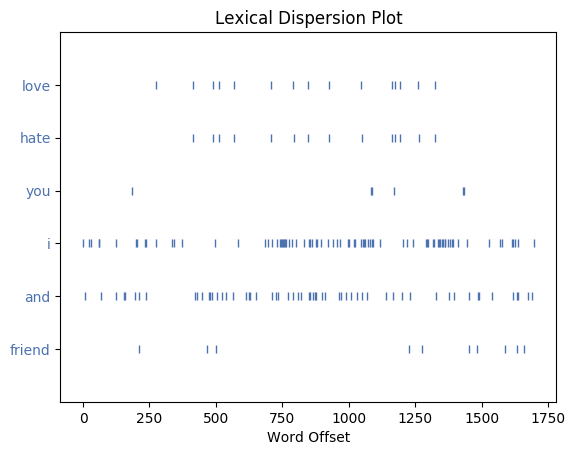

In [63]:
#Lexical Dispersion Plot
sns.reset_orig() #Seaborn messes with this plot, disabling it
post_text.dispersion_plot(['love','hate','you', 'i', 'and', 'friend'])
sns.set() #Re-enabling seaborn

# Filtering and normalizing text

As we want to start comparing the different releases we may choose to do a bit of filtering and normalizing that will allow us to focus on what we most care about. We can first make all of the words lower case, then drop the non-word tokens. Next, we can remove some 'stop words', stem the remaining words to remove suffixes, prefixes and (in some languages) infixes, or lemmatize tokens by intelligently grouping inflected or variant forms of the same word (e.g., with a stemmer and a dictionary). 

To begin this process, we will first define a function to work over the tokenized lists, then another to add normalized tokens to a new column.

We will be using spaCy's built in stop words identifying capacity. When we run text through spaCy's language pipeline, it automatically tags it as a stop word. 

We can remove these stopwords from the analysis by fiat, but we could also take a more principled approach by looking at the frequency distribution of words and selecting a specific cut-off associated with the preservation of 'meaningful words' identified upon inspection. Alternatively, we could automatically set a cut-off by rule, such as removal of all words more frequent then the most frequent verb, or the most frequent noun (not pronoun), or some term of central interest. 

In [64]:
countsDict = {}
for word in whReleases['tokenized_text'].sum():
    if word in countsDict:
        countsDict[word] += 1
    else:
        countsDict[word] = 1
word_counts = sorted(countsDict.items(), key = lambda x : x[1], reverse = True)
word_counts[:20]

[('the', 179),
 ('of', 112),
 ('to', 112),
 ('and', 108),
 ('in', 64),
 ('a', 61),
 ("'s", 50),
 ('that', 41),
 ('our', 39),
 ('for', 35),
 ('on', 33),
 ('is', 33),
 ('Whitehouse', 31),
 ('Iraq', 28),
 ('Bush', 27),
 ('President', 25),
 ('troops', 21),
 ('by', 19),
 ('American', 19),
 ('with', 18)]

We can look at this and pick the cutoff, usually it is at the first noun. So we will cut all words before `'Whitehouse'`.

In [65]:
#The stop list is then all words that occur before the first noun
stop_words_freq = []
for word, count in word_counts:
    if word == 'Whitehouse':
        break
    else:
        stop_words_freq.append(word)
stop_words_freq

['the', 'of', 'to', 'and', 'in', 'a', "'s", 'that', 'our', 'for', 'on', 'is']

If we did have any extra words to add as stop words apart from those normally considered as stop words, we would add it to our stop words by passing it to the normalize tokens method. 

Now we can create our function to normalize the tokens

In [66]:
def normalizeTokens(word_list, extra_stop=[]):
    #We can use a generator here as we just need to iterate over it
    normalized = []
    if type(word_list) == list and len(word_list) == 1:
        word_list = word_list[0]

    if type(word_list) == list:
        word_list = ' '.join([str(elem) for elem in word_list]) 

    doc = nlp(word_list.lower())
    
    # add the property of stop word to words considered as stop words
    if len(extra_stop) > 0:
        for stopword in extra_stop:
            lexeme = nlp.vocab[stopword]
            lexeme.is_stop = True

    for w in doc:
        # if it's not a stop word or punctuation mark, add it to our article
        if w.text != '\n' and not w.is_stop and not w.is_punct and not w.like_num and len(w.text.strip()) > 0:
            # we add the lematized version of the word
            normalized.append(str(w.lemma_))

    return normalized

In [67]:
whReleases['normalized_tokens'] = whReleases['tokenized_text'].apply(lambda x: normalizeTokens(x))

whReleases['normalized_tokens_count'] = whReleases['normalized_tokens'].apply(lambda x: len(x))

whReleases

name  \
0  10Apr2007Whitehouse123.txt   
1    10Apr2008Whitehouse2.txt   
2    10Apr2008Whitehouse3.txt   
3   10Aug2007Whitehouse78.txt   
4   10Jan2008Whitehouse35.txt   
5    10Mar2008Whitehouse8.txt   
6   10Sep2007Whitehouse72.txt   
7  11Apr2007Whitehouse122.txt   
8  11Jan2007Whitehouse161.txt   
9    11Mar2008Whitehouse7.txt   

                                                text  \
0  SEN. WHITEHOUSE SHARES WESTERLY GIRL'S STORY I...   
1  SEN. WHITEHOUSE SAYS PRESIDENT BUSH MUST BEGIN...   
2  EPA MUST REVIEW LEGAL PROCESS TO ROOT OUT POLI...   
3  R.I. SENATORS PRAISE SEN. DENIAL OF LNG FACILI...   
4  SEN. WHITEHOUSE COMMENTS ON ONE-YEAR ANNIVERSA...   
5  SENS. REED, WHITEHOUSE WELCOME RHODE ISLAND ST...   
6  REP. WHITEHOUSE ISSUES STATEMENT ON GEN. PETRA...   
7  SEN. WHITEHOUSE URGES BUSH FOR NEW DIRECTION I...   
8  SENS. REED, WHITEHOUSE URGE PORTUGAL TO RECONS...   
9  WHITEHOUSE UNVEILS 'BUSH DEBT': $7.7 TRILLION ...   

                                        path  \
0  raw/Whitehouse/10Apr2007Whitehouse123.txt   
1    raw/Whitehouse/10Apr2008Whitehouse2.txt   
2    raw/Whitehouse/10Apr2008Whitehouse3.txt   
3   raw/Whitehouse/10Aug2007Whitehouse78.txt   
4   raw/Whitehouse/10Jan2008Whitehouse35.txt   
5    raw/Whitehouse/10Mar2008Whitehouse8.txt   
6   raw/Whitehouse/10Sep2007Whitehouse72.txt   
7  raw/Whitehouse/11Apr2007Whitehouse122.txt   
8  raw/Whitehouse/11Jan2007Whitehouse161.txt   
9    raw/Whitehouse/11Mar2008Whitehouse7.txt   

                                            html_url  \
0  https://github.com/lintool/GrimmerSenatePressR...   
1  https://github.com/lintool/GrimmerSenatePressR...   
2  https://github.com/lintool/GrimmerSenatePressR...   
3  https://github.com/lintool/GrimmerSenatePressR...   
4  https://github.com/lintool/GrimmerSenatePressR...   
5  https://github.com/lintool/GrimmerSenatePressR...   
6  https://github.com/lintool/GrimmerSenatePressR...   
7  https://github.com/lintool/GrimmerSenatePressR...   
8  https://github.com/lintool/GrimmerSenatePressR...   
9  https://github.com/lintool/GrimmerSenatePressR...   

                                        download_url  \
0  https://raw.githubusercontent.com/lintool/Grim...   
1  https://raw.githubusercontent.com/lintool/Grim...   
2  https://raw.githubusercontent.com/lintool/Grim...   
3  https://raw.githubusercontent.com/lintool/Grim...   
4  https://raw.githubusercontent.com/lintool/Grim...   
5  https://raw.githubusercontent.com/lintool/Grim...   
6  https://raw.githubusercontent.com/lintool/Grim...   
7  https://raw.githubusercontent.com/lintool/Grim...   
8  https://raw.githubusercontent.com/lintool/Grim...   
9  https://raw.githubusercontent.com/lintool/Grim...   

                                      tokenized_text  word_counts  \
0  [SEN, WHITEHOUSE, SHARES, WESTERLY, GIRL, 'S, ...          350   
1  [SEN, WHITEHOUSE, SAYS, PRESIDENT, BUSH, MUST,...          311   
2  [EPA, MUST, REVIEW, LEGAL, PROCESS, TO, ROOT, ...          497   
3  [R.I., SENATORS, PRAISE, SEN, DENIAL, OF, LNG,...          189   
4  [SEN, WHITEHOUSE, COMMENTS, ON, ONE, YEAR, ANN...          236   
5  [SENS, REED, WHITEHOUSE, WELCOME, RHODE, ISLAN...          334   
6  [REP, WHITEHOUSE, ISSUES, STATEMENT, ON, GEN, ...          241   
7  [SEN, WHITEHOUSE, URGES, BUSH, FOR, NEW, DIREC...          469   
8  [SENS, REED, WHITEHOUSE, URGE, PORTUGAL, TO, R...          443   
9  [WHITEHOUSE, UNVEILS, BUSH, DEBT, $, 7.7, TRIL...          425   

                                   normalized_tokens  normalized_tokens_count  
0  [sen, whitehouse, share, westerly, girl, story...                      224  
1  [sen, whitehouse, say, president, bush, begin,...                      159  
2  [epa, review, legal, process, root, political,...                      298  
3  [r.i, senator, praise, sen, denial, lng, facil...                      116  
4  [sen, whitehouse, comment, year, anniversary, ...                      125  
5  [sens, reed, whitehouse, welcome, rhod

You can see that in the final step of normalizing, we add the lemmatized form of the word. spaCy's built in lemmatizer does this (https://spacy.io/api/lemmatizer). Lemmatization can be thought of as finding the root or the base of the word after removing inflections and other variations of words. Another possible way of finding the roots of words is using NLTK's porting or stemming functionalities, but we will not be getting into them.

Now that it is cleaned we start analyzing the dataset. We can start by finding frequency distributions for the dataset. Lets start looking at all the press releases together. The [`ConditionalFreqDist`](http://www.nltk.org/api/nltk.html#nltk.probability.ConditionalProbDist) class reads in an iterable of tuples, the first element is the condition and the second the focal word. For starters, we will use word lengths as the conditions, but tags or clusters will provide more useful results.

In [68]:
#.sum() adds together the lists from each row into a single list
whcfdist = nltk.ConditionalFreqDist(((len(w), w) for w in whReleases['normalized_tokens'].sum()))

#print the number of words
print(whcfdist.N())

1966


From this we can lookup the distributions of different word lengths

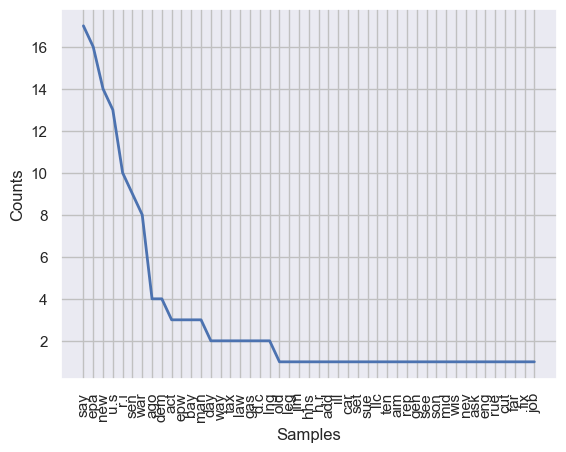

In [69]:
whcfdist[3].plot()

We can also create a Conditional Probability Distribution or [`ConditionalProbDist`](http://www.nltk.org/api/nltk.html#nltk.probability.ConditionalProbDist) from the `ConditionalFreqDist`. To do this, however, we need a model for the probability distribution. A simple model is [`ELEProbDist`](http://www.nltk.org/api/nltk.html#nltk.probability.ELEProbDist) which gives the expected likelihood estimate for the probability distribution of the experiment used to generate the observed frequency distribution. 

In [70]:
whcpdist = nltk.ConditionalProbDist(whcfdist, nltk.ELEProbDist)

#print the most common 2 letter word
print(whcpdist[2].max())

#And its probability
print(whcpdist[2].prob(whcpdist[2].max()))

ri
0.25


Length is one feature of a word, but there are many more important features we care about. Another critical feature is a word's role in the sentence, or its part of speech (POS). 

The method below works similarly to ```nltk.pos_text```, and can work with the conditional frequency distributions it provides.

In [71]:
def spacy_pos(word_list):
    tags = []
    doc = nlp(word_list.lower())
    for w in doc:
        tags.append((w.text, w.tag_))
    return tags

In [72]:
whReleases['normalized_tokens_POS'] = [spacy_pos(t) for t in whReleases['text']]

This gives us a new column with the part of speech as a short initialism and the word in a tuple, exactly how the `nltk.ConditionalFreqDist()` function wants them. We can now construct another conditional frequency distribution.

In [73]:
whcfdist_WordtoPOS = nltk.ConditionalFreqDist(whReleases['normalized_tokens_POS'].sum())
list(whcfdist_WordtoPOS.items())[:10]

[('sen', FreqDist({'NNP': 9})),
 ('.', FreqDist({'.': 132, 'NNP': 34})),
 ('whitehouse', FreqDist({'NNP': 17, 'VB': 14, 'NN': 4, 'RB': 4, 'WDT': 1})),
 ('shares', FreqDist({'VBZ': 1})),
 ('westerly', FreqDist({'RB': 2})),
 ('girl', FreqDist({'NN': 2})),
 ("'s", FreqDist({'POS': 47, 'VBZ': 5})),
 ('story', FreqDist({'NN': 2})),
 ('in', FreqDist({'IN': 72})),
 ('push', FreqDist({'NN': 1}))]

This gives the frequency of each word as each part of speech...which can be uninformative and boring.

What we want is the converse; the frequency of each part of speech for each word.

In [74]:
whcfdist_POStoWord = nltk.ConditionalFreqDist((p, w) for w, p in whReleases['normalized_tokens_POS'].sum())

We can now identify and collect all of the superlative adjectives

In [75]:
whcfdist_POStoWord['JJ']

FreqDist({'american': 17, 'new': 10, 'portuguese': 9, 'political': 8, 'federal': 6, 'clear': 5, 'potential': 5, 'fiscal': 5, 'last': 4, 'several': 4, ...})

Or look at the most common nouns

In [76]:
whcfdist_POStoWord['NN'].most_common(5)

[('today', 15),
 ('year', 12),
 ('administration', 11),
 ('stem', 10),
 ('consulate', 10)]

Or plot the base form verbs against their number of occurrences

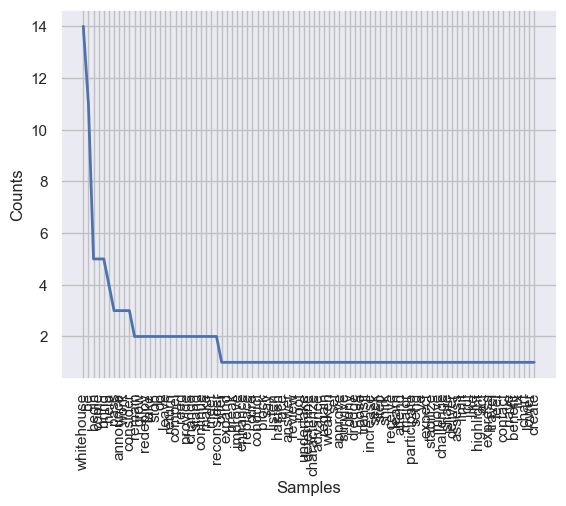

In [77]:
whcfdist_POStoWord['VB'].plot()

We can then do a similar analysis of the word probabilities

In [78]:
whcpdist_POStoWord = nltk.ConditionalProbDist(whcfdist_POStoWord, nltk.ELEProbDist)

#print the most common nouns
print(whcpdist_POStoWord['NN'].max())

#And its probability
print(whcpdist_POStoWord['NN'].prob(whcpdist_POStoWord['NN'].max()))

today
0.020195439739413682


We can even create a...wait for it...*WORD CLOUD* or Wordl to gaze at and draw mystical, approximate inferences about important nouns and verbs in our corpus:

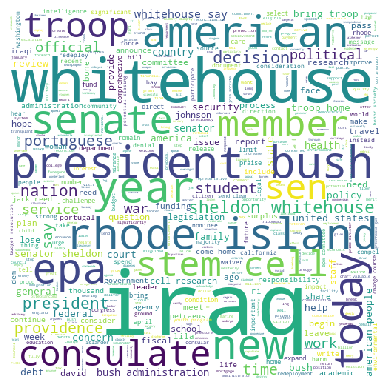

In [79]:
wc = wordcloud.WordCloud(background_color="white", max_words=500, width= 1000, height = 1000, mode ='RGBA', scale=.5).generate(' '.join(whReleases['normalized_tokens'].sum()))
plt.imshow(wc)
plt.axis("off")
plt.savefig("whitehouse_word_cloud.pdf", format = 'pdf')

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">Construct cells immediately below this that filter, stem and lemmatize the tokens in your corpus, and then creates plots (with titles and labels) that map the word frequency distribution, word probability distribution, and at least two conditional probability distributions that help us better understand the social and cultural game underlying the production of your corpus. Create a wordl of words (or normalized words) and add a few vague comments about what mysteries are revealed through it.</span>

In [80]:
data[:5]

text  \
4162441.male.16.Student.Sagittarius.xml  DESTINY...       you might not say anything   ...   
3364931.male.16.Student.Virgo.xml        Today was....normal. Nothing much to talk abou...   
3846432.male.16.Student.Leo.xml          Well it's another day and another morning, one...   
4157968.male.16.Student.Pisces.xml       As I strolled into the mall yesterday, gently ...   
2727849.female.26.Arts.Libra.xml         two weeks later I finally write to you about n...   

                                                                                   cleaned  \
4162441.male.16.Student.Sagittarius.xml  destiny...       you might not say anything   ...   
3364931.male.16.Student.Virgo.xml        today was....normal. nothing much to talk abou...   
3846432.male.16.Student.Leo.xml          well it's another day and another morning, one...   
4157968.male.16.Student.Pisces.xml       as i strolled into the mall yesterday, gently ...   
2727849.female.26.Arts.Libra.xml         two weeks later i finally write to you about n...   

                                                                            tokenized_text  \
4162441.male.16.Student.Sagittarius.xml  [destiny, you, might, not, say, anything, but,...   
3364931.male.16.Student.Virgo.xml        [today, was, normal, nothing, much, to, talk, ...   
3846432.male.16.Student.Leo.xml          [well, it, 's, another, day, and, another, mor...   
4157968.male.16.Student.Pisces.xml       [as, i, strolled, into, the, mall, yesterday, ...   
2727849.female.26.Arts.Libra.xml         [two, weeks, later, i, finally, write, to, you...   

                                         word_counts  
4162441.male.16.Student.Sagittarius.xml         1107  
3364931.male.16.Student.Virgo.xml               4756  
3846432.male.16.Student.Leo.xml                 1475  
4157968.male.16.Student.Pisces.xml              2382  
2727849.female.26.Arts.Libra.xml                 560

In [81]:
countsDict = {}
for word in data['tokenized_text'].sum():
    if word in countsDict:
        countsDict[word] += 1
    else:
        countsDict[word] = 1
word_counts = sorted(countsDict.items(), key = lambda x : x[1], reverse = True)

In [83]:
word_counts[0:20]

[('i', 88584),
 ('the', 77844),
 ('to', 61262),
 ('and', 54833),
 ('a', 43525),
 ('of', 35502),
 ('it', 30863),
 ('that', 29990),
 ('in', 25816),
 ('my', 23596),
 ('is', 23081),
 ('you', 20839),
 ('was', 19288),
 ('for', 18240),
 ('me', 15849),
 ('but', 15657),
 ('so', 14386),
 ('on', 14265),
 ("'s", 14234),
 ('have', 13830)]

In [84]:
data['normalized_tokens'] = data['tokenized_text'].apply(lambda x: normalizeTokens(x))
data['normalized_tokens_count'] = data['normalized_tokens'].apply(lambda x: len(x))

data[:5]

text  \
4162441.male.16.Student.Sagittarius.xml  DESTINY...       you might not say anything   ...   
3364931.male.16.Student.Virgo.xml        Today was....normal. Nothing much to talk abou...   
3846432.male.16.Student.Leo.xml          Well it's another day and another morning, one...   
4157968.male.16.Student.Pisces.xml       As I strolled into the mall yesterday, gently ...   
2727849.female.26.Arts.Libra.xml         two weeks later I finally write to you about n...   

                                                                                   cleaned  \
4162441.male.16.Student.Sagittarius.xml  destiny...       you might not say anything   ...   
3364931.male.16.Student.Virgo.xml        today was....normal. nothing much to talk abou...   
3846432.male.16.Student.Leo.xml          well it's another day and another morning, one...   
4157968.male.16.Student.Pisces.xml       as i strolled into the mall yesterday, gently ...   
2727849.female.26.Arts.Libra.xml         two weeks later i finally write to you about n...   

                                                                            tokenized_text  \
4162441.male.16.Student.Sagittarius.xml  [destiny, you, might, not, say, anything, but,...   
3364931.male.16.Student.Virgo.xml        [today, was, normal, nothing, much, to, talk, ...   
3846432.male.16.Student.Leo.xml          [well, it, 's, another, day, and, another, mor...   
4157968.male.16.Student.Pisces.xml       [as, i, strolled, into, the, mall, yesterday, ...   
2727849.female.26.Arts.Libra.xml         [two, weeks, later, i, finally, write, to, you...   

                                         word_counts  \
4162441.male.16.Student.Sagittarius.xml         1107   
3364931.male.16.Student.Virgo.xml               4756   
3846432.male.16.Student.Leo.xml                 1475   
4157968.male.16.Student.Pisces.xml              2382   
2727849.female.26.Arts.Libra.xml                 560   

                                                                         normalized_tokens  \
4162441.male.16.Student.Sagittarius.xml  [destiny, hear, choose, life, partner, dear, d...   
3364931.male.16.Student.Virgo.xml        [today, normal, talk, get, mid, year, papers.i...   
3846432.male.16.Student.Leo.xml          [day, morning, hope, right, go, write, thing, ...   
4157968.male.16.Student.Pisces.xml       [stroll, mall, yesterday, gently, bypass, grou...   
2727849.female.26.Arts.Libra.xml         [week, later, finally, write, particular, writ...   

                                         normalized_tokens_count  
4162441.male.16.Student.Sagittarius.xml                      528  
3364931.male.16.Student.Virgo.xml                           2062  
3846432.male.16.Student.Leo.xml                              503  
4157968.male.16.Student.Pisces.xml                          1034  
2727849.female.26.Arts.Libra.xml                             216

In [85]:
#Frequency
fdist = nltk.FreqDist([w for w in data['normalized_tokens'].sum()])

In [86]:
fdist

FreqDist({'like': 10058, 'm': 9335, 'go': 7845, 'know': 7380, 'think': 7114, 'time': 6808, 'get': 6453, 'thing': 5241, 'good': 5198, 'day': 5064, ...})

In [98]:
# Frequency distribution condition on word lengths
freqdist = nltk.ConditionalFreqDist(((len(w), w) for w in data['normalized_tokens'].sum() if fdist[w]>100))
print(freqdist.N())

605257


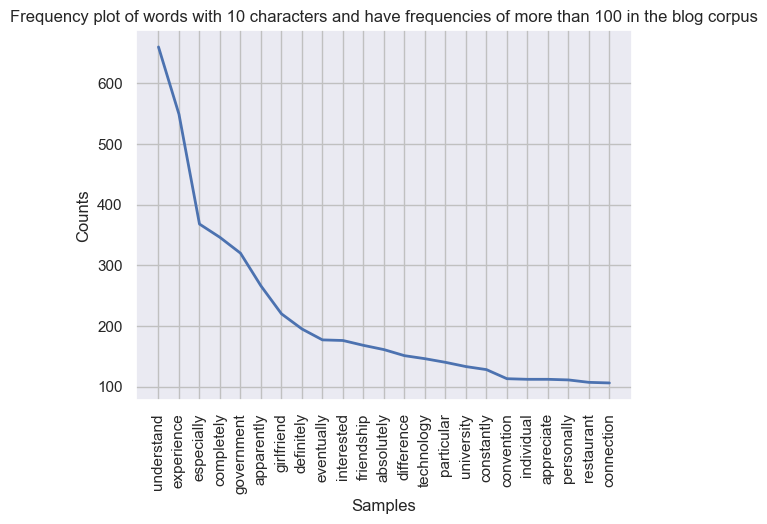

In [100]:
import warnings
warnings.filterwarnings('ignore')

# frequency plot for words of 10 characters
plt.title("Frequency plot of words with 10 characters and have frequencies of more than 100 in the blog corpus")
freqdist[10].plot()

269148


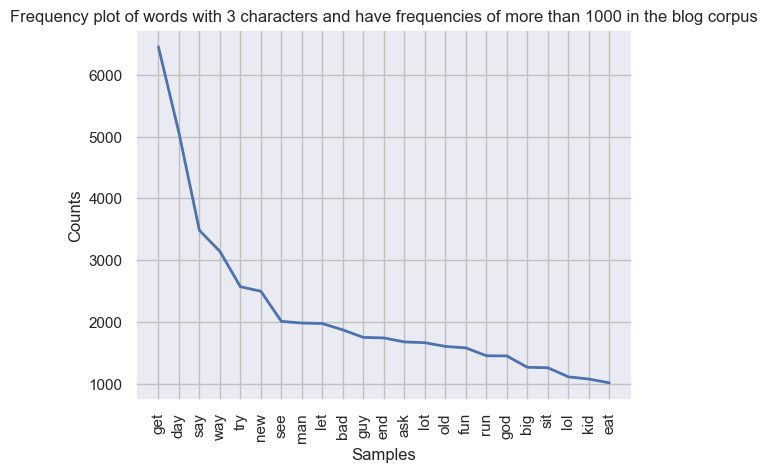

In [89]:
# Frequency distribution condition on word lengths, only if frequency is more than 1000
freqdist = nltk.ConditionalFreqDist(((len(w), w) for w in data['normalized_tokens'].sum() if fdist[w]>1000))
print(freqdist.N())

# frequency plot for words of 3 characters
plt.title("Frequency plot of words with 3 characters and have frequencies of more than 1000 in the blog corpus")
freqdist[3].plot()

In [90]:
# Probability
freqdist = nltk.ConditionalFreqDist(((len(w), w) for w in data['normalized_tokens'].sum()))
print(freqdist.N())

condprobdist = nltk.ConditionalProbDist(freqdist, nltk.ELEProbDist)

#print the most common n letter word
print("The most common 2 letter word is {}, probability: {}".format(condprobdist[2].max(), condprobdist[2].prob(condprobdist[2].max())))
print("The most common 3 letter word is {}, probability: {}".format(condprobdist[3].max(), condprobdist[3].prob(condprobdist[2].max())))
print("The most common 5 letter word is {}, probability: {}".format(condprobdist[5].max(), condprobdist[5].prob(condprobdist[2].max())))
print("The most common 8 letter word is {}, probability: {}".format(condprobdist[8].max(), condprobdist[8].prob(condprobdist[2].max())))
print("The most common 10 letter word is {}, probability: {}".format(condprobdist[10].max(), condprobdist[10].prob(condprobdist[2].max())))

898667
The most common 2 letter word is go, probability: 0.2299687825182102
The most common 3 letter word is get, probability: 4.318516503210817e-06
The most common 5 letter word is think, probability: 3.0426673238828085e-06
The most common 8 letter word is actually, probability: 9.296358616329983e-06
The most common 10 letter word is understand, probability: 2.2082854871477785e-05


In [93]:
#POS
data['normalized_tokens_POS'] = [spacy_pos(t) for t in data['text']]

In [94]:
data[:5]

text  \
4162441.male.16.Student.Sagittarius.xml  DESTINY...       you might not say anything   ...   
3364931.male.16.Student.Virgo.xml        Today was....normal. Nothing much to talk abou...   
3846432.male.16.Student.Leo.xml          Well it's another day and another morning, one...   
4157968.male.16.Student.Pisces.xml       As I strolled into the mall yesterday, gently ...   
2727849.female.26.Arts.Libra.xml         two weeks later I finally write to you about n...   

                                                                                   cleaned  \
4162441.male.16.Student.Sagittarius.xml  destiny...       you might not say anything   ...   
3364931.male.16.Student.Virgo.xml        today was....normal. nothing much to talk abou...   
3846432.male.16.Student.Leo.xml          well it's another day and another morning, one...   
4157968.male.16.Student.Pisces.xml       as i strolled into the mall yesterday, gently ...   
2727849.female.26.Arts.Libra.xml         two weeks later i finally write to you about n...   

                                                                            tokenized_text  \
4162441.male.16.Student.Sagittarius.xml  [destiny, you, might, not, say, anything, but,...   
3364931.male.16.Student.Virgo.xml        [today, was, normal, nothing, much, to, talk, ...   
3846432.male.16.Student.Leo.xml          [well, it, 's, another, day, and, another, mor...   
4157968.male.16.Student.Pisces.xml       [as, i, strolled, into, the, mall, yesterday, ...   
2727849.female.26.Arts.Libra.xml         [two, weeks, later, i, finally, write, to, you...   

                                         word_counts  \
4162441.male.16.Student.Sagittarius.xml         1107   
3364931.male.16.Student.Virgo.xml               4756   
3846432.male.16.Student.Leo.xml                 1475   
4157968.male.16.Student.Pisces.xml              2382   
2727849.female.26.Arts.Libra.xml                 560   

                                                                         normalized_tokens  \
4162441.male.16.Student.Sagittarius.xml  [destiny, hear, choose, life, partner, dear, d...   
3364931.male.16.Student.Virgo.xml        [today, normal, talk, get, mid, year, papers.i...   
3846432.male.16.Student.Leo.xml          [day, morning, hope, right, go, write, thing, ...   
4157968.male.16.Student.Pisces.xml       [stroll, mall, yesterday, gently, bypass, grou...   
2727849.female.26.Arts.Libra.xml         [week, later, finally, write, particular, writ...   

                                         normalized_tokens_count  \
4162441.male.16.Student.Sagittarius.xml                      528   
3364931.male.16.Student.Virgo.xml                           2062   
3846432.male.16.Student.Leo.xml                              503   
4157968.male.16.Student.Pisces.xml                          1034   
2727849.female.26.Arts.Libra.xml                             216   

                                                                     normalized_tokens_POS  
4162441.male.16.Student.Sagittarius.xml  [(destiny, NN), (..., :), (      , _SP), (you,...  
3364931.male.16.Student.Virgo.xml        [(today, NN), (was, VBD), (...., .), (normal, ...  
3846432.male.16.Student.Leo.xml          [(well, UH), (it, PRP), ('s, VBZ), (another, D...  
4157968.male.16.Student.Pisces.xml       [(as, IN), (i, PRP), (strolled, VBD), (into, I...  
2727849.female.26.Arts.Libra.xml         [(two, CD), (weeks, NNS), (later, RB), (i, PRP...

In [101]:
# Most common noun
freqdist_POStoWord = nltk.ConditionalFreqDist((p, w) for w, p in data['normalized_tokens_POS'].sum())
freqdist_POStoWord['NN'].most_common(10)

[('time', 5762),
 ('day', 3593),
 ('life', 3172),
 ('today', 2774),
 ('something', 2751),
 ('way', 2749),
 ('thing', 2349),
 ('night', 1924),
 ('school', 1900),
 ('one', 1615)]

In [103]:
# Most common adjective
freqdist_POStoWord['JJ'].most_common(10)

[('good', 3853),
 ('other', 3135),
 ('little', 2213),
 ('last', 2207),
 ('new', 2174),
 ('first', 1840),
 ('many', 1695),
 ('much', 1546),
 ('great', 1505),
 ('few', 1452)]

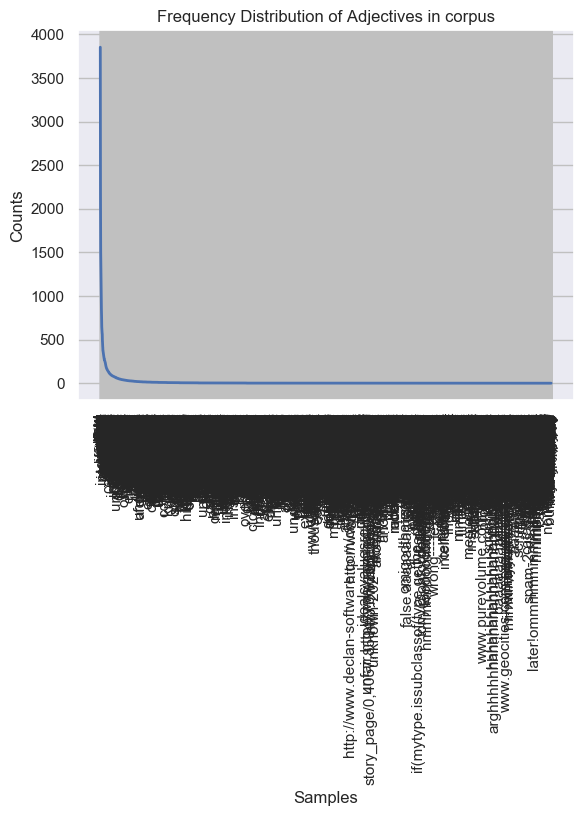

In [108]:
freqdist_POStoWord['JJ'].plot(title="Frequency Distribution of Adjectives in corpus")

In [105]:
# Most common verb
freqdist_POStoWord['VB'].most_common(10)

[('be', 12379),
 ('have', 4793),
 ('do', 4736),
 ('get', 4663),
 ('go', 3995),
 ('know', 2835),
 ('see', 2804),
 ("'ve", 2602),
 ('make', 2229),
 ('say', 1990)]

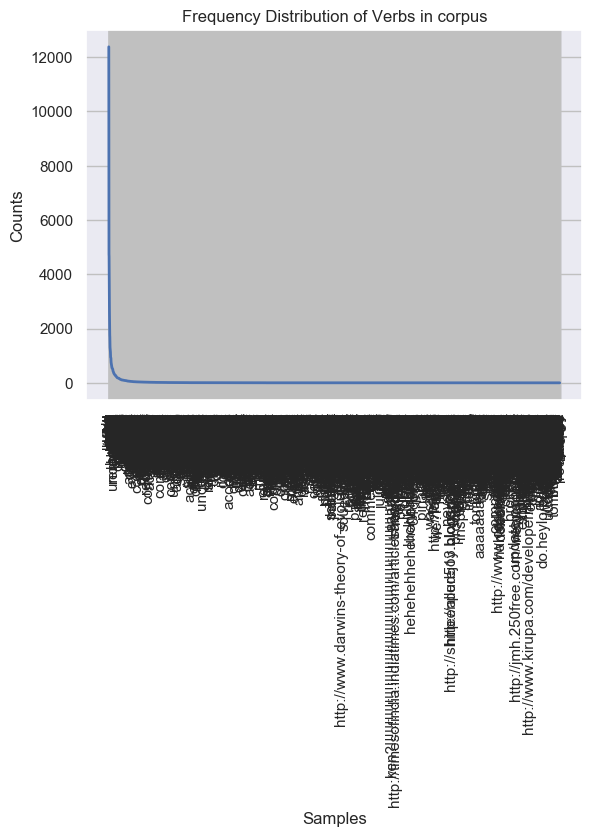

In [106]:
freqdist_POStoWord['VB'].plot(title="Frequency Distribution of Verbs in corpus")

(-0.5, 499.5, 499.5, -0.5)

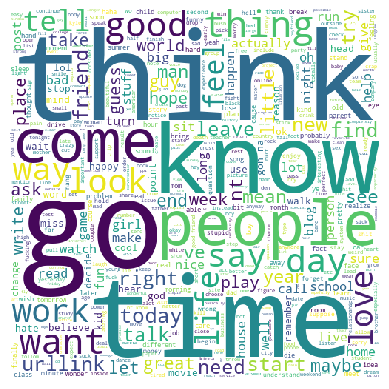

In [107]:
#Word Cloud
wc = wordcloud.WordCloud(background_color="white", max_words=500, width= 1000, height = 1000, mode ='RGBA', scale=.5).generate(' '.join(data['normalized_tokens'].sum()))
plt.imshow(wc)
plt.axis("off")
#plt.savefig("blog_wc.pdf", format = 'pdf')

Based on the word in the wordcloud as well as the conditional frequency distributions, we can see that many of the common words relate to day to day activities. Notably the most common verb is 'be'. This suggests most of the blog posts relate to describing and reflecting on daily activities and thoughts as compared to writing a colorful narrative. When adjectives were used, they were mostly simple words such as good, great and new.

However, we also see that the data has not been parsed accurately occasionally with urls being tagged as both verbs and adjectives.

## Davies Corpora

Now that we have our basic cleaning down, we can arrange our Davies Corpora. Let us try this with the movies corpora we have already loaded.

We'll use a smaller corpus of a 1000 movies for this demonstration.

In [111]:
zfile = zipfile.ZipFile(corpus_name + "/sources_movies.zip")
source = []

In [112]:
for file in zfile.namelist():
    with zfile.open(file) as f:
        for line in f:
            source.append(line)

In [113]:
source[0:20]

[b'textID\tfileID\t#words\tgenre\tyear\tlanguage(s)\tcountry\timdb\ttitle\r\n',
 b'-----\t-----\t-----\t-----\t-----\t-----\t-----\t-----\t-----\r\n',
 b'\r\n',
 b'290635\t3547424\t4722\tShort, Musical\t1930\tUK\tEnglish\t0290635\tGoodbye to All That\r\n',
 b'21165\t6332374\t10220\tCrime, Mystery, Thriller\t1930\tUK\tEnglish\t0021165\tMurder!\r\n',
 b'21191\t6013789\t5281\tDrama, Romance\t1930\tUSA\tEnglish\t0021191\tA Notorious Affair\r\n',
 b'20620\t3660608\t6724\tBiography, Drama, History\t1930\tUSA\tEnglish\t0020620\tAbraham Lincoln\r\n',
 b'20629\t60053\t9552\tDrama, War\t1930\tUSA\tEnglish, French, German, Latin\t0020629\tAll Quiet on the Western Front\r\n',
 b'20640\t6850720\t13862\tComedy, Musical\t1930\tUSA\tEnglish\t0020640\tAnimal Crackers\r\n',
 b'20641\t176501\t11140\tDrama, Romance\t1930\tUSA\tEnglish\t0020641\tAnna Christie\r\n',
 b'20643\t3603861\t1748\tComedy, Short\t1930\tUSA\tEnglish\t0020643\tAnother Fine Mess\r\n',
 b'20670\t4159455\t6966\tComedy, Musical\t1930\tUS

It looks dirty because the file is encoded as bytes, but we can certainly see the information in here. The file id is also present in the original raw text data: as the first "word". Look back at the normalized/tokenized words to confirm that. We're going to use this to create a dataframe with: Fileid, movie name, genre, year, and country.

It is advised that you run a similar check of the source file before you do other extraction.

First, let us create a dictionary mapping file-id to all the text. Each movie will be mapped to a list of the tokenized words.

In this example, I only use it to load 100 movies. You can comment this out or increase/decrease the number as you see fit.

In [114]:
movie_texts = {}

In [115]:
for files in movie_raw:
    if len(movie_texts) > 100:
        break
    movies = clean_raw_text(movie_raw[files][1:])
    for movie in movies:
        txts = lucem_illud_2020.word_tokenize(movie)
        try:
            movie_texts[txts[0][2:]] = txts[1:]
        except IndexError:
            continue

In [116]:
import pandas as pd

In [117]:
movie_df = pd.DataFrame(columns=["Movie Name", "Genre", "Year", "Country", "Tokenized Texts"])

In [118]:
for movie in source[3:]:
    try:
        tid, fileid, total_words, genre, year, lang, country, imdb, title = movie.decode("utf-8").split("\t")
    except UnicodeDecodeError:
        continue
    try:
        movie_df.loc[fileid.strip()] = [title.strip(), genre.strip(), year.strip(), country.strip(), movie_texts[fileid.strip()]]
    except KeyError:
        continue

In [119]:
movie_df.head()

Movie Name            Genre  Year          Country  \
6850720    Animal Crackers  Comedy, Musical  1930          English   
176501       Anna Christie   Drama, Romance  1930          English   
4056770  Ladies of Leisure   Drama, Romance  1930          English   
5992934      Over the Hill            Drama  1931          English   
4436137  Design for Living  Comedy, Romance  1933  English, French   

                                           Tokenized Texts  
6850720  [You, must, do, your, best, tonight, Be, on, y...  
176501   [Either, you, 're, flat, or, I, am, I, beg, yo...  
4056770  [Look, out, There, 's, another, bottle, coming...  
5992934  [Good, morning, kitty, Come, in, here, baby, I...  
4436137  [Train_engine_grinding, 26;1426;TOOLONG, Whist...

# Part-of-Speech (POS) tagging

In POS tagging, we classify each word by its semantic role in a sentence. We will be using the in-built spaCy pos-tagging.

https://spacy.io/usage/linguistic-features

|#. |Tag |Description |
|---|----|------------|
|1.	|CC	|Coordinating conjunction
|2.	|CD	|Cardinal number
|3.	|DT	|Determiner
|4.	|EX	|Existential there
|5.	|FW	|Foreign word
|6.	|IN	|Preposition or subordinating conjunction
|7.	|JJ	|Adjective
|8.	|JJR|	Adjective, comparative
|9.	|JJS|	Adjective, superlative
|10.|	LS	|List item marker
|11.|	MD	|Modal
|12.|	NN	|Noun, singular or mass
|13.|	NNS	|Noun, plural
|14.|	NNP	|Proper noun, singular
|15.|	NNPS|	Proper noun, plural
|16.|	PDT	|Predeterminer
|17.|	POS	|Possessive ending
|18.|	PRP	|Personal pronoun
|19.|	PRP\$|	Possessive pronoun
|20.|	RB	|Adverb
|21.|	RBR	|Adverb, comparative
|22.|	RBS	|Adverb, superlative
|23.|	RP	|Particle
|24.|	SYM	|Symbol
|25.|	TO	|to
|26.|	UH	|Interjection
|27.|	VB	|Verb, base form
|28.|	VBD	|Verb, past tense
|29.|	VBG	|Verb, gerund or present participle
|30.|	VBN	|Verb, past participle
|31.|	VBP	|Verb, non-3rd person singular present
|32.|	VBZ	|Verb, 3rd person singular present
|33.|	WDT	|Wh-determiner
|34.|	WP	|Wh-pronoun
|35.|	WP$	|Possessive wh-pronoun
|36.|	WRB	|Wh-adverb

spaCy pos-tags word as we run it through the english language model. A small example:

In [120]:
sent = nlp(u"Tom went to IKEA to get some of those delicious Swedish meatballs.")

In [121]:
for token in sent:
    print(token.text, token.pos_, token.tag_)

Tom PROPN NNP
went VERB VBD
to ADP IN
IKEA PROPN NNP
to PART TO
get AUX VB
some DET DT
of ADP IN
those DET DT
delicious ADJ JJ
Swedish ADJ JJ
meatballs NOUN NNS
. PUNCT .


This looks quite good. Now we will try POS tagging with a somewhat larger corpus. We consider a few of the top posts from the reddit data we used last week.

In [122]:
redditDF = pandas.read_csv('../data/reddit.csv')

Grabbing the 10 highest scoring posts and tokenizing the sentences. Once again, notice that we aren't going to do any kind of stemming this week (although *semantic* normalization may be performed where we translate synonyms into the same focal word). Here, we will use sentences tokenized by spaCy. Like before, these methods can also be found in lucem_illud.



In [123]:
def sent_tokenize(word_list):
    doc = nlp(word_list)
    sentences = [sent.string.strip() for sent in doc.sents]
    return sentences

In [124]:
redditTopScores = redditDF.sort_values('score')[-10:]
redditTopScores['sentences'] = redditTopScores['text'].apply(lambda x: [word_tokenize(s) for s in sent_tokenize(x)])
redditTopScores.index = range(len(redditTopScores) - 1, -1,-1) #Reindex to make things nice in the future
redditTopScores

Unnamed: 0                author  over_18  score                subreddit  \
9           8        brenkelieshere    False   9448  Tales From Tech Support   
8           7             Bombadils    False  10528  Tales From Tech Support   
7        1200  whenlifegivesyoushit    False  11003            Relationships   
6           6                sfsdfd    False  11295  Tales From Tech Support   
5           5               Raitaro    False  12372  Tales From Tech Support   
4           4           goldie-gold    False  12650  Tales From Tech Support   
3           3        TheDroolinFool    False  13152  Tales From Tech Support   
2           2     Clickity_clickity    False  13404  Tales From Tech Support   
1           1                SECGaz    False  13724  Tales From Tech Support   
0           0      guitarsdontdance    False  14089  Tales From Tech Support   

                                                text  \
9  Last year, Help Desk got a call from a user co...   
8  First post in quite some time! I work at a loc...   
7  [Original Post](https://www.reddit.com/r/relat...   
6  I witnessed this astounding IT meltdown around...   
5  I work Helpdesk for a retail store chain in th...   
4  This just happened...  So, I had a laptop syst...   
3  Another tale from the out of hours IT desk... ...   
2  [Part 1](http://www.reddit.com/r/talesfromtech...   
1  > $Me  - Hello, IT.   > $Usr - Hi, I am still ...   
0  So my story starts on what was a normal day ta...   

                                               title  \
9  How to fix a laptop that won't boot in under a...   
8                  OK, now the password is 'D35p41r'   
7  [UPDATE]My [26 F] with my husband [29 M] 1 yea...   
6  Company-wide email + 30,000 employees + auto-r...   
5  I'm pretty sure I knocked a user out from near...   
4      Engineer is doing drugs!! No. No they aren't.   
3       "I need you to fix Google Bing immediately!"   
2                   Jack, the Worst End User, Part 4   
1              Hi, I am still off sick but I am not.   
0  "Don't bother sending a tech, I'll be dead by ...   

                                                 url  \
9  https://www.reddit.com/r/talesfromtechsupport/...   
8  https://www.reddit.com/r/talesfromtechsupport/...   
7  https://www.reddit.com/r/relationships/comment...   
6  https://www.reddit.com/r/talesfromtechsupport/...   
5  https://www.reddit.com/r/talesfromtechsupport/...   
4  https://www.reddit.com/r/talesfromtechsupport/...   
3  https://www.reddit.com/r/talesfromtechsupport/...   
2  https://www.reddit.com/r/talesfromtechsupport/...   
1  https://www.reddit.com/r/talesfromtechsupport/...   
0  https://www.reddit.com/r/talesfromtechsupport/...   

                                           sentences  
9  [[Last, year, Help, Desk, got, a, call, from, ...  
8  [[First, post, in, quite, some, time], [I, wor...  
7  [[Original, Post](https://www.reddit.com, r, r...  
6  [[I, witnessed, this, astounding, IT, meltdown...  
5  [[I, work, Helpdesk, for, a, retail, store, ch...  
4  [[This, just, happened], [So, I, had, a, lapto...  
3  [[Another, tale, from, the, out, of, hours], [...  
2  [[Part, 1](http://www.reddit.com, r, talesfrom...  
1  [[>], [$, Me], [Hello, IT], [>, $], [Usr, Hi, ...  
0  [[So, my, story, starts, on, what, was, a, nor...

In [125]:
def tag_sents_pos(sentences):
    """
    function which replicates NLTK pos tagging on sentences.
    """
    new_sents = []
    for sentence in sentences:
        new_sent = ' '.join(sentence)
        new_sents.append(new_sent)
    final_string = ' '.join(new_sents)
    doc = nlp(final_string)
    
    pos_sents = []
    for sent in doc.sents:
        pos_sent = []
        for token in sent:
            pos_sent.append((token.text, token.tag_))
        pos_sents.append(pos_sent)
    
    return pos_sents

In [126]:
redditTopScores['POS_sents'] = redditTopScores['sentences'].apply(lambda x: tag_sents_pos(x))

In [127]:
redditTopScores['POS_sents']

9    [[(Last, JJ), (year, NN), (Help, NNP), (Desk, ...
8    [[(First, JJ), (post, NN), (in, IN), (quite, P...
7    [[(Original, NNP), (Post](https://www.reddit.c...
6    [[(I, PRP), (witnessed, VBD), (this, DT), (ast...
5    [[(I, PRP), (work, VBP), (Helpdesk, NNP), (for...
4    [[(This, DT), (just, RB), (happened, VBD)], [(...
3    [[(Another, DT), (tale, NN), (from, IN), (the,...
2    [[(Part, NN), (1](http://www.reddit.com, CD), ...
1    [[(>, XX)], [($, $)], [(Me, PRP)], [(Hello, UH...
0    [[(So, RB), (my, PRP$), (story, NN), (starts, ...
Name: POS_sents, dtype: object

And count the number of `NN` (nouns)

In [128]:
countTarget = 'NN'
targetCounts = {}
for entry in redditTopScores['POS_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in targetCounts:
                targetCounts[ent] += 1
            else:
                targetCounts[ent] = 1
sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
sortedTargets[:20]

[('m', 21),
 ('password', 21),
 ('time', 14),
 ('computer', 13),
 ('lot', 12),
 ('life', 11),
 ('email', 11),
 ('system', 10),
 ('laptop', 9),
 ('message', 9),
 ('Genius', 9),
 ('day', 9),
 ('auto', 9),
 ('call', 8),
 ('office', 8),
 ('part', 8),
 ('today', 8),
 ('story', 8),
 ('user', 7),
 ('job', 7)]

What about the adjectives that modify the word, "computer"?

In [129]:
NTarget = 'JJ'
Word = 'computer'
NResults = set()
for entry in redditTopScores['POS_sents']:
    for sentence in entry:
        for (ent1, kind1),(ent2,kind2) in zip(sentence[:-1], sentence[1:]):
            if (kind1,ent2.lower())==(NTarget,Word):
                NResults.add(ent1)
            else:
                continue

print(NResults)     

{'own', 'unrestricted'}


## <span style="color:red">*Your turn*</span>

<span style="color:red">In the cells immediately following, perform POS tagging on a meaningful (but modest) subset of a corpus associated with your final project. Examine the list of words associated with at least three different parts of speech. Consider conditional associations (e.g., adjectives associated with nouns or adverbs with verbs of interest). What do these distributions suggest about your corpus?

In [130]:
data_100=data[:100]

In [131]:
data_100['sentences'] = data_100['text'].apply(lambda x: [word_tokenize(s) for s in sent_tokenize(x)])

In [132]:
data_100['POS_sents'] = data_100['sentences'].apply(lambda x: tag_sents_pos(x))

In [145]:
def POS_count(countTarget,n,data):
    targetCounts = {}
    for entry in data['POS_sents']:
        for sentence in entry:
            for ent, kind in sentence:
                if kind != countTarget:
                    continue
                elif ent in targetCounts:
                    targetCounts[ent] += 1
                else:
                    targetCounts[ent] = 1
    sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
    return sortedTargets[:n]

In [146]:
POS_count('NN',20,data_100) # Nouns

[('m', 760),
 ('time', 596),
 ('day', 389),
 ('life', 281),
 ('way', 259),
 ('something', 246),
 ('today', 231),
 ('thing', 223),
 ('night', 195),
 ('school', 181),
 ('someone', 176),
 ('love', 171),
 ('year', 166),
 ('one', 161),
 ('work', 150),
 ('friend', 148),
 ('anything', 143),
 ('stuff', 134),
 ('place', 131),
 ('everything', 125)]

In [147]:
POS_count('PRP',10,data_100) # Personal Pronouns

[('I', 6942),
 ('i', 3076),
 ('it', 2636),
 ('you', 1980),
 ('me', 1798),
 ('we', 863),
 ('she', 774),
 ('they', 748),
 ('he', 724),
 ('It', 503)]

In [148]:
POS_count('VB',10,data_100) # Verbs

[('be', 1303),
 ('have', 578),
 ('get', 458),
 ('do', 428),
 ('go', 386),
 ('know', 314),
 ('see', 294),
 ('make', 224),
 ('say', 182),
 ('take', 167)]

In [152]:
def cond_assoc(NTarget, Word, data):
    NResults = set()
    for entry in data['POS_sents']:
        for sentence in entry:
            for (ent1, kind1),(ent2,kind2) in zip(sentence[:-1], sentence[1:]):
                if (kind1,ent2.lower())==(NTarget,Word):
                    NResults.add(ent1)
                else:
                    continue

    return NResults

In [153]:
cond_assoc('VB', 'i', data_100)

{'Have',
 'Look',
 'Mean',
 'Suppose',
 'add',
 'admit',
 'anticipate',
 'argue',
 'ask',
 'assume',
 'attack',
 'ayo',
 'be',
 'believe',
 'care',
 'change',
 'come',
 'cry',
 'die',
 'dislike',
 'do',
 'drink',
 'escape',
 'explain',
 'feel',
 'find',
 'fish',
 'forget',
 'get',
 'guess',
 'guide',
 'happen',
 'have',
 'improve',
 'join',
 'judge',
 'know',
 'mean',
 'notice',
 'pay',
 'pink',
 'pretend',
 'remember',
 'say',
 'see',
 'shake',
 'share',
 'shine',
 'show',
 'stupid',
 'suck',
 'talk',
 'tat',
 'think',
 'try',
 'urlLink',
 'vote',
 'wait',
 'win',
 'wish',
 'worry'}

In [154]:
cond_assoc('JJ', 'time', data_100)

{'1st',
 '2nd',
 'Enough',
 'First',
 'LAST',
 'LONG',
 'Only',
 'accurate',
 'amazing',
 'bad',
 'baout',
 'big',
 'bloody',
 'convenient',
 'correct',
 'difficult',
 'entire',
 'exact',
 'final',
 'first',
 'free',
 'full',
 'fun',
 'girly',
 'good',
 'great',
 'hard',
 'last',
 'little',
 'logical',
 'long',
 'many',
 'much',
 'n',
 'next',
 'odd',
 'old',
 'only',
 'own',
 'past',
 'personal',
 'precious',
 'real',
 'regular',
 'right',
 'same',
 'second',
 'short',
 'sick',
 'specific',
 'such',
 'sweet',
 'third',
 'tough',
 'ultimate',
 'usual',
 'whole',
 'wonderful'}

In [155]:
cond_assoc('JJ', 'day', data_100)

{'BAD',
 'First',
 'anonymous',
 'beautiful',
 'big',
 'bloody',
 'borin',
 'boring',
 'cloudy',
 'constant',
 'crappy',
 'different',
 'down',
 'eighth',
 'eleventh',
 'entire',
 'eventful',
 'extra',
 'fat',
 'first',
 'foggy',
 'full',
 'fun',
 'funny',
 'glorious',
 'good',
 'great',
 'happy',
 'horrible',
 'interesting',
 'last',
 'late',
 'long',
 'national',
 'new',
 'next',
 'ninth',
 'off',
 'other',
 'particualr',
 'peaceful',
 'photosAnother',
 'sad',
 'same',
 'second',
 'sianxx',
 'stupid',
 'tenth',
 'third',
 'tiring',
 'very',
 'weird',
 'whole',
 'wierd',
 'wonderful',
 'wrong'}

In [156]:
cond_assoc('JJ', 'night', data_100)

{'1002nd',
 'Last',
 'average',
 'bad',
 'first',
 'good',
 'great',
 'hard',
 'heavy',
 'hot',
 'last',
 'monady',
 'next',
 'ok',
 'other',
 'pooey',
 'same'}

In [157]:
cond_assoc('RB', 'see', data_100)

{'Just',
 'actually',
 'already',
 'always',
 'ever',
 'ill',
 'initially',
 'just',
 'kinda',
 'later',
 "n't",
 'not',
 'now',
 'nt',
 'only',
 'really',
 'still'}

In [158]:
cond_assoc('RB', 'go', data_100)

{'actually',
 'also',
 'always',
 'ever',
 'just',
 'maybe',
 "n't",
 'never',
 'not',
 'nt',
 'only',
 'probably',
 'rather',
 'so',
 'then'}

In [159]:
cond_assoc('RB', 'think', data_100)

{'Just',
 'actually',
 'also',
 'always',
 'even',
 'honestly',
 'just',
 "n't",
 'not',
 'nt',
 'really',
 'seriously',
 'still'}

This corpus contain many personal pronouns, not surprising for a blog. The content seems to mostly revolve around the personal life of the author describing events occuring in life and relationships as well as thoughts and feelings. The blog posts also seems to include speculations (with the conditional associations of words like "I wonder", "I think", "I assume") as well as arguments ("I argue", "I believe", "I anticipate", etc.). The language is also very casual and light.

# Collocations

As illustrated above, we might want to find significant bigrams (two-word phrases), trigrams (three-word phrases), n-grams (*n*-word phrases) or skip-grams (noncontinguous 'phrases' with skip-length *n*). 

We will begin with the [`nltk.collocations.BigramCollocationFinder`](http://www.nltk.org/api/nltk.html?highlight=bigramcollocationfinder#nltk.collocations.BigramCollocationFinder) class, which can be given raw lists of strings with the `from_words()` method. By default it only looks at continuous bigrams but there is an option (`window_size`) to allow skip-grams.

In [160]:
whBigrams = nltk.collocations.BigramCollocationFinder.from_words(whReleases['normalized_tokens'].sum())
print("There are {} bigrams in the finder".format(whBigrams.N))

There are 1966 bigrams in the finder


To compare the bigrams we need to tell nltk what our score function is. Initially, we will look at the raw counts.

In [161]:
def bigramScoring(count, wordsTuple, total):
    return count

print(whBigrams.nbest(bigramScoring, 10))

[('president', 'bush'), ('rhode', 'island'), ('sheldon', 'whitehouse'), ('stem', 'cell'), ('whitehouse', 'd'), ('d', 'r.i'), ('bush', 'administration'), ('whitehouse', 'say'), ('american', 'people'), ('bring', 'troop')]


One note about how `BigramCollocationFinder` works. It doesn't use the strings internally.

In [162]:
birgramScores = []

def bigramPrinting(count, wordsTuple, total):
    global birgramScores
    birgramScores.append("The first word is:  {}, The second word is: {}".format(*wordsTuple))
    #Returns None so all the tuples are considered to have the same rank

whBigrams.nbest(bigramPrinting, 10)
print('\n'.join(birgramScores[:10]))

The first word is:  9, The second word is: 40
The first word is:  40, The second word is: 4
The first word is:  4, The second word is: 2
The first word is:  2, The second word is: 2
The first word is:  2, The second word is: 2
The first word is:  2, The second word is: 2
The first word is:  2, The second word is: 12
The first word is:  12, The second word is: 12
The first word is:  12, The second word is: 9
The first word is:  9, The second word is: 4


The words are each given numeric IDs and there is a dictionary that maps the IDs to the words they represent. This is a common performance optimization.

Two words can appear together by chance. Recall from  Manning and Schütze's textbook that a t-value can be computed for each bigram to see how significant the association is. You may also want to try computing the $\chi^2$, likelihood ratio, and pointwise mutual information statistics. 

In [163]:
bigram_measures = nltk.collocations.BigramAssocMeasures()
whBigrams.score_ngrams(bigram_measures.likelihood_ratio)[:40]
# other options include student_t, chi_sq, likelihood_ratio, pmi

[(('rhode', 'island'), 178.4626724897413),
 (('stem', 'cell'), 146.29899697399068),
 (('president', 'bush'), 126.26729276568966),
 (('sheldon', 'whitehouse'), 97.4298528095992),
 (('d', 'r.i'), 84.9146961271807),
 (('united', 'states'), 81.48563202934115),
 (('whitehouse', 'd'), 57.76763043351339),
 (('senator', 'sheldon'), 49.72259487860021),
 (('jack', 'reed'), 46.48119675073579),
 (('american', 'people'), 46.36945188839907),
 (('bush', 'administration'), 45.46512896674145),
 (('honor', 'society'), 44.90628391896907),
 (('bring', 'troop'), 43.09168928304577),
 (('cell', 'research'), 41.09314736916158),
 (('d', 'ri'), 39.02133612474179),
 (('potential', 'closing'), 38.1761672488765),
 (('youth', 'program'), 38.1761672488765),
 (('u.s', 'senator'), 37.29814426167994),
 (('troop', 'home'), 36.67811523401771),
 (('come', 'home'), 36.52843915939549),
 (('epw', 'committee'), 34.32127210844136),
 (('whitehouse', 'say'), 33.11262200306782),
 (('budget', 'resolution'), 32.092896259399076),
 (

There are a few other available measures

In [164]:
[s for s in dir(bigram_measures) if s[0] != '_']

['chi_sq',
 'dice',
 'fisher',
 'jaccard',
 'likelihood_ratio',
 'mi_like',
 'phi_sq',
 'pmi',
 'poisson_stirling',
 'raw_freq',
 'student_t']

We can also look at trigrams

In [165]:
trigram_measures = nltk.collocations.TrigramAssocMeasures()
whTrigrams = nltk.collocations.TrigramCollocationFinder.from_words(whReleases['normalized_tokens'].sum())
whTrigrams.score_ngrams(trigram_measures.student_t)[:20]

[(('sheldon', 'whitehouse', 'd'), 3.1616100497095263),
 (('whitehouse', 'd', 'r.i'), 2.6450863551309975),
 (('bring', 'troop', 'home'), 2.449193154185041),
 (('senator', 'sheldon', 'whitehouse'), 2.4489320548208684),
 (('stem', 'cell', 'research'), 2.2359180252547137),
 (('u.s', 'senator', 'sheldon'), 2.2358694296197354),
 (('senate', 'youth', 'program'), 1.732017198625133),
 (('united', 'states', 'senator'), 1.7319916558278872),
 (('jack', 'reed', 'd'), 1.7319695486115574),
 (('new', 'direction', 'iraq'), 1.7318500501449103),
 (('rhode', 'island', 'state'), 1.7316952996306025),
 (('whitehouse', 'd', 'ri'), 1.7316445127822775),
 (('sen', 'sheldon', 'whitehouse'), 1.7314055158489832),
 (('reconsider', 'potential', 'closing'), 1.4142080740555638),
 (('responsibility', 'security', 'governance'), 1.414204781065045),
 (('$', 'foregone', 'surplus'), 1.4142018539623618),
 (('senators', 'jack', 'reed'), 1.4142018539623618),
 (('v.', 'epa', 'decide'), 1.4142018539623618),
 (('cell', 'enhancemen

Or n-grams (for any number n)

In [166]:
Ngrams = nltk.ngrams(whReleases['normalized_tokens'].sum(), 4)
Counts = {}
for ngram in list(Ngrams):
    if ngram in Counts.keys():
        Counts[ngram] += 1
    else:
        Counts[ngram] = 1
Filtered = {}
for key in Counts.keys():
    if Counts[key] < 2:
        pass
    else:
        Filtered[key] = Counts[key]
print(Filtered)

{('sen', 'sheldon', 'whitehouse', 'd'): 2, ('sheldon', 'whitehouse', 'd', 'r.i'): 7, ('stem', 'cell', 'research', 'whitehouse'): 2, ('stem', 'cell', 'enhancement', 'act'): 2, ('begin', 'bring', 'troop', 'home'): 2, ('bring', 'troop', 'home', 'iraq'): 2, ('u.s', 'senator', 'sheldon', 'whitehouse'): 5, ('senator', 'sheldon', 'whitehouse', 'd'): 5, ('sheldon', 'whitehouse', 'd', 'ri'): 3, ('whitehouse', 'd', 'ri', 'say'): 2, ('d', 'ri', 'say', 'today'): 2, ('member', 'senate', 'select', 'committee'): 2, ('senate', 'select', 'committee', 'intelligence'): 2, ('california', 'rhode', 'island', 'state'): 2, ('u.s', 'senators', 'jack', 'reed'): 2, ('senators', 'jack', 'reed', 'd'): 2, ('jack', 'reed', 'd', 'r.i'): 2, ('reed', 'd', 'r.i', 'sheldon'): 2, ('d', 'r.i', 'sheldon', 'whitehouse'): 2, ('r.i', 'sheldon', 'whitehouse', 'd'): 2, ('iraq', 'sen', 'sheldon', 'whitehouse'): 2, ('portuguese', 'american', 'citizen', 'rhode'): 2, ('american', 'citizen', 'rhode', 'island'): 2}


Gensim is another important python text processing package which allows us to use collocations, among other cool methods (which we will explore later weeks).

In [167]:
import gensim

In [168]:
bigram = gensim.models.Phrases(whReleases['normalized_tokens'])

In [169]:
texts = [bigram[line] for line in whReleases['normalized_tokens']]

In [170]:
texts[0]

['sen',
 'whitehouse',
 'share',
 'westerly',
 'girl',
 'story',
 'push',
 'stem_cell',
 'research',
 'share',
 'story',
 'lila',
 'barber',
 'year',
 'old',
 'girl',
 'westerly',
 'sen',
 'sheldon_whitehouse',
 'd_r.i',
 'tuesday',
 'april',
 'illustrate',
 'hope',
 'stem_cell',
 'research',
 'offer',
 'speech',
 'senate',
 'floor',
 'favor',
 'legislation',
 'expand',
 'federal',
 'funding',
 'stem_cell',
 'research',
 'whitehouse',
 'meet',
 'lila',
 'week',
 'ago',
 'diagnose',
 'year',
 'ago',
 'osteosarcoma',
 'cancerous',
 'bone',
 'condition',
 'year',
 'undergo',
 'cadaver',
 'bone',
 'transplant',
 'surgery',
 'procedure',
 'save',
 'leg',
 'help',
 'remain',
 'cancer',
 'free',
 'transplanted',
 'tissue',
 'grow',
 'likely',
 'break',
 'time',
 'stem_cell',
 'research',
 'whitehouse',
 'explain',
 'vastly',
 'improve',
 'care',
 'patient',
 'like',
 'lila',
 'allow',
 'surgeon',
 'enhance',
 'transplant',
 'patient',
 'stem_cell',
 'replace',
 'lose',
 'bone',
 'cartilage',


## <span style="color:red">*Exercise 3*</span>

<span style="color:red">Construct cells immediately below this that identify statistically significant bigrams, trigrams, quadgrams, higher-order *n*grams and skipgrams. Explore whether these collocations are idiomatic and so irreducible to the semantic sum of their component words. You can do this by examination of conditional frequencies (e.g., what else is 'united' besides the 'United States'). If these phrases are idiomatic, what do they suggest about the culture of the world producing them?

<span style="color:red">**Stretch**: In Manning and Schütze's textbook, there Section 5.3.2 explores how to use the *t*-test to find words whose co-occurance patterns best distinguish two words. Implement that and use it to explore phrases in your corpus. For instance, you could tell what words come after "America" much more often than after "Iraq"?</span> 

### Bigrams

In [175]:
dataBigrams = nltk.collocations.BigramCollocationFinder.from_words(data['normalized_tokens'].sum())
print("There are {} bigrams in the finder".format(dataBigrams.N))

There are 898667 bigrams in the finder


In [176]:
bigram_measures = nltk.collocations.BigramAssocMeasures()
dataBigrams.score_ngrams(bigram_measures.likelihood_ratio)[:10]

[(('gon', 'na'), 13621.00280542101),
 (('>', '>'), 10721.303110551102),
 (('feel', 'like'), 3921.6829818324522),
 (('m', 'sure'), 2329.663344849048),
 (('year', 'old'), 2128.2968393593333),
 (('m', 'go'), 2011.5926563214898),
 (('get', 'ta'), 1917.7932467119845),
 (('united', 'states'), 1909.3470959696058),
 (('m', 'gon'), 1862.896119366429),
 (('high', 'school'), 1808.7218402396766)]

In [177]:
dataBigrams.score_ngrams(bigram_measures.student_t)[:10]

[(('gon', 'na'), 30.68466907087742),
 (('>', '>'), 29.386380354951143),
 (('feel', 'like'), 28.41075091086698),
 (('m', 'go'), 24.022966284647513),
 (('m', 'sure'), 20.311450022247236),
 (('look', 'like'), 20.04828314596374),
 (('good', 'friend'), 18.580449213269873),
 (('nt', 'know'), 18.064685367625973),
 (('ve', 'get'), 17.817844175825133),
 (('m', 'gon'), 17.817173924699937)]

### Trigrams

In [178]:
dataTrigrams = nltk.collocations.TrigramCollocationFinder.from_words(data['normalized_tokens'].sum())
print("There are {} trigrams in the finder".format(dataTrigrams.N))

There are 898667 trigrams in the finder


In [179]:
trigram_measures = nltk.collocations.TrigramAssocMeasures()
dataTrigrams.score_ngrams(trigram_measures.likelihood_ratio)[:10]

[(('>', '>', '>'), 32819.61698869046),
 (('m', 'gon', 'na'), 23229.318064374653),
 (('na', 'gon', 'na'), 20657.609083581603),
 (('gon', 'na', 'happen'), 20565.623359025045),
 (('gon', 'na', 'miss'), 20556.147430533143),
 (('s', 'gon', 'na'), 20554.32467822248),
 (('gon', 'na', 'try'), 20521.145149594224),
 (('gon', 'na', 'kick'), 20509.46188613963),
 (('gon', 'na', 'kill'), 20503.32119171213),
 (('gon', 'na', 'watch'), 20492.732880393654)]

In [180]:
trigram_measures = nltk.collocations.TrigramAssocMeasures()
dataTrigrams.score_ngrams(trigram_measures.student_t)[:10]

[(('>', '>', '>'), 26.438517970508123),
 (('m', 'gon', 'na'), 18.302309226904203),
 (('=', '=', '='), 11.045321902444934),
 (('feel', 'like', 'm'), 7.878298480960845),
 (('think', 'm', 'go'), 6.761557852567404),
 (('m', 'look', 'forward'), 6.322772175691484),
 (('bring', 'urllink', 'quizilla'), 6.244979224613313),
 (('blah', 'blah', 'blah'), 6.164411714957664),
 (('feel', 'like', 'go'), 5.676105955104788),
 (('nt', 'know', 'm'), 5.595795784317185)]

### N-grams

In [181]:
# finding ngrams that appread at least 10 times
def get_ngrams_count(n, count_min=10):
    dataNgrams = nltk.ngrams(data['normalized_tokens'].sum(), n)
    Counts = {}
    for ngram in list(dataNgrams):
        if ngram in Counts.keys():
            Counts[ngram] += 1
        else:
            Counts[ngram] = 1
    Filtered = {}
    for key in Counts.keys():
        if Counts[key] < count_min:
            pass
        else:
            Filtered[key] = Counts[key]
    return pd.DataFrame.from_dict(Filtered, orient='index', columns=['count'])

In [182]:
ngrams4_df = get_ngrams_count(4)
ngrams4_df.sort_values(by='count', ascending=False)[:10]

count
(>, >, >, >)                578
(=, =, =, =)                116
(cheeky, wat, cha, do)       27
(ello, cheeky, wat, cha)     27
(post, say, um, post)        26
(wat, cha, do, say)          26
(say, um, post, say)         26
(um, post, say, um)          26
(think, m, gon, na)          25
(pain, away, fuck, pain)     22

In [183]:
ngrams_df = get_ngrams_count(10)
ngrams_df.sort_values(by='count', ascending=False)[:10]

count
(>, >, >, >, >, >, >, >, >, >)                        177
(=, =, =, =, =, =, =, =, =, =)                         80
(post, say, um, post, say, um, post, say, um, p...     24
(say, um, post, say, um, post, say, um, post, say)     24
(um, post, say, um, post, say, um, post, say, um)      24
(fuck, pain, away, fuck, pain, away, fuck, pain...     18
(pain, away, fuck, pain, away, fuck, pain, away...     18
(away, fuck, pain, away, fuck, pain, away, fuck...     17
(love, ivan, chng, oon, wei, love, ivan, chng, ...     14
(ivan, chng, oon, wei, love, ivan, chng, oon, w...     14

The results of this analysis suggest that there aren't many long phrases in the blog corpus that are idiomatic. Instead, most of the detected collocations through ngrams seems to be errors in parsing and uncleaned processing of data.

### Using t-test to find words whose co-occurance patterns best distinguish 2 words (Manning and Schutze)

In [188]:
data[:5]

text  \
4162441.male.16.Student.Sagittarius.xml  DESTINY...       you might not say anything   ...   
3364931.male.16.Student.Virgo.xml        Today was....normal. Nothing much to talk abou...   
3846432.male.16.Student.Leo.xml          Well it's another day and another morning, one...   
4157968.male.16.Student.Pisces.xml       As I strolled into the mall yesterday, gently ...   
2727849.female.26.Arts.Libra.xml         two weeks later I finally write to you about n...   

                                                                                   cleaned  \
4162441.male.16.Student.Sagittarius.xml  destiny...       you might not say anything   ...   
3364931.male.16.Student.Virgo.xml        today was....normal. nothing much to talk abou...   
3846432.male.16.Student.Leo.xml          well it's another day and another morning, one...   
4157968.male.16.Student.Pisces.xml       as i strolled into the mall yesterday, gently ...   
2727849.female.26.Arts.Libra.xml         two weeks later i finally write to you about n...   

                                                                            tokenized_text  \
4162441.male.16.Student.Sagittarius.xml  [destiny, you, might, not, say, anything, but,...   
3364931.male.16.Student.Virgo.xml        [today, was, normal, nothing, much, to, talk, ...   
3846432.male.16.Student.Leo.xml          [well, it, 's, another, day, and, another, mor...   
4157968.male.16.Student.Pisces.xml       [as, i, strolled, into, the, mall, yesterday, ...   
2727849.female.26.Arts.Libra.xml         [two, weeks, later, i, finally, write, to, you...   

                                         word_counts  \
4162441.male.16.Student.Sagittarius.xml         1107   
3364931.male.16.Student.Virgo.xml               4756   
3846432.male.16.Student.Leo.xml                 1475   
4157968.male.16.Student.Pisces.xml              2382   
2727849.female.26.Arts.Libra.xml                 560   

                                                                         normalized_tokens  \
4162441.male.16.Student.Sagittarius.xml  [destiny, hear, choose, life, partner, dear, d...   
3364931.male.16.Student.Virgo.xml        [today, normal, talk, get, mid, year, papers.i...   
3846432.male.16.Student.Leo.xml          [day, morning, hope, right, go, write, thing, ...   
4157968.male.16.Student.Pisces.xml       [stroll, mall, yesterday, gently, bypass, grou...   
2727849.female.26.Arts.Libra.xml         [week, later, finally, write, particular, writ...   

                                         normalized_tokens_count  \
4162441.male.16.Student.Sagittarius.xml                      528   
3364931.male.16.Student.Virgo.xml                           2062   
3846432.male.16.Student.Leo.xml                              503   
4157968.male.16.Student.Pisces.xml                          1034   
2727849.female.26.Arts.Libra.xml                             216   

                                                                     normalized_tokens_POS  
4162441.male.16.Student.Sagittarius.xml  [(destiny, NN), (..., :), (      , _SP), (you,...  
3364931.male.16.Student.Virgo.xml        [(today, NN), (was, VBD), (...., .), (normal, ...  
3846432.male.16.Student.Leo.xml          [(well, UH), (it, PRP), ('s, VBZ), (another, D...  
4157968.male.16.Student.Pisces.xml       [(as, IN), (i, PRP), (strolled, VBD), (into, I...  
2727849.female.26.Arts.Libra.xml         [(two, CD), (weeks, NNS), (later, RB), (i, PRP...

In [211]:
def get_collocations(word1, word2, n=10, before=True):
    bigrams = nltk.ngrams(data['normalized_tokens'].sum(), 2)
    pairs = list(bigrams)
    word_count = {word1:{},
                  word2:{}}
    words = [] # find all the relevant words before word1/word2
    for (k1,k2) in pairs:
        if before:
            if k2==word1 or k2==word2:
                if k1 in word_count[k2].keys():
                    word_count[k2][k1] += 1
                else:
                    word_count[k2][k1] = 1
        else:
            if k1==word1 or k1==word2:
                if k2 in word_count[k1].keys():
                    word_count[k1][k2] += 1
                else:
                    word_count[k1][k2] = 1
    
    for word in [word1, word2]:
        for k,v in word_count[word].items():
            maximum = sorted(list(word_count[word].values()), reverse=True)[:n][-1]
            if v >= maximum:
                words.append(k)
    
    counts_1 = {}
    counts_2 = {}
    for w in words:
        counts_1[w] = 0
        counts_2[w] = 0 
    
    for (k1,k2) in pairs:
        if before:
            if k1 in words and k2==word1:
                counts_1[k1] += 1
            elif k1 in words and k2==word2:
                counts_2[k1] += 1
        else:
            if k2 in words and k1==word1:
                counts_1[k2] += 1
            elif k2 in words and k1==word2:
                counts_2[k2] += 1
        
    dic = {}
    dic[word1] = counts_1
    dic[word2] = counts_2
    return dic

In [213]:
counts = get_collocations('family','friend')

In [236]:
distinguish_df1 = pd.DataFrame.from_dict(counts['family'], orient='index', columns=['count of w family'])
distinguish_df2 = pd.DataFrame.from_dict(counts['friend'], orient='index', columns=['count of w friend'])
distinguish_df = distinguish_df1.merge(distinguish_df2, left_index=True, right_index=True)

In [238]:
distinguish_df.reset_index().rename({'index':'word'}, axis='columns')

word  count of w family  count of w friend
0   friend                 51                 42
1    watch                  7                  8
2     work                  7                  7
3     want                  6                 29
4     love                 13                 21
5     like                 12                 41
6     need                  6                  8
7     time                 15                 26
8       go                  7                 32
9     rest                  6                  1
10    have                  7                  7
11   thing                  6                  9
12     new                  3                 51
13   close                  2                 48
14    good                  4                381
15  family                  5                 34
16     old                  2                 41
17    talk                  4                 36

In [239]:
def t(row):
    numerator = row['count of w family']-row['count of w friend']
    denominator = (row['count of w family']+row['count of w friend'])**(1/2)
    return numerator/denominator

In [241]:
distinguish_df['t'] = distinguish_df.apply(lambda x: t(x), axis=1)

In [242]:
distinguish_df

count of w family  count of w friend          t
friend                 51                 42   0.933257
watch                   7                  8  -0.258199
work                    7                  7   0.000000
want                    6                 29  -3.887710
love                   13                 21  -1.371989
like                   12                 41  -3.983456
need                    6                  8  -0.534522
time                   15                 26  -1.717911
go                      7                 32  -4.003204
rest                    6                  1   1.889822
have                    7                  7   0.000000
thing                   6                  9  -0.774597
new                     3                 51  -6.531973
close                   2                 48  -6.505382
good                    4                381 -19.213699
family                  5                 34  -4.643716
old                     2                 41  -5.947444
talk                    4                 36  -5.059644

Using the t-test in Manning and Schütze's textbook, we are able to distinguish the word that comes around family or friend in this corpus. For example, good friend is used much more than good family. Words like old, new are also used much more with friends than family. However, the word 'family' did not seem to have distinguishing words that associated with it. The word that occurs before it the most is friends, but this is not significant.

# Named-Entity Recognition

Named Entity Recognition (NER) is also a classification task, which identifies named objects. 
Like every other part of the pipeline, spaCy also tags words with their tagged entity (https://spacy.io/api/entityrecognizer). You can see the full capacity of what spaCy does by checking out: https://spacy.io/usage/linguistic-features.

For training the identification of such entities, spaCy uses a deep learning model.

Let's try it on a basic sentence:

In [243]:
sent = nlp(u"Tom went to IKEA to get some of those delicious Swedish meatballs.")

In [244]:
for token in sent:
    print(token.text, token.ent_type_)

Tom PERSON
went 
to 
IKEA ORG
to 
get 
some 
of 
those 
delicious 
Swedish NORP
meatballs 
. 


For only finding ents-

In [245]:
for ent in sent.ents:
    print(ent.text, ent.label_)

Tom PERSON
IKEA ORG
Swedish NORP


In [246]:
def tag_sents_ner(sentences):
    """
    function which replicates NLTK ner tagging on sentences.
    """
    new_sents = []
    for sentence in sentences:
        new_sent = ' '.join(sentence)
        new_sents.append(new_sent)
    final_string = ' '.join(new_sents)
    doc = nlp(final_string)
    
    pos_sents = []
    for sent in doc.sents:
        pos_sent = []
        for ent in sent.ents:
            pos_sent.append((ent.text, ent.label_))
        pos_sents.append(pos_sent)
    
    return pos_sents

We can also run NER over our entire corpus:

In [247]:
redditTopScores['classified_sents'] = redditTopScores['sentences'].apply(lambda x: tag_sents_ner(x))

In [248]:
redditTopScores['classified_sents']

9    [[(Last year, DATE), (Desk, PERSON)], [], [], ...
8    [[(Social, ORG)], [], [(today, DATE)], [(Citri...
7    [[(my_26_f_with_my_husband_29_m_1_year_he_has_...
6    [[(2004, DATE)], [], [(offa, CARDINAL), (30,00...
5    [[(Helpdesk, PERSON), (UK, GPE)], [], [], [], ...
4    [[], [], [(Engineer, PERSON)], [(All good 10 m...
3    [[(the out of hours, TIME)], [], [], [], [], [...
2    [[], [], [], [], [], [], [], [(4, CARDINAL)], ...
1    [[], [], [], [], [], [], [], [], [], [], [], [...
0    [[], [], [(the morning, TIME)], [(recently pas...
Name: classified_sents, dtype: object

Find the most common entities (which are, of course, boring):

In [249]:
entityCounts = {}
for entry in redditTopScores['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if ent in entityCounts:
                entityCounts[ent] += 1
            else:
                entityCounts[ent] = 1
sortedEntities = sorted(entityCounts.items(), key = lambda x: x[1], reverse = True)
sortedEntities[:10]

[('Usr', 23),
 ('Me', 17),
 ('Jack', 14),
 ('Genius', 9),
 ('today', 6),
 ('Boss', 6),
 ('Google Bing', 5),
 ('Smith', 5),
 ('9', 4),
 ('one', 4)]

Or those occurring only twice:

In [250]:
[x[0] for x in sortedEntities if x[1] == 2]

['two',
 'first',
 '1',
 '3',
 '5',
 '10',
 'second',
 'each day',
 'Edit 2',
 '30k',
 'Caller',
 'XYZ',
 'last week',
 'three',
 'last Thursday']

We could also list the most common "non-objects". (We note that we're not graphing these because there are so few here.)

In [251]:
nonObjCounts = {}
for entry in redditTopScores['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind == 'ORG':
                continue
            elif ent in nonObjCounts:
                nonObjCounts[ent] += 1
            else:
                nonObjCounts[ent] = 1
sortedNonObj = sorted(nonObjCounts.items(), key = lambda x: x[1], reverse = True)
sortedNonObj[:10]

[('Usr', 23),
 ('Me', 17),
 ('Jack', 14),
 ('Genius', 7),
 ('today', 6),
 ('Boss', 6),
 ('Google Bing', 5),
 ('Smith', 5),
 ('9', 4),
 ('one', 4)]

What about the Organizations?

In [252]:
OrgCounts = {}
for entry in redditTopScores['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind == 'ORG':
                print(ent)

HDD
Social
Computer C O M P
Genius  
Genius
Genius
WeltallPrime
Fair
PMs
POS
COM
CMD
Google Chrome
XYZ
Boss Wife 's
Buzzfeed
BLOCKED
/r
Proceed
Freedom


These, of course, have much smaller counts.

In this particular example we didn't find the most interesting entities - you can remedy that in exercise 4!

## <span style="color:red">*Exercise 4*</span>

<span style="color:red">In the cells immediately following, perform NER on a (modest) subset of your corpus of interest. List all of the different kinds of entities tagged? What does their distribution suggest about the focus of your corpus? For a subset of your corpus, tally at least one type of named entity and calculate the Precision, Recall and F-score for the NER classification just performed.

In [270]:
data_100[:5]

text  \
4162441.male.16.Student.Sagittarius.xml  DESTINY...       you might not say anything   ...   
3364931.male.16.Student.Virgo.xml        Today was....normal. Nothing much to talk abou...   
3846432.male.16.Student.Leo.xml          Well it's another day and another morning, one...   
4157968.male.16.Student.Pisces.xml       As I strolled into the mall yesterday, gently ...   
2727849.female.26.Arts.Libra.xml         two weeks later I finally write to you about n...   

                                                                                   cleaned  \
4162441.male.16.Student.Sagittarius.xml  destiny...       you might not say anything   ...   
3364931.male.16.Student.Virgo.xml        today was....normal. nothing much to talk abou...   
3846432.male.16.Student.Leo.xml          well it's another day and another morning, one...   
4157968.male.16.Student.Pisces.xml       as i strolled into the mall yesterday, gently ...   
2727849.female.26.Arts.Libra.xml         two weeks later i finally write to you about n...   

                                                                            tokenized_text  \
4162441.male.16.Student.Sagittarius.xml  [destiny, you, might, not, say, anything, but,...   
3364931.male.16.Student.Virgo.xml        [today, was, normal, nothing, much, to, talk, ...   
3846432.male.16.Student.Leo.xml          [well, it, 's, another, day, and, another, mor...   
4157968.male.16.Student.Pisces.xml       [as, i, strolled, into, the, mall, yesterday, ...   
2727849.female.26.Arts.Libra.xml         [two, weeks, later, i, finally, write, to, you...   

                                         word_counts  \
4162441.male.16.Student.Sagittarius.xml         1107   
3364931.male.16.Student.Virgo.xml               4756   
3846432.male.16.Student.Leo.xml                 1475   
4157968.male.16.Student.Pisces.xml              2382   
2727849.female.26.Arts.Libra.xml                 560   

                                                                         normalized_tokens  \
4162441.male.16.Student.Sagittarius.xml  [destiny, hear, choose, life, partner, dear, d...   
3364931.male.16.Student.Virgo.xml        [today, normal, talk, get, mid, year, papers.i...   
3846432.male.16.Student.Leo.xml          [day, morning, hope, right, go, write, thing, ...   
4157968.male.16.Student.Pisces.xml       [stroll, mall, yesterday, gently, bypass, grou...   
2727849.female.26.Arts.Libra.xml         [week, later, finally, write, particular, writ...   

                                         normalized_tokens_count  \
4162441.male.16.Student.Sagittarius.xml                      528   
3364931.male.16.Student.Virgo.xml                           2062   
3846432.male.16.Student.Leo.xml                              503   
4157968.male.16.Student.Pisces.xml                          1034   
2727849.female.26.Arts.Libra.xml                             216   

                                                                     normalized_tokens_POS  \
4162441.male.16.Student.Sagittarius.xml  [(destiny, NN), (..., :), (      , _SP), (you,...   
3364931.male.16.Student.Virgo.xml        [(today, NN), (was, VBD), (...., .), (normal, ...   
3846432.male.16.Student.Leo.xml          [(well, UH), (it, PRP), ('s, VBZ), (another, D...   
4157968.male.16.Student.Pisces.xml       [(as, IN), (i, PRP), (strolled, VBD), (into, I...   
2727849.female.26.Arts.Libra.xml         [(two, CD), (weeks, NNS), (later, RB), (i, PRP...   

                                                                                 sentences  \
4162441.male.16.Student.Sagittarius.xml  [[DESTINY], [you, might, not, say, anything], ...   
3364931.male.16.Student.Virgo.xml        [[Today, was, normal], [Nothing, much, to, tal...   
3846432.male.16.Student.Leo.xml          [[Well, it, 's, another, day, and, another, mo...   
4157968.male.16.Student.Pisces.xml       [[As, I, strolled, into, the, mall, yesterday,...   
2727849.female.26.Arts.Libra.xml         [[tw

In [256]:
data_100['classified_sents'] = data_100['sentences'].apply(lambda x: tag_sents_ner(x))

In [258]:
data_100['classified_sents'][:10]

4162441.male.16.Student.Sagittarius.xml    [[], [], [], [(first, ORDINAL)], [(first, ORDI...
3364931.male.16.Student.Virgo.xml          [[(Today, DATE), (mid year, DATE)], [], [], []...
3846432.male.16.Student.Leo.xml            [[(another day, DATE)], [], [], [(My G F, PROD...
4157968.male.16.Student.Pisces.xml         [[(yesterday, DATE), (about 10, CARDINAL), (8t...
2727849.female.26.Arts.Libra.xml           [[(two weeks later, DATE)], [], [], [], [], []...
3865169.female.15.indUnk.Aries.xml         [[], [(95, CARDINAL), (about that same percent...
4310425.female.27.indUnk.Aries.xml         [[(Roman Catholic, NORP)], [(Southern, NORP)],...
4186320.male.16.indUnk.Pisces.xml          [[(MOTHERFUCKERS, PERSON)], [(tonight, TIME)],...
2318045.male.25.indUnk.Pisces.xml          [[], [(North Carolina, GPE)], [], [(American, ...
827534.female.33.indUnk.Sagittarius.xml    [[], [], [], [], [], [(Gnomedex, GPE), (yester...
Name: classified_sents, dtype: object

In [276]:
# Find the most common entities
entityCounts = {}
for entry in data_100['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if ent in entityCounts:
                entityCounts[(ent)] += 1
            else:
                entityCounts[(ent)] = 1
sortedEntities = sorted(entityCounts.items(), key = lambda x: x[1], reverse = True)
sortedEntities[:10]

[('Kyle', 308),
 ('one', 242),
 ('first', 207),
 ('today', 198),
 ('2', 151),
 ('two', 119),
 ('2004', 67),
 ('three', 51),
 ('3', 51),
 ('second', 49)]

In [284]:
# Find the most common entities
tagCounts = {}
for entry in data_100['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind in tagCounts:
                tagCounts[kind] += 1
            else:
                tagCounts[kind] = 1
sortedTags = sorted(tagCounts.items(), key = lambda x: x[1], reverse = True)

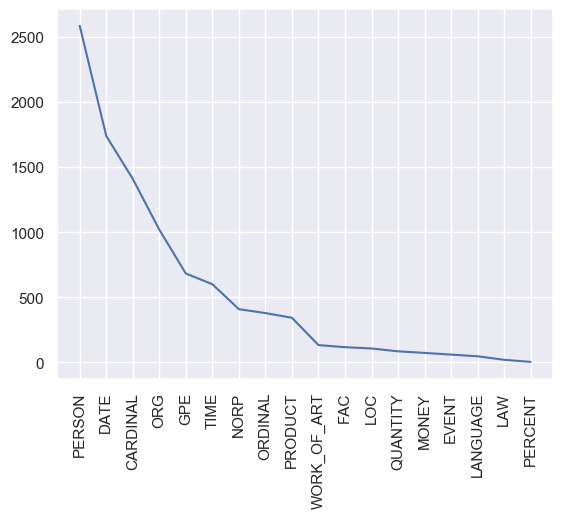

In [285]:
x = [tag for tag,v in sortedTags]
y = [v for tag,v in sortedTags]
plt.plot(x, y)
plt.xticks(rotation=90)
plt.show()

The entities tagged in this subset of the corpus include persons, date, cardinal and ordinal numerals, organizations, geopolitical entities, time, Nationalities or religious or political groups, products, works of art, facilities, location, quantity, money, event, language, law and percentages.

As we can see from the plot, the most common entity in this blog corpus are persons. This suggests that the authors of the blog tend to write about people and relationships in their life. They also write about dates fairly frequently. This is consistent with previous exploration that the blog content is mostly focused on day to day activities. Organizations, countries and time are also mentioned a fair bit while languages, percentage and the law referred to less in the content.

In [260]:
# Find Orgs
for entry in data_100['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind == 'ORG':
                print(ent)

urlLink http://rediff.com urlLink http://sify.com
BADLY
HEART
Taco Bell
lah
Cathay Cineleisure
doc
Bedok
Starbucks
the SCHOOL HOLIDAYS
Virgo
Singapore Press Holdings
Mercer Human Resource Consulting
Kelly Services
Social
Cosmoprof
SKF Logistics Services Asia
Psychiatrist Lionel Lim
NEVER
FEEL
Hahaha
LOVE
LOVE
ACTUALLY
HOLLYWOOD
NEAT
Gab
Community
FALCON
the united states army
FALCON
the united states army
FALCON
the united states army
BLOG
Friends
EA Sports
EA Sports
The Political Machine
SEINFELD
the Political Machine
First Novel
Quaker
Milo and Ottis Do
Aliens Versus Predators
Red Sox
Yankees
un
DAMN
OKAY
musian professional speller lumberjack(or
LOVE
WTF
PLEASE TELL ME
Vinicated Monkey
Papal
Divorce
DIVORCE
Mother 's Mom
DIVORCE
Church
greed Baptist
Mass. Perhaps
un
MTV
u'll
ppl
POS
Random Thought 1
hahaha
me(bass guitar
ProzakOk
R.I.P
u
HBO
PARTY
hahaha
hahaha
Luda
coke
G Ro
G
coke
Eminem Obie Trice
hahaha
Rage
mic
mic
Propha C
Propha C 's
propha c
Haters
u
RIP Thomas Mitchell
u
PF

In [261]:
# Find persons
for entry in data_100['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind == 'PERSON':
                print(ent)

thousand
awara hai
meri tanhai jaye
kaha jaye
meri tanhai yeh
chehre hai
koi bhi nahi
rahe bhi bhi
seene mein
dil
bajti hui shehnai
meri tanhai akash
chala gum hai
mein magar mere zakhmon
meri tanhai ---js R)mail addressrs(s
hols
Troy
Yea
brad
harry potter
Hogwarts Rowling
Kinokuniya
Kino
Jap mags
Ming Wei Colin
Rowena
Mum
Rowena
belle
jo
m gon na
johnny english
gon na
Avril Lavigne
Avril
Avril
Peter Lee
Martin Huang
Jane
Joe
Esther Chia
Ms Angie
Alick Chia
Susan Cheong
Huang
Cheong
Hahah
joe lah
Karin Ca
Skool
Lee Wendy Cindy
Wendy Loi
Harry Potter
Mean Girls
annabelle haha erm
Annabelle
Joel
Joel
Belle
Glenna
Listening
airborne
ROTC
airborne
ROTC
airborne
ROTC
thomas jefferson
Ahnould
Barbara Bush
Montana Colorodo
Fred Toppel
Hardhitter Barry King
Barbara Sawyer
Les Mis
Rick Santorum
Osama
Adolf Hitler
Osama Bin Laden
Albert Camus
Camus
Camus
Camus
Nazis
the Sissyphus Calligula
Camus
George Laura
Bush
Bush
Bush
Bill Clinton
Kerry
Rick Santorum John Kerry
George Bush
John Kerry
John K

In [262]:
#Countries, cities, states.
for entry in data_100['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind == 'GPE':
                print(ent)

armaan
u don
withou
Fullerton
Los Angeles
India
India
ROTC!Well
new york
Texas
South Carolina
Iraq
Kentucky
Washington
Mass.
kinda
Mass.
America
kinda
cirlce
outta
kinda
Toddy
O.E.
u ai
Wanna
moss
maurijuana
georgia
starin
North Carolina
Humboldt County
California
San Francisco
Barbeque
Trinidad
Humboldt
Gnomedex
Alabama
Vacation
Alabama
Alabama Arkansas
Chicago
Port Byron
IL
North Carolina
Nadia
north carolina
jean
Ganyan
Sa
Anyways
La Salle ULUL
ULUL
ko(Cardona
Tenorio
THIEFS
philadelphia
Vennia
Vennia
Vennia
Vennia
Vennia
Vennia
Vennia
Vennia
Vennia
Vennia
Vennia
Vennia
Dracnoria
Iran
Saudi Arabia USA
Yemen
Baltimore
Israel
UW
Seattle
Washington DC
New York
the urlLink Empire State
Chicago
Manhattan
Empire State
Hehe
Israel
Israel
Israel
Florida
Tampa
Lexington
Israel
New York
LA
Thailand
us
Texas
Miami
Tel Aviv
Tel Aviv
Israel
Israel
Israel
Israel
Seattle
Israel
Judaism
Idaho
Haifa
Shmulik
Israel
Idaho
Seattle
Israel
Seattle
MD DC
Chicagoland
Chicago
kinda
Washington
Taiwan
Washing

In [286]:
#Find events
for entry in data_100['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind == 'LAW':
                print(ent)

Noveber the 22nd
Constitutional Amendment
Gincea McNEELEA 45
Rhoda 18 F
Current Music Roxy Music
Current Music
Current Music U2
AvP 2
Constitution
Reed 17
Session Start
Session Start
the Sculpture Grad Student
Dope Show Flower
Law 4911
this TITLE Note
ard 6.05am
ard 6.15am
ard 12 1pm plus


## Precision, Recall, F-score

For a subset of your corpus, tally at least one type of named entity and calculate the Precision, Recall and F-score for the NER classification just performed.

In [290]:
data_100[:5]

text  \
4162441.male.16.Student.Sagittarius.xml  DESTINY...       you might not say anything   ...   
3364931.male.16.Student.Virgo.xml        Today was....normal. Nothing much to talk abou...   
3846432.male.16.Student.Leo.xml          Well it's another day and another morning, one...   
4157968.male.16.Student.Pisces.xml       As I strolled into the mall yesterday, gently ...   
2727849.female.26.Arts.Libra.xml         two weeks later I finally write to you about n...   

                                                                                   cleaned  \
4162441.male.16.Student.Sagittarius.xml  destiny...       you might not say anything   ...   
3364931.male.16.Student.Virgo.xml        today was....normal. nothing much to talk abou...   
3846432.male.16.Student.Leo.xml          well it's another day and another morning, one...   
4157968.male.16.Student.Pisces.xml       as i strolled into the mall yesterday, gently ...   
2727849.female.26.Arts.Libra.xml         two weeks later i finally write to you about n...   

                                                                            tokenized_text  \
4162441.male.16.Student.Sagittarius.xml  [destiny, you, might, not, say, anything, but,...   
3364931.male.16.Student.Virgo.xml        [today, was, normal, nothing, much, to, talk, ...   
3846432.male.16.Student.Leo.xml          [well, it, 's, another, day, and, another, mor...   
4157968.male.16.Student.Pisces.xml       [as, i, strolled, into, the, mall, yesterday, ...   
2727849.female.26.Arts.Libra.xml         [two, weeks, later, i, finally, write, to, you...   

                                         word_counts  \
4162441.male.16.Student.Sagittarius.xml         1107   
3364931.male.16.Student.Virgo.xml               4756   
3846432.male.16.Student.Leo.xml                 1475   
4157968.male.16.Student.Pisces.xml              2382   
2727849.female.26.Arts.Libra.xml                 560   

                                                                         normalized_tokens  \
4162441.male.16.Student.Sagittarius.xml  [destiny, hear, choose, life, partner, dear, d...   
3364931.male.16.Student.Virgo.xml        [today, normal, talk, get, mid, year, papers.i...   
3846432.male.16.Student.Leo.xml          [day, morning, hope, right, go, write, thing, ...   
4157968.male.16.Student.Pisces.xml       [stroll, mall, yesterday, gently, bypass, grou...   
2727849.female.26.Arts.Libra.xml         [week, later, finally, write, particular, writ...   

                                         normalized_tokens_count  \
4162441.male.16.Student.Sagittarius.xml                      528   
3364931.male.16.Student.Virgo.xml                           2062   
3846432.male.16.Student.Leo.xml                              503   
4157968.male.16.Student.Pisces.xml                          1034   
2727849.female.26.Arts.Libra.xml                             216   

                                                                     normalized_tokens_POS  \
4162441.male.16.Student.Sagittarius.xml  [(destiny, NN), (..., :), (      , _SP), (you,...   
3364931.male.16.Student.Virgo.xml        [(today, NN), (was, VBD), (...., .), (normal, ...   
3846432.male.16.Student.Leo.xml          [(well, UH), (it, PRP), ('s, VBZ), (another, D...   
4157968.male.16.Student.Pisces.xml       [(as, IN), (i, PRP), (strolled, VBD), (into, I...   
2727849.female.26.Arts.Libra.xml         [(two, CD), (weeks, NNS), (later, RB), (i, PRP...   

                                                                                 sentences  \
4162441.male.16.Student.Sagittarius.xml  [[DESTINY], [you, might, not, say, anything], ...   
3364931.male.16.Student.Virgo.xml        [[Today, was, normal], [Nothing, much, to, tal...   
3846432.male.16.Student.Leo.xml          [[Well, it, 's, another, day, and, another, mo...   
4157968.male.16.Student.Pisces.xml       [[As, I, strolled, into, the, mall, yesterday,...   
2727849.female.26.Arts.Libra.xml         [[tw

In [289]:
data_100[:5]['sentences'].sum()

[['DESTINY'],
 ['you', 'might', 'not', 'say', 'anything'],
 ['but', 'i', 'can', 'hear'],
 ['you', 'have', 'chosen', 'me', 'your', 'life', 'partner'],
 ['so', 'have'],
 ['i', 'dear'],
 ['so', 'have', 'i', 'dear'],
 ['my',
  'first',
  'dream',
  'my',
  'first',
  'extreme',
  'my',
  'first',
  'love',
  'i',
  'was',
  'waiting',
  'for',
  'my',
  'DESTINY'],
 ['what',
  'should',
  'i',
  'do',
  'with',
  'myself',
  'tell',
  'me',
  'o',
  'my',
  'heart'],
 ['what', 'should', 'i', 'do', 'with', 'myself', 'tell', 'me'],
 ['should', 'i', 'fly', 'with', 'this', 'beautiful', 'nature'],
 ['or', 'should', 'i', 'play', 'with', 'these', 'winds'],
 ['should',
  'i',
  'try',
  'to',
  'reach',
  'the',
  'skies',
  'or',
  'should',
  'i',
  'pray',
  'to',
  'the',
  'mother',
  'earth'],
 ['what', 'should', 'i', 'do', 'with', 'myself', 'friends', 'tell', 'me'],
 ['she',
  'talked',
  'in',
  'such',
  'a',
  'way',
  'gave',
  'me',
  'dreams',
  'with',
  'thousand',
  'colours'],
 ['

In [291]:
for entry in data_100[:5]['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind == 'GPE':
                print(ent)
# LA, India, India, new york, Texas, Montana, Colorodo, South Carolina, Iraq

armaan
u don
withou
Fullerton
Los Angeles
India
India
ROTC!Well
new york
Texas
South Carolina
Iraq


For the geopolitical entity identified, 7 out of 12 of them are actually countries, cities or states. In this subset of data analyzed, there is a total of 9 GPEs. Hence the precision is 7/12 = 58.3% and recall is 7/9 = 77.7%. We can also calculate the f-score to be 66.6%.

In [293]:
precision = 7/12
recall = 7/9
fscore = 2*(precision*recall)/(precision+recall)
print(precision, recall, fscore)

0.5833333333333334 0.7777777777777778 0.6666666666666666


## Dependency parsing and graph representations

Dependency parsing was developed to robustly capture linguistic dependencies from text. The complex tags associated with these parses are detailed [here]('http://universaldependencies.org/u/overview/syntax.html'). When parsing with the dependency parser, we will work directly from the untokenized text. Note that no *processing* takes place before parsing sentences--we do not remove so-called stop words or anything that plays a syntactic role in the sentence, although anaphora resolution and related normalization may be performed before or after parsing to enhance the value of information extraction. 

We will be using spaCy's built in dependancy parser to go about exploring the tree.
Note that unlike previous examples, large corpuses or collections of sentences don't give us as much information, so we will be navigating smaller sentences.

Let us start by exploring noun chunks. Noun chunks are “base noun phrases” – flat phrases that have a noun as their head. You can think of noun chunks as a noun plus the words describing the noun – for example, “the lavish green grass” or “the world’s largest tech fund”. To get the noun chunks in a document, simply iterate over the sentences noun chunks.

In [294]:
from spacy import displacy

In [295]:
doc = nlp("Autonomous cars shift insurance liability toward manufacturers")

In [297]:
displacy.render(doc, style='dep')

In [298]:
for chunk in doc.noun_chunks:
    print(chunk.text, chunk.root.text, chunk.root.dep_, chunk.root.head.text)

Autonomous cars cars nsubj shift
insurance liability liability dobj shift
manufacturers manufacturers pobj toward


spaCy uses the terms head and child to describe the words connected by a single arc in the dependency tree. The term dep is used for the arc label, which describes the type of syntactic relation that connects the child to the head. As with other attributes, the value of .dep is a hash value. You can get the string value with .dep_.

For your reference:

Text: The original token text.

Dep: The syntactic relation connecting child to head.

Head text: The original text of the token head.

Head POS: The part-of-speech tag of the token head.

Children: The immediate syntactic dependents of the token.

In [299]:
for token in doc:
    print(token.text, token.dep_, token.head.text, token.head.pos_,
            [child for child in token.children])

Autonomous amod cars NOUN []
cars nsubj shift VERB [Autonomous]
shift ROOT shift VERB [cars, liability]
insurance compound liability NOUN []
liability dobj shift VERB [insurance, toward]
toward prep liability NOUN [manufacturers]
manufacturers pobj toward ADP []


Because the syntactic relations form a tree, every word has exactly one head. You can therefore iterate over the arcs in the tree by iterating over the words in the sentence. This is usually the best way to match an arc of interest — from below:

In [300]:
from spacy.symbols import nsubj, VERB

In [301]:
verbs = set()
for possible_subject in doc:
    if possible_subject.dep == nsubj and possible_subject.head.pos == VERB:
        verbs.add(possible_subject.head)
print(verbs)

{shift}


You can *also* navigate from above. It isn't as efficient though.

In [302]:
verbs = []
for possible_verb in doc:
    if possible_verb.pos == VERB:
        for possible_subject in possible_verb.children:
            if possible_subject.dep == nsubj:
                verbs.append(possible_verb)
                break

In [303]:
print(verbs)

[shift]


### Iterating around the local tree
A few more convenience attributes are provided for iterating around the local tree from the token. Token.lefts and Token.rights attributes provide sequences of syntactic children that occur before and after the token. Both sequences are in sentence order. There are also two integer-typed attributes, Token.n_lefts and Token.n_rights that give the number of left and right children.

In [304]:
doc = nlp("bright red apples on the tree")
print([token.text for token in doc[2].lefts])  # ['bright', 'red']
print([token.text for token in doc[2].rights])  # ['on']
print(doc[2].n_lefts)  # 2
print(doc[2].n_rights)  # 1

['bright', 'red']
['on']
2
1


You can get a whole phrase by its syntactic head using the Token.subtree attribute. This returns an ordered sequence of tokens. You can walk up the tree with the Token.ancestors attribute, and check dominance with Token.is_ancestor

In [305]:
doc = nlp("Credit and mortgage account holders must submit their requests")

root = [token for token in doc if token.head == token][0]
subject = list(root.lefts)[0]
for descendant in subject.subtree:
    assert subject is descendant or subject.is_ancestor(descendant)
    print(descendant.text, descendant.dep_, descendant.n_lefts,
            descendant.n_rights,
            [ancestor.text for ancestor in descendant.ancestors])

Credit nmod 0 2 ['account', 'holders', 'submit']
and cc 0 0 ['Credit', 'account', 'holders', 'submit']
mortgage conj 0 0 ['Credit', 'account', 'holders', 'submit']
account compound 1 0 ['holders', 'submit']
holders nsubj 1 0 ['submit']


Finally, the .left_edge and .right_edge attributes can be especially useful, because they give you the first and last token of the subtree. This is the easiest way to create a Span object for a syntactic phrase. Note that .right_edge gives a token within the subtree — so if you use it as the end-point of a range, don’t forget to +1!

In [306]:
span = doc[doc[4].left_edge.i : doc[4].right_edge.i+1]
with doc.retokenize() as retokenizer:
    retokenizer.merge(span)
for token in doc:
    print(token.text, token.pos_, token.dep_, token.head.text)

Credit and mortgage account holders NOUN nsubj submit
must VERB aux submit
submit VERB ROOT submit
their DET poss requests
requests NOUN dobj submit


In [307]:
displacy.render(doc, style='dep')

### Information Extraction

How can dependancy graphs be useful? We can extract information from the sentences based on relationships between verbs. Let us see if we can do this to glean any information, from, say, our movies dataset. 

How violent are the movies? Who is killing who?

In [308]:
movie_violences = {}

In [309]:
for index, row in movie_df.iterrows():
    text = ' '.join(row['Tokenized Texts'])
    movie_violences[row['Movie Name']] = ([], [])
    doc = nlp(text)
    for chunk in doc.noun_chunks:
        subject = 0
        object_ = 0
        # if the verb or the root of the sentence is kill
        if chunk.root.head.text == 'kill':
            # we find the subjects and objects around the word, and if it does exist, add it to the tuple
            if chunk.root.dep_ == 'nsubj':
                subject = chunk.root.text
            if chunk.root.dep_ == 'dobj':
                object_ = chunk.root.text
            if subject is not 0:
                movie_violences[row['Movie Name']][0].append(subject)
            if object_ is not 0:
                movie_violences[row['Movie Name']][1].append(object_)

In [310]:
movie_violences

{'Animal Crackers': ([], []),
 'Anna Christie': (['I', 'I'], ['them', 'you', 'Glory', 'you']),
 'Ladies of Leisure': ([], []),
 'Over the Hill': ([], ['shalt', 'Ma']),
 'Design for Living': ([], []),
 'Lady for a Day': (['It'], ['yourself', 'Louise']),
 'Lady Killer': ([], ['horse']),
 'The Mind Reader': (['woman'], ['herself']),
 'Here Is My Heart': ([], ['herself']),
 'Peculiar Penguins': ([], []),
 'Sadie McKee': (['You', 'I'], ['SOBBING', 'you']),
 'Star of Midnight': (['you', 'I', 'They'],
  ['story', 'him', 'him', 'dal', 'her']),
 'The Littlest Rebel': (['men'], ['army']),
 'The Robber Kitten': ([], []),
 'Charlie Chan at the Circus': ([], []),
 'Charlie Chan at the Opera': (['I'], ['me', 'him', 'you', 'intrusion']),
 'Charlie Chan at the Race Track': (['shoe', 'you'], []),
 'The Prisoner of Shark Island': (['government'], ['what', 'husband']),
 'The Prince and the Pauper': ([], ['me']),
 'The Lady Vanishes': (['They'], ['lot']),
 'Holiday': ([], []),
 "Donald's Cousin Gus": ([],

That's pretty neat: we can see who tried to kill who, or at least talked about it. A lot of 'I' killing 'you', as we'd imagine. What else can we see?

The movie, about time, which is about time travel, funnily enough has:
`'About Time': (['I'], ['Hitler'])`

## <span style="color:red">*Your turn*</span>

<span style="color:red">In the cells immediately following, parse a (modest) subset of your corpus of interest. How deep are the phrase structure and dependency parse trees nested? How does parse depth relate to perceived sentence complexity? What are five things you can extract from these parses for subsequent analysis? (e.g., nouns collocated in a noun phrase; adjectives that modify a noun; etc.) Capture these sets of things for a focal set of words (e.g., "Bush", "Obama", "Trump"). What do they reveal about the roles that these entities are perceive to play in the social world inscribed by your texts?

In [338]:
data = data.reset_index().rename({'index':'author'}, axis=['columns'])
data[:5]

author  \
0  4162441.male.16.Student.Sagittarius.xml   
1        3364931.male.16.Student.Virgo.xml   
2          3846432.male.16.Student.Leo.xml   
3       4157968.male.16.Student.Pisces.xml   
4         2727849.female.26.Arts.Libra.xml   

                                                text  \
0  DESTINY...       you might not say anything   ...   
1  Today was....normal. Nothing much to talk abou...   
2  Well it's another day and another morning, one...   
3  As I strolled into the mall yesterday, gently ...   
4  two weeks later I finally write to you about n...   

                                             cleaned  \
0  destiny...       you might not say anything   ...   
1  today was....normal. nothing much to talk abou...   
2  well it's another day and another morning, one...   
3  as i strolled into the mall yesterday, gently ...   
4  two weeks later i finally write to you about n...   

                                      tokenized_text  word_counts  \
0  [destiny, you, might, not, say, anything, but,...         1107   
1  [today, was, normal, nothing, much, to, talk, ...         4756   
2  [well, it, 's, another, day, and, another, mor...         1475   
3  [as, i, strolled, into, the, mall, yesterday, ...         2382   
4  [two, weeks, later, i, finally, write, to, you...          560   

                                   normalized_tokens  normalized_tokens_count  \
0  [destiny, hear, choose, life, partner, dear, d...                      528   
1  [today, normal, talk, get, mid, year, papers.i...                     2062   
2  [day, morning, hope, right, go, write, thing, ...                      503   
3  [stroll, mall, yesterday, gently, bypass, grou...                     1034   
4  [week, later, finally, write, particular, writ...                      216   

                               normalized_tokens_POS  
0  [(destiny, NN), (..., :), (      , _SP), (you,...  
1  [(today, NN), (was, VBD), (...., .), (normal, ...  
2  [(well, UH), (it, PRP), ('s, VBZ), (another, D...  
3  [(as, IN), (i, PRP), (strolled, VBD), (into, I...  
4  [(two, CD), (weeks, NNS), (later, RB), (i, PRP...

In [320]:
sentence = data_100['text']['3846432.male.16.Student.Leo.xml'][:83]
sentence

"Well it's another day and another morning, one I hope will become more than it is. "

In [321]:
doc = nlp(sentence)

In [322]:
displacy.render(doc, style='dep')

In [323]:
for chunk in doc.noun_chunks:
    print(chunk.text, chunk.root.text, chunk.root.dep_, chunk.root.head.text)

it it nsubj 's
another day day attr 's
another morning morning conj day
I I nsubj hope
it it nsubj is


In [324]:
for token in doc:
    print(token.text, token.dep_, token.head.text, token.head.pos_,
            [child for child in token.children])

Well intj 's AUX []
it nsubj 's AUX []
's ROOT 's AUX [Well, it, day, ,, one, .]
another det day NOUN []
day attr 's AUX [another, and, morning]
and cc day NOUN []
another det morning NOUN []
morning conj day NOUN [another]
, punct 's AUX []
one npadvmod 's AUX [hope]
I nsubj hope VERB []
hope relcl one NOUN [I, become]
will aux become VERB []
become ccomp hope VERB [will, more]
more acomp become VERB [is]
than mark is AUX []
it nsubj is AUX []
is advcl more ADJ [than, it]
. punct 's AUX []


In [330]:
sentence = data_100['text']['4157968.male.16.Student.Pisces.xml']
sentence

'As I strolled into the mall yesterday, gently bypassing the group of about 10 8th grade (well now freshmen) girls who were congregating in front of the Electronics boutique, I had a certain glimmer in my eye - Madden \'05 had just come out, and I was about to purchase it. However, to my dismay, the stiffs at EA Sports dellayed the release of the computer version of the popular video game until September 9th. I was nearly in tears... What game was I going to play when I got back to my house? I went to J-crew to try and think things off, and got a nice tie there (althought it wasn\'t the one I wanted) and my short term memory sudenly kicked in. I remembered that just a few hours earlier I had a red an article about this computer game about political campaigning. It had seemed hilarious, with the capabilities of pitting thomas jefferson against  the "guvanator" I laughed whole heartedly. Naturally at this point I felt the distinct need to buy it. I rushed back to EB, past the pack of gig

In [331]:
doc = nlp(sentence)

In [332]:
displacy.render(doc, style='dep')

In [333]:
for chunk in doc.noun_chunks:
    print(chunk.text, chunk.root.text, chunk.root.dep_, chunk.root.head.text)

I I nsubj strolled
the mall mall pobj into
the group group dobj bypassing
about 10 8th grade grade pobj of
well now freshmen freshmen appos grade
girls girls appos grade
who who nsubj congregating
front front pobj in
the Electronics boutique boutique pobj of
I I nsubj had
a certain glimmer glimmer dobj had
my eye - Madden Madden pobj in
I I nsubj was
it it dobj purchase
my dismay dismay pobj to
the stiffs stiffs nsubj dellayed
EA Sports Sports pobj at
the release release dobj dellayed
the computer version version pobj of
the popular video game game pobj of
September 9th 9th pobj until
I I nsubj was
tears tears pobj in
What game game dobj play
I I nsubj going
I I nsubj got
my house house pobj to
I I nsubj went
J-crew crew pobj to
things things dobj think
a nice tie tie dobj got
it it nsubj was
the one one attr was
I I nsubj wanted
my short term memory memory nsubj kicked
I I nsubj remembered
I I nsubj had
a red an article article dobj had
this computer game game pobj about
political cam

In [334]:
for token in doc:
    print(token.text, token.dep_, token.head.text, token.head.pos_,
            [child for child in token.children])

As mark strolled VERB []
I nsubj strolled VERB []
strolled advcl had AUX [As, I, into, yesterday, ,, bypassing]
into prep strolled VERB [mall]
the det mall NOUN []
mall pobj into ADP [the]
yesterday npadvmod strolled VERB []
, punct strolled VERB []
gently advmod bypassing VERB []
bypassing advcl strolled VERB [gently, group]
the det group NOUN []
group dobj bypassing VERB [the, of]
of prep group NOUN [grade]
about advmod 10 NUM []
10 nummod grade NOUN [about]
8th amod grade NOUN []
grade pobj of ADP [10, 8th, (, freshmen, girls]
( punct grade NOUN []
well intj freshmen NOUN []
now advmod freshmen NOUN []
freshmen appos grade NOUN [well, now, )]
) punct freshmen NOUN []
girls appos grade NOUN [congregating]
who nsubj congregating VERB []
were aux congregating VERB []
congregating relcl girls NOUN [who, were, in]
in prep congregating VERB [front]
front pobj in ADP [of]
of prep front NOUN [boutique]
the det boutique NOUN []
Electronics compound boutique NOUN []
boutique pobj of ADP [the,

been aux sitting VERB []
sitting ccomp supose VERB [I, 've, been, here, for, try]
here advmod sitting VERB []
for prep sitting VERB [minutes]
about advmod three NUM []
three nummod minutes NOUN [about]
minutes pobj for ADP [three]
to aux try VERB []
try advcl sitting VERB [to, and, come]
and cc try VERB []
come conj try VERB [up, with]
up prt come VERB []
with prep come VERB [line]
a det line NOUN []
second amod line NOUN []
line pobj with ADP [a, second]
; punct supose VERB []
so advmod supose VERB []
I nsubj supose VERB []
supose conj tell VERB [sitting, ;, so, I, move, ..., Back, ,, for]
I nsubj move VERB []
shall aux move VERB []
just advmod move VERB []
move ccomp supose VERB [I, shall, just, on]
on prep move VERB []
... punct supose VERB [     ]
       ... PUNCT []
Back advmod supose VERB [to]
to prep Back ADV [Machine]
the det Machine PROPN []
Political amod Machine PROPN []
Machine pobj to ADP [the, Political]
, punct supose VERB []
for prep supose VERB [those]
those pobj for A

frankly advmod shocks VERB [quite]
shocks relcl resignation NOUN [which, frankly, me]
me dobj shocks VERB []
, punct is AUX []
is ROOT is AUX [thing, ,, survive, .]
that mark survive VERB []
15 nummod % NOUN []
% nsubj survive VERB [15, of]
of prep % NOUN [mariages]
mariages pobj of ADP []
survive ccomp is AUX [that, %, partner, admiting]
one nummod partner NOUN []
partner dobj survive VERB [one]
admiting npadvmod survive VERB ['re]
that mark 're AUX []
they nsubj 're AUX []
're ccomp admiting VERB [that, they, gay]
gay acomp 're AUX []
. punct is AUX []
15 nummod % NOUN []
% nsubj end VERB [15, of]
of prep % NOUN [maigiages]
maigiages pobj of ADP []
do aux end VERB []
not neg end VERB []
end ROOT end VERB [%, do, not, as, ....]
as prep end VERB [result]
a det result NOUN []
result pobj as SCONJ [a, of]
of prep result NOUN [partner]
one nummod partner NOUN []
partner pobj of ADP [one, coming]
coming acl partner NOUN [out]
out prep coming VERB [of]
of prep out SCONJ [closet]
the det clo

the det one NOUN []
2nd amod one NOUN []
one appos Aliens NOUN [the, 2nd, with]
with prep one NOUN [marines]
the det marines PROPN []
marines pobj with ADP [the, in]
in prep marines PROPN [it]
it pobj in ADP []
) punct movie NOUN []
. punct movie NOUN []
What det movie NOUN []
a det movie NOUN []
cool amod movie NOUN []
movie ROOT movie NOUN [What, a, cool, .]
. punct movie NOUN []
I nsubj mean VERB []
mean parataxis come VERB [I]
, punct come VERB []
come ROOT come VERB [mean, ,, on, ,, Aliens]
on prt come VERB []
, punct come VERB []
Aliens npadvmod come VERB [,, marines, guns]
, punct Aliens PROPN []
marines conj Aliens PROPN [,, cool]
, punct marines PROPN []
cool conj marines PROPN [,]
, punct cool ADJ []
space compound guns NOUN []
age compound guns NOUN []
guns appos Aliens PROPN [space, age]
, punct be AUX []
what nsubj be AUX []
could aux be AUX []
be ROOT be AUX [,, what, could, better, ?]
better acomp be AUX []
? punct be AUX []
I nsubj remember VERB []
remember ROOT remembe

gained ccomp question VERB [whether, little, would, be, from]
from prep gained VERB [endeaveur]
this det endeaveur NOUN []
endeaveur pobj from ADP [this]
. punct question VERB []
Kerry nsubj promises VERB []
promises ROOT promises VERB [Kerry, future, ,, but, is, ...]
a det future NOUN []
brighter amod future NOUN []
future dobj promises VERB [a, brighter]
, punct promises VERB []
but cc promises VERB []
what dobj wants VERB []
he nsubj wants VERB []
really advmod wants VERB []
wants csubj is AUX [what, he, really]
is conj promises VERB [wants, house]
a det house NOUN []
brighter amod coloured ADJ []
- punct coloured ADJ []
coloured amod house NOUN [brighter, -]
house attr is AUX [a, coloured]
... punct promises VERB []


How deep are the phrase structure and dependency parse trees nested? How does parse depth relate to perceived sentence complexity? What are five things you can extract from these parses for subsequent analysis? (e.g., nouns collocated in a noun phrase; adjectives that modify a noun; etc.) Capture these sets of things for a focal set of words (e.g., "Bush", "Obama", "Trump"). What do they reveal about the roles that these entities are perceive to play in the social world inscribed by your texts?

In [359]:
need = {}
for index, row in data.iterrows():
    text = ' '.join(row['tokenized_text'])
    need[row['author']] = ([], [])
    doc = nlp(text)
    for chunk in doc.noun_chunks:
        subject = 0
        object_ = 0
        # if the verb or the root of the sentence is need
        if chunk.root.head.text == 'need':
            # we find the subjects and objects around the word, and if it does exist, add it to the tuple
            if chunk.root.dep_ == 'nsubj':
                subject = chunk.text
            if chunk.root.dep_ == 'dobj':
                object_ = chunk.text
            if subject is not 0:
                need[row['author']][0].append(subject)
            if object_ is not 0:
                need[row['author']][1].append(object_)

In [360]:
need

{'4162441.male.16.Student.Sagittarius.xml': ([], []),
 '3364931.male.16.Student.Virgo.xml': (['i', 'i'], []),
 '3846432.male.16.Student.Leo.xml': ([], []),
 '4157968.male.16.Student.Pisces.xml': (['they',
   'we',
   'purple hearts americans'],
  ['a constitutional amendment']),
 '2727849.female.26.Arts.Libra.xml': ([], []),
 '3865169.female.15.indUnk.Aries.xml': (['i', 'you', 'a guy', 'u', 'they'],
  []),
 '4310425.female.27.indUnk.Aries.xml': ([], []),
 '4186320.male.16.indUnk.Pisces.xml': (['u',
   'you',
   'u',
   'a nigga',
   'i',
   'all my music',
   'i',
   'i',
   'i',
   'i',
   'i',
   'you'],
  ['what', 'this rappin', 'one or two more verses']),
 '2318045.male.25.indUnk.Pisces.xml': ([], []),
 '827534.female.33.indUnk.Sagittarius.xml': ([], []),
 '3315654.female.23.Student.Leo.xml': ([], []),
 '4087466.male.16.Student.Gemini.xml': ([], []),
 '3469096.female.16.indUnk.Aquarius.xml': (["i 'm",
   'i',
   'i',
   'i',
   'you people'],
  []),
 '3726642.female.14.Student.Leo.

Interestingly, examining what people say with regards to the subject and object of 'need' is mostly either about life, relationships or politics. More than one author captured the idea of americans needing a constitutional amendment, need votes, need better and cheaper daycare options options, need support and needing a president. Occassionally, bloggers talked about needing vacation or a break. They also need strength, money and time. Many also talk about needing someone else, sometimes vaguely as you or man.

In [357]:
# Identify Roots of each sentence to summarize blog corpus content
roots = {}

for index, row in data.iterrows():
    text = ' '.join(row['tokenized_text'])
    roots[row['author']] = []
    doc = nlp(text)
    for chunk in doc.noun_chunks:
        subject = 0
        object_ = 0
        if chunk.root.dep_ == 'ROOT':
            roots[row['author']].append(chunk.text)

In [358]:
roots

{'4162441.male.16.Student.Sagittarius.xml': ['my first extreme',
  'my first extreme',
  'my first love',
  '--nildear angel',
  'inj',
  'amd miles life',
  'dear angel',
  '--nilmain',
  'tanhai jagjeet',
  'singh awara hai galiyon mein',
  'tanhai jaye',
  'hum',
  'har mod pe ruswaii',
  'chehre hai',
  'haste',
  'hue guldaste',
  'koi bhi nahi',
  'apna begane',
  'hue sab raste',
  'tanhai armaan sulagte',
  'hain seene mein',
  'hai mere',
  'dil par',
  'bajti hui shehnai main aur meri tanhai akash',
  'ke maathe',
  'taaron ka chala gum hai pehlu',
  'mein magar mere zakhmon',
  'ka gulistan',
  'hain aankhon',
  'ka daaman mein',
  'bahar aayi',
  'tanhai',
  'addressrs(s',
  'urllink',
  'was pleasure'],
 '3364931.male.16.Student.Virgo.xml': ['so no complaints',
  'my whole june holidays',
  'what a life',
  'we',
  'what',
  'lah peace',
  'out.hey people',
  'what an experience',
  '75%hey bloggers',
  'and so i m limping everytime',
  'what a life',
  'my poor mum hope',

Finding the roots as a summary worked for some bloggers but not for others. Some of the root did help to summarize sentence topics such as 'the american presidency', 'my whole jun holidays', 'no complains'. But many of the sentences had roots that did not make sense on their own and did not serve as a good summary of the sentence content.

# Distributional distances

If we want to compare different corpora, we need a distance or divergence that compares the two distributions.

We will use the: 

+ Kullback-Leibler (KL) divergence
+ $\chi^2$ divergence
+ Kolmogorov-Smirnov (KS) distance
+ Wasserstein distance

### Kullback-Leibler and $x^2$ divergences ###

KL and $\chi^2$ divergences are members of the broader <a "href=https://en.wikipedia.org/wiki/F-divergence" target="_blank">$f$-divergence</a> family, a function of $D_f (P || Q)$ that calculates the difference between two probability distributions P and Q. The KL $f(t)$ is $ t \text{ log } t $, while the $\chi^2$ is $t^2-1$. KL comes from information and $\chi^2$ from measure theory. As such, the KL divergence computes the relative entropy between two distributions--how they differ in bits, while the $\chi^2$ whether the same statistical inferences can be drawn from them both.  

Specifically, given two discrete probability distributions $P$ and $Q$, the Kullback-Leibler divergence from $Q$ to $P$ is defined as:

$D_{\mathrm{KL}}(P\|Q) = \sum_i P(i) \, \log\frac{P(i)}{Q(i)}$.

The [scipy.stats.entropy()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.entropy.html) function does the calculation for you, which takes in two arrays of probabilities and computes the KL divergence. Note that the KL divergence is in general not commutative, i.e. $D_{\mathrm{KL}}(P\|Q) \neq D_{\mathrm{KL}}(Q\|P)$ .

Also note that the KL divernce is the sum of elementwise divergences. Scipy provides [scipy.special.kl_div()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.kl_div.html#scipy-special-kl-div) which calculates elementwise divergences for you.

The $\chi^2$ Divergence is defined as:

$D_{\mathrm{\chi^2}}(P\|Q) = \sum_i \left(\frac{P(i)}{Q(i)}-1\right)^2$. 

This is also noncommutative, and the code can be drawn directly from scipy.

### Kolmogorov-Smirnov ###

The two-sample Kolmogovorov-Smirnov test statistic calculates the distance between the cumulative distribution function of the two distributions to be compared, and, along with the $x^2$ divergence, is among the most common approaches two calculating a distance in statistics. It can be interpreted as a test of whether two distributions are drawn from the same underlying distribution. As with the others, the code is readily available in scipy.

### Wasserstein Distance ###

When this is computed on a Euclidian metric structure (e.g., numbers of words), this is also known as the earth mover’s distance, because it can be seen as the minimum amount of "work" required to transform $P$ into $Q$, where "work" is measured as the amount of distribution weight that must be moved, multiplied by the distance it has to be moved.

### Computing ###

To do this we will need to create the arrays, lets compare the Whitehouse releases with the Kennedy releases. First we have to download them and load them into a DataFrame.

In [363]:
kenReleases = getGithubFiles('https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Kennedy', maxFiles = 10)
kenReleases[:5]

name                                               text  \
0  01Apr2005Kennedy14.txt           FOR IMMEDIATE RELEASE   FOR IMMEDIATE...   
1  01Aug2005Kennedy12.txt           FOR IMMEDIATE RELEASE   FOR IMMEDIATE...   
2  01Aug2006Kennedy10.txt           FOR IMMEDIATE RELEASE  FOR IMMEDIATE ...   
3  01Aug2006Kennedy11.txt           FOR IMMEDIATE RELEASE  FOR IMMEDIATE ...   
4  01Aug2006Kennedy12.txt           FOR IMMEDIATE RELEASE  FOR IMMEDIATE ...   

                                 path  \
0  raw/Kennedy/01Apr2005Kennedy14.txt   
1  raw/Kennedy/01Aug2005Kennedy12.txt   
2  raw/Kennedy/01Aug2006Kennedy10.txt   
3  raw/Kennedy/01Aug2006Kennedy11.txt   
4  raw/Kennedy/01Aug2006Kennedy12.txt   

                                            html_url  \
0  https://github.com/lintool/GrimmerSenatePressR...   
1  https://github.com/lintool/GrimmerSenatePressR...   
2  https://github.com/lintool/GrimmerSenatePressR...   
3  https://github.com/lintool/GrimmerSenatePressR...   
4  https://github.com/lintool/GrimmerSenatePressR...   

                                        download_url  
0  https://raw.githubusercontent.com/lintool/Grim...  
1  https://raw.githubusercontent.com/lintool/Grim...  
2  https://raw.githubusercontent.com/lintool/Grim...  
3  https://raw.githubusercontent.com/lintool/Grim...  
4  https://raw.githubusercontent.com/lintool/Grim...

Then we can tokenize, stem and remove stop words, like we did for the Whitehouse press releases

In [364]:
kenReleases['tokenized_text'] = kenReleases['text'].apply(lambda x: word_tokenize(x))
kenReleases['normalized_tokens'] = kenReleases['tokenized_text'].apply(lambda x: normalizeTokens(x))

Now we need to compare the two collection of words, remove those not found in both, and assign the remaining ones indices.

In [365]:
whWords = set(whReleases['normalized_tokens'].sum())
kenWords = set(kenReleases['normalized_tokens'].sum())

#Change & to | if you want to keep all words
overlapWords = whWords & kenWords

overlapWordsDict = {word: index for index, word in enumerate(overlapWords)}
overlapWordsDict['student']

190

Now we can count the occurrences of each word in the corpora and create our arrays. Note that we don't have to use numpy arrays as we do here. We could just use a list, but the arrays are faster in numpy so we encourage you to get in the habit of using them.

In [366]:
def makeProbsArray(dfColumn, overlapDict):
    words = dfColumn.sum()
    countList = [0] * len(overlapDict)
    for word in words:
        try:
            countList[overlapDict[word]] += 1
        except KeyError:
            #The word is not common so we skip it
            pass
    countArray = np.array(countList)
    return countArray / countArray.sum()

whProbArray = makeProbsArray(whReleases['normalized_tokens'], overlapWordsDict)
kenProbArray = makeProbsArray(kenReleases['normalized_tokens'], overlapWordsDict)
kenProbArray.sum()
#There is a little bit of a floating point math error
#but it's too small to see with print and too small matter here

1.0

We can now compute the KL divergence. Pay attention to the asymmetry. Use [the Jensen–Shannon divergence](https://en.wikipedia.org/wiki/Jensen%E2%80%93Shannon_divergence), which is the average KL divergence between each distribution and the average of both distributions (i.e., the midpoint), if you want symmetry.

In [367]:
wh_kenDivergence = scipy.stats.entropy(whProbArray, kenProbArray)
print (wh_kenDivergence)
ken_whDivergence = scipy.stats.entropy(kenProbArray, whProbArray)
print (ken_whDivergence)

0.632804454460187
0.5784905983449495


Then, we can do the elementwise calculation and see which words best distinguish the two corpora.

In [368]:
wh_kenDivergence_ew = scipy.special.kl_div(whProbArray, kenProbArray)
kl_df = pandas.DataFrame(list(overlapWordsDict.keys()), columns = ['word'], index = list(overlapWordsDict.values()))
kl_df = kl_df.sort_index()
kl_df['elementwise divergence'] = wh_kenDivergence_ew
kl_df[:10]

word  elementwise divergence
0       expand                0.002129
1        favor                0.000073
2  requirement                0.000392
3  restriction                0.004979
4  significant                0.000695
5    reiterate                0.000055
6         work                0.002021
7         york                0.000055
8     prepared                0.000055
9        floor                0.000818

In [369]:
kl_df.sort_values(by='elementwise divergence', ascending=False)[:10]

word  elementwise divergence
83         iraq                0.094839
226        bush                0.048099
141    american                0.025871
129        stem                0.023705
256         law                0.022781
177  department                0.019537
114      member                0.013240
66          war                0.012655
118     program                0.011213
77      country                0.010187

Now we will apply what we learned today 
First, let's transform every text into normalized tokens. Note that in this first step, no stopword is removed.
We'll use only the first 11 movies: you are welcome to try more.

In [370]:
corpora = []
for index, row in movie_df.iterrows():
    if len(corpora) > 10:
        break
    corpora.append(row['Tokenized Texts'])

Then, let's separate the normalized tokens into stopwords and non-stopwords.

In [371]:
corpora_s = []
corpora_nons = []
for corpus in corpora:
    s = []
    nons = []
    doc = nlp(' '.join(corpus))
    for word in doc:
        if word.is_stop:
            s.append(word.text)
        else:
            nons.append(word.text)
    corpora_s.append(s)
    corpora_nons.append(nons)

Define some covenient funtions for calculating divergence and distances.

In [372]:
def kl_divergence(X, Y):
    P = X.copy()
    Q = Y.copy()
    P.columns = ['P']
    Q.columns = ['Q']
    df = Q.join(P).fillna(0)
    p = df.iloc[:,1]
    q = df.iloc[:,0]
    D_kl = scipy.stats.entropy(p, q)
    return D_kl

def chi2_divergence(X,Y):
    P = X.copy()
    Q = Y.copy()
    P.columns = ['P']
    Q.columns = ['Q']
    df = Q.join(P).fillna(0)
    p = df.iloc[:,1]
    q = df.iloc[:,0]
    return scipy.stats.chisquare(p, q).statistic

def Divergence(corpus1, corpus2, difference="KL"):
    """Difference parameter can equal KL, Chi2, or Wass"""
    freqP = nltk.FreqDist(corpus1)
    P = pandas.DataFrame(list(freqP.values()), columns = ['frequency'], index = list(freqP.keys()))
    freqQ = nltk.FreqDist(corpus2)
    Q = pandas.DataFrame(list(freqQ.values()), columns = ['frequency'], index = list(freqQ.keys()))
    if difference == "KL":
        return kl_divergence(P, Q)
    elif difference == "Chi2":
        return chi2_divergence(P, Q)
    elif difference == "KS":
        try:
            return scipy.stats.ks_2samp(P['frequency'], Q['frequency']).statistic
        except:
            return scipy.stats.ks_2samp(P['frequency'], Q['frequency'])
    elif difference == "Wasserstein":
        try:
            return scipy.stats.wasserstein_distance(P['frequency'], Q['frequency'], u_weights=None, v_weights=None).statistic
        except:
            return scipy.stats.wasserstein_distance(P['frequency'], Q['frequency'], u_weights=None, v_weights=None)

Now we will calculate the KL divergence for each pair of corpora, turn the results into a matrix, and visualize the matrix as a heatmap. Recall that $D_{\mathrm{KL}}(P\|Q)$ measures the amount of information loss when $Q$ is used to approximate $P$. Here, the rows are the $P$s used for calculating KL divergences, and the columns are the $Q$s. So, each cell measures the amount of information loss when the word distribution of the column text is used to approximate the word distribution of the row text. Because the KL divergence is directional, such that the divergence of $P$ from $Q$ is different from the same of $Q$ from $P$, the matrix is assymetric and contains unique information above and below the diagonal. The same is true for the $\chi^2$ divergence.

In [373]:
len(corpora)

11

In [374]:
fileids = list(movie_df['Movie Name'])[0:11]

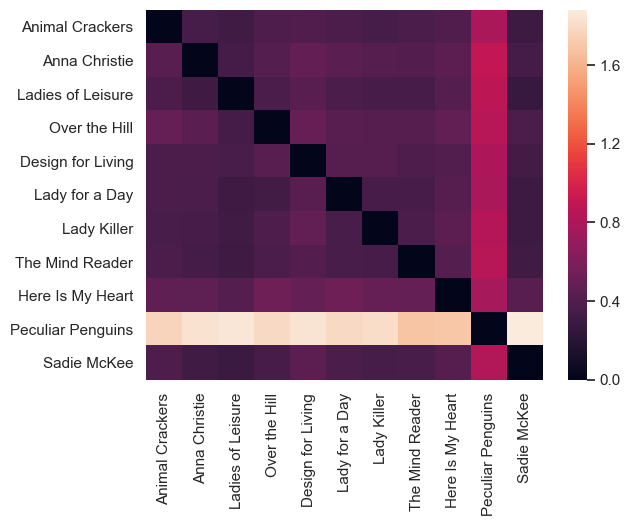

In [375]:
L = []
for p in corpora:
    l = []
    for q in corpora:
        l.append(Divergence(p,q, difference = 'KL'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()


To reveal more patterns, let's do a multidimensional scaling of the matrix.

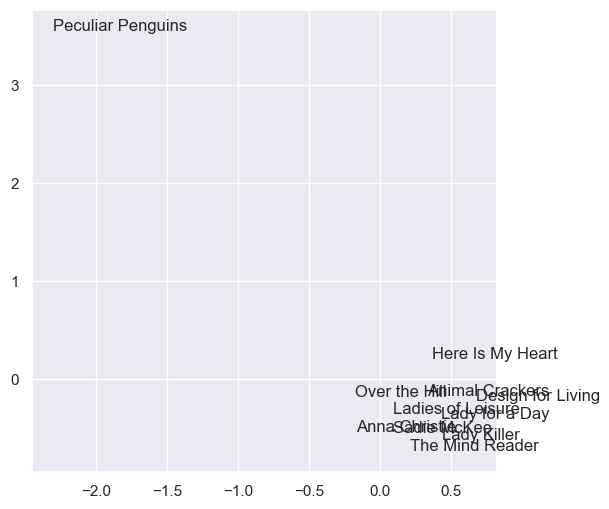

In [376]:
mds = sklearn.manifold.MDS()
pos = mds.fit(M).embedding_
x = pos[:,0]
y = pos[:,1]
fig, ax = plt.subplots(figsize = (6,6))
plt.plot(x, y, ' ')
for i, txt in enumerate(fileids):
    ax.annotate(txt, (x[i],y[i]))

A co-respondent's course and The Chain Gang are away from the others - any guesses why?

We may just want to focus on the distrbution of stopwords or non-stopwords. Let's do the analysis again first for stopwords and then for non-stopwords.

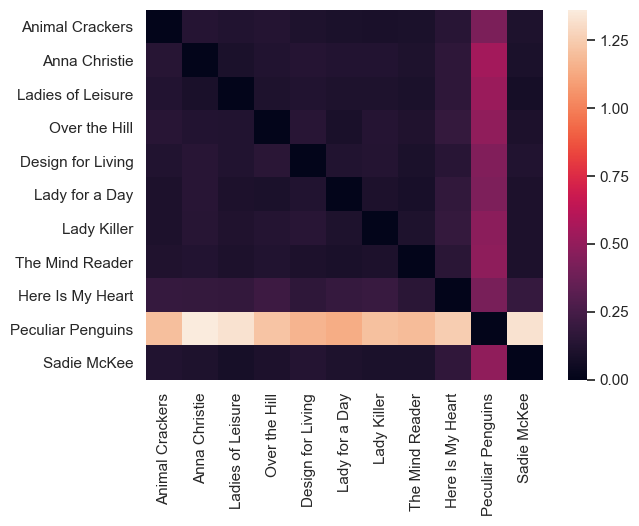

In [377]:
L = []
for p in corpora_s:
    l = []
    for q in corpora_s:
        l.append(Divergence(p,q, difference='KL'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

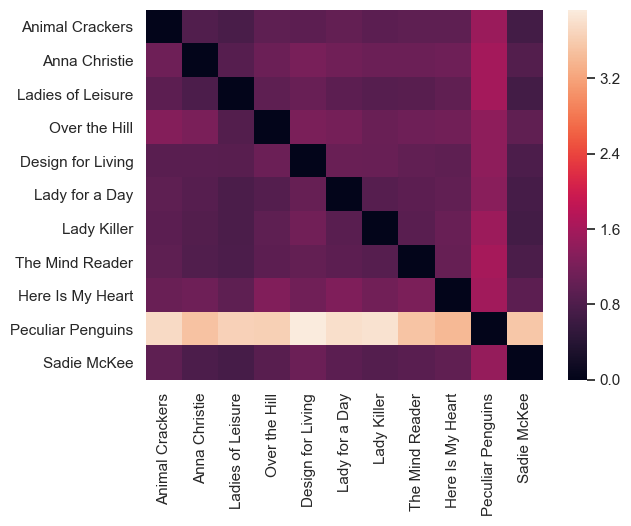

In [378]:
L = []
for p in corpora_nons:
    l = []
    for q in corpora_nons:
        l.append(Divergence(p,q, difference='KL'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

Now we compute the same for the assymmetric $\chi^2$ Divergence.

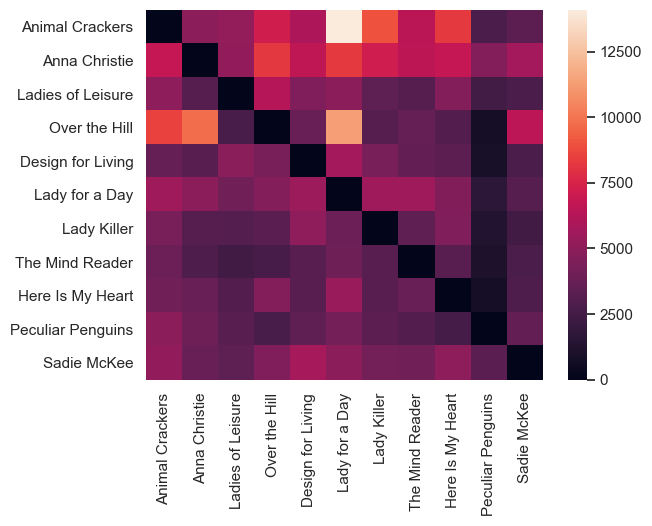

In [379]:
L = []
for p in corpora_nons:
    l = []
    for q in corpora_nons:
        l.append(Divergence(p,q, difference='Chi2'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

For the KS distance:

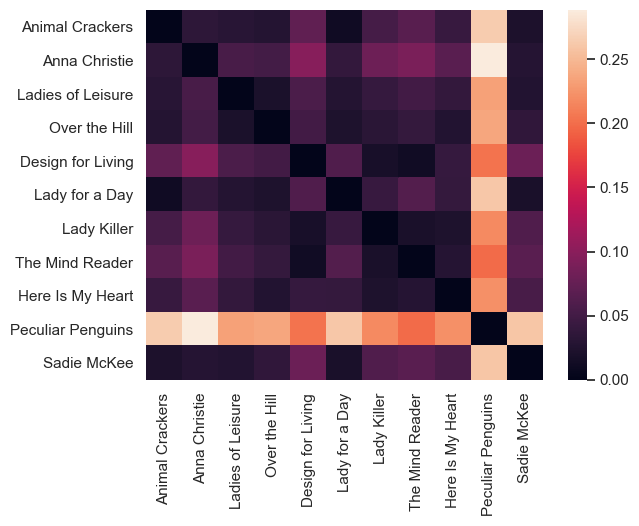

In [380]:
L = []
for p in corpora_nons:
    l = []
    for q in corpora_nons:
        l.append(Divergence(p,q, difference='KS'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

And finally for the Wasserstein or "earth mover's" Distance.

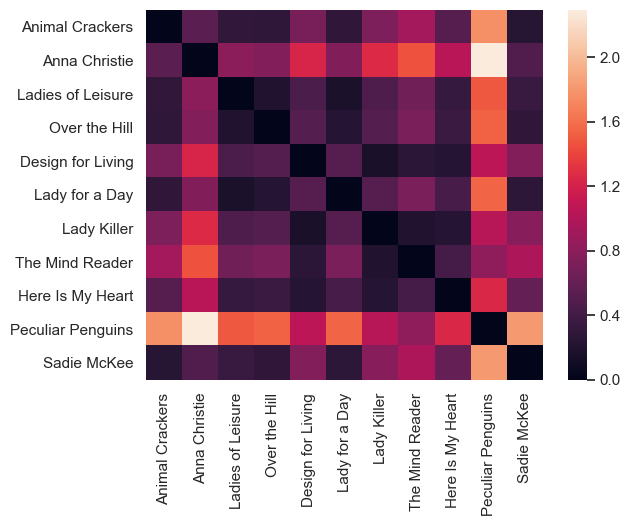

In [381]:
L = []
for p in corpora_nons:
    l = []
    for q in corpora_nons:
        l.append(Divergence(p,q, difference='Wasserstein'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

You can see that decade X is highly divergent and this makes reading the plot somewhat difficult. Let's fix this by taking the log of each cell, which will reduce the distance of decode X from other texts as an outlier.

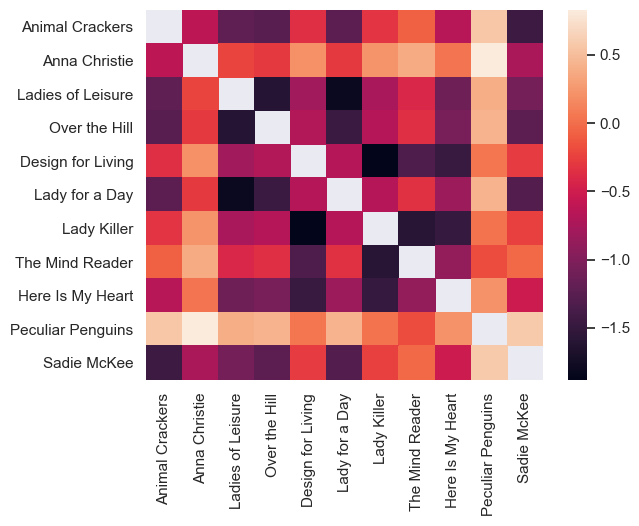

In [382]:
ax = sns.heatmap(div.apply(np.log).replace([np.inf, -np.inf], np.nan))
plt.show()

We only tried 11 movies, and from the same time period, so our signals might not be too interesting. What about different time periods?

An interesting experiment to maybe get some clearer signals: documents by decade in the Davies Corpus Of Historial American English (COHA) and see if we can detect patterns between them. 

If we want to rerun this on a new data set of our own composition, we can be a bit more efficient with our coding. Let's use the Shakespeare texts from last week as example: 

In [383]:
shakespeare_df = lucem_illud_2020.loadTextDirectory('../data/Shakespeare')

Now we stem and remove stopwords

In [384]:
shakespeare_df['tokenized_text'] = shakespeare_df['text'].apply(lambda x: word_tokenize(x))
shakespeare_df['normalized_tokens'] = shakespeare_df['tokenized_text'].apply(lambda x: normalizeTokens(x))

In [386]:
shakespeare_df[:5]

text  \
julius_caesar.txt           Dramatis Personae\n\n  JULIUS CAESAR, Roman st...   
as_you_like_it.txt          AS YOU LIKE IT\n\nby William Shakespeare\n\n\n...   
tempest.txt                 The Tempest\n\nActus primus, Scena prima.\n\nA...   
phoenix_and_the_turtle.txt  THE PHOENIX AND THE TURTLE\n\nby William Shake...   
king_lear.txt               The Tragedie of King Lear\n\n\nActus Primus. S...   

                                                               tokenized_text  \
julius_caesar.txt           [Dramatis, Personae, JULIUS, CAESAR, Roman, st...   
as_you_like_it.txt          [AS, YOU, LIKE, IT, by, William, Shakespeare, ...   
tempest.txt                 [The, Tempest, Actus, primus, Scena, prima, A,...   
phoenix_and_the_turtle.txt  [THE, PHOENIX, AND, THE, TURTLE, by, William, ...   
king_lear.txt               [The, Tragedie, of, King, Lear, Actus, Primus,...   

                                                            normalized_tokens  
julius_caesar.txt           [dramatis, personae, julius, caesar, roman, st...  
as_you_like_it.txt          [like, william, shakespeare, dramatis, persona...  
tempest.txt                 [temp, actus, primus, scena, prima, tempestuou...  
phoenix_and_the_turtle.txt  [phoenix, turtle, william, shakespeare, let, b...  
king_lear.txt               [tragedie, king, lear, actus, primus, scoena, ...

Create the corpus file and generate the heatmap:

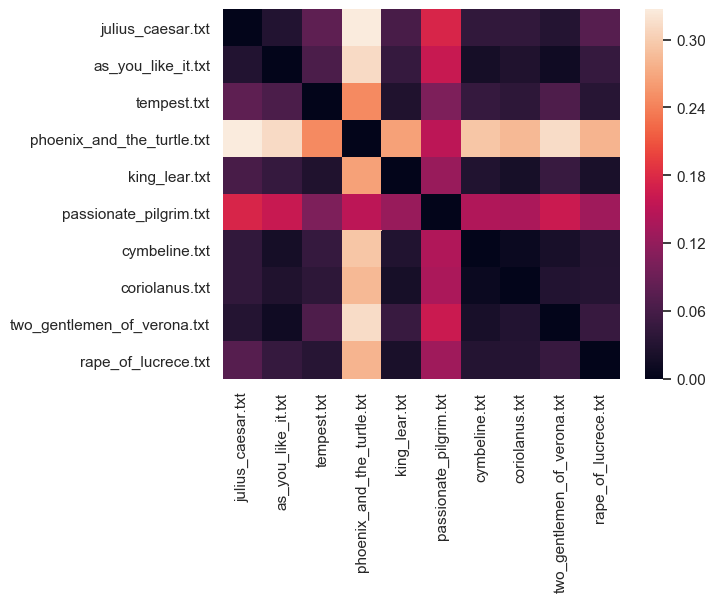

In [385]:
measure = 'KS' #"KL", "Chi2", "KS", "Wasserstein"
num_of_texts = 10 #The bigger this number the slower it will run, you can also try selecting your own plays
fileids_sp = list(shakespeare_df[:num_of_texts].index)
corpora_sp = list(shakespeare_df[:num_of_texts]['normalized_tokens'])
L = []
for p in corpora_sp:
    l = []
    for q in corpora_sp:
        l.append(Divergence(p,q, difference=measure))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids_sp, index = fileids_sp)
ax = sns.heatmap(div)
plt.show()

What are "The Passionate Pilgrim" and "The Phoenix and the Turtle"? Little known poems by Shakespeare that are unsurprisingly hard to classify, as they are so different from everything else he wrote.

## <span style="color:red">*Exercise 6*</span>

<span style="color:red">Construct cells immediately below this that calculate the KL and $\chi^2$ divergences, and the KS and Wasserstein distances between four separate corpora, plot these with heatmaps, and then array them in two dimensions with multidimensional scaling as above. What does this reveal about relations between the corpora? Which analysis (and divergence or distribution) distinguishes the authors or documents better? 

<span style="color:red">**Stretch**: Calculate the <a "href=https://en.wikipedia.org/wiki/Jensen–Shannon_divergence" target="_blank">Jensen-Shannon Divergence</a> between your four corpora. What is the relationship between the KL and JS divergences?</span> 

In [387]:
data[:5]

author  \
0  4162441.male.16.Student.Sagittarius.xml   
1        3364931.male.16.Student.Virgo.xml   
2          3846432.male.16.Student.Leo.xml   
3       4157968.male.16.Student.Pisces.xml   
4         2727849.female.26.Arts.Libra.xml   

                                                text  \
0  DESTINY...       you might not say anything   ...   
1  Today was....normal. Nothing much to talk abou...   
2  Well it's another day and another morning, one...   
3  As I strolled into the mall yesterday, gently ...   
4  two weeks later I finally write to you about n...   

                                             cleaned  \
0  destiny...       you might not say anything   ...   
1  today was....normal. nothing much to talk abou...   
2  well it's another day and another morning, one...   
3  as i strolled into the mall yesterday, gently ...   
4  two weeks later i finally write to you about n...   

                                      tokenized_text  word_counts  \
0  [destiny, you, might, not, say, anything, but,...         1107   
1  [today, was, normal, nothing, much, to, talk, ...         4756   
2  [well, it, 's, another, day, and, another, mor...         1475   
3  [as, i, strolled, into, the, mall, yesterday, ...         2382   
4  [two, weeks, later, i, finally, write, to, you...          560   

                                   normalized_tokens  normalized_tokens_count  \
0  [destiny, hear, choose, life, partner, dear, d...                      528   
1  [today, normal, talk, get, mid, year, papers.i...                     2062   
2  [day, morning, hope, right, go, write, thing, ...                      503   
3  [stroll, mall, yesterday, gently, bypass, grou...                     1034   
4  [week, later, finally, write, particular, writ...                      216   

                               normalized_tokens_POS  
0  [(destiny, NN), (..., :), (      , _SP), (you,...  
1  [(today, NN), (was, VBD), (...., .), (normal, ...  
2  [(well, UH), (it, PRP), ('s, VBZ), (another, D...  
3  [(as, IN), (i, PRP), (strolled, VBD), (into, I...  
4  [(two, CD), (weeks, NNS), (later, RB), (i, PRP...

In [392]:
blog_corpora = []
for index, row in data.iterrows():
    if len(corpora) > 10:
        break
    blog_corpora.append(row['tokenized_text'])

In [393]:
blog_corpora_s = []
blog_corpora_nons = []
for corpus in blog_corpora:
    s = []
    nons = []
    doc = nlp(' '.join(corpus))
    for word in doc:
        if word.is_stop:
            s.append(word.text)
        else:
            nons.append(word.text)
    blog_corpora_s.append(s)
    blog_corpora_nons.append(nons)

### Calculating divergence between different blog authors

In [441]:
blog_1 = set(data['normalized_tokens'][1])
blog_2 = set(data['normalized_tokens'][2])

#Change & to | if you want to keep all words
overlapWords = blog_1 & blog_2

overlapWordsDict = {word: index for index, word in enumerate(overlapWords)}
overlapWordsDict

{'sense': 0,
 'work': 1,
 'till': 2,
 'guy': 3,
 'try': 4,
 'live': 5,
 'school': 6,
 'morning': 7,
 'eat': 8,
 'bad': 9,
 'extremely': 10,
 'hope': 11,
 'sunday': 12,
 'computer': 13,
 'person': 14,
 'thing': 15,
 's': 16,
 'hour': 17,
 'study': 18,
 'write': 19,
 'order': 20,
 'yesterday': 21,
 'lot': 22,
 'know': 23,
 'come': 24,
 'mean': 25,
 'way': 26,
 'ride': 27,
 'watch': 28,
 'look': 29,
 'wait': 30,
 'fun': 31,
 'weekend': 32,
 'nt': 33,
 'think': 34,
 'practice': 35,
 'lazy': 36,
 'type': 37,
 'have': 38,
 'make': 39,
 'tired': 40,
 'feel': 41,
 'love': 42,
 'week': 43,
 'tonight': 44,
 'find': 45,
 'want': 46,
 'deal': 47,
 'people': 48,
 'pay': 49,
 'hang': 50,
 'friend': 51,
 'blog': 52,
 'pass': 53,
 'special': 54,
 'neat': 55,
 'graduate': 56,
 'important': 57,
 'life': 58,
 'clear': 59,
 'day': 60,
 'end': 61,
 'spend': 62,
 'like': 63,
 'especially': 64,
 'great': 65,
 'pretty': 66,
 'new': 67,
 'chaos': 68,
 'good': 69,
 'go': 70,
 'visit': 71,
 'place': 72,
 'time':

In [442]:
# Probability Arraus
b1ProbArray = makeProbsArray(data[:1]['normalized_tokens'], overlapWordsDict)
b2ProbArray = makeProbsArray(data[1:2]['normalized_tokens'], overlapWordsDict)
b2ProbArray

array([0.0019802 , 0.00792079, 0.00792079, 0.00594059, 0.00990099,
       0.00594059, 0.01782178, 0.0039604 , 0.00594059, 0.00990099,
       0.0019802 , 0.01980198, 0.00990099, 0.0019802 , 0.01188119,
       0.02178218, 0.00792079, 0.00792079, 0.00594059, 0.00990099,
       0.0019802 , 0.0039604 , 0.0019802 , 0.02574257, 0.02772277,
       0.01584158, 0.01188119, 0.0019802 , 0.02574257, 0.06930693,
       0.02574257, 0.0039604 , 0.0019802 , 0.03168317, 0.03960396,
       0.0019802 , 0.0019802 , 0.0039604 , 0.00594059, 0.00792079,
       0.0039604 , 0.01584158, 0.02376238, 0.01386139, 0.0039604 ,
       0.02178218, 0.01980198, 0.0019802 , 0.05148515, 0.0019802 ,
       0.0019802 , 0.01188119, 0.00594059, 0.00594059, 0.0039604 ,
       0.0039604 , 0.0039604 , 0.00594059, 0.01980198, 0.0019802 ,
       0.02376238, 0.00792079, 0.0039604 , 0.05148515, 0.0039604 ,
       0.01386139, 0.00594059, 0.00990099, 0.0019802 , 0.04158416,
       0.02970297, 0.0019802 , 0.00990099, 0.02178218, 0.01980

In [443]:
#KL Divergence
b1_b2Divergence = scipy.stats.entropy(b1ProbArray, b2ProbArray)
print (b1_b2Divergence)
b2_b1Divergence = scipy.stats.entropy(b2ProbArray, b1ProbArray)
print (b2_b1Divergence)

1.1042286838379234
inf


In [444]:
# Jensen Shannon
from scipy.spatial import distance

js_b1_b2Divergence = distance.jensenshannon(b1ProbArray, b2ProbArray)
print (js_b1_b2Divergence)
js_b2_b1Divergence = distance.jensenshannon(b2ProbArray, b1ProbArray)
print (js_b2_b1Divergence)

0.5332910369008051
0.5332910369008051


In [445]:
# Element wise calculations
b1b2Divergence_ew = scipy.special.kl_div(b1ProbArray, b2ProbArray)
kl_df = pandas.DataFrame(list(overlapWordsDict.keys()), columns = ['word'], index = list(overlapWordsDict.values()))
kl_df = kl_df.sort_index()
kl_df['elementwise divergence'] = b1b2Divergence_ew
kl_df.sort_values(by='elementwise divergence', ascending=False)[:10]

word  elementwise divergence
58    life                0.195137
29    look                0.069307
42    love                0.065703
51  friend                0.051868
69    good                0.041584
4      try                0.039875
49     pay                0.039591
53    pass                0.036685
60     day                0.033908
33      nt                0.031683

### Calculating divergence between different corpora

In [446]:
#Change & to | if you want to keep all words
overlapWords = blog_1 & kenWords

overlapWordsDict = {word: index for index, word in enumerate(overlapWords)}
overlapWordsDict

{'hard': 0,
 'work': 1,
 'cent': 2,
 'prepared': 3,
 'food': 4,
 'hotel': 5,
 'lead': 6,
 'long': 7,
 'see': 8,
 'high': 9,
 'carefully': 10,
 'set': 11,
 'suppose': 12,
 'position': 13,
 'express': 14,
 'rush': 15,
 'challenge': 16,
 'lose': 17,
 'live': 18,
 'service': 19,
 'effort': 20,
 'fill': 21,
 'read': 22,
 'believe': 23,
 'example': 24,
 'school': 25,
 'force': 26,
 'm': 27,
 'pressure': 28,
 'bad': 29,
 'problem': 30,
 'pre': 31,
 'immediately': 32,
 'experience': 33,
 'extremely': 34,
 'hope': 35,
 'polytechnic': 36,
 'little': 37,
 'result': 38,
 's': 39,
 'person': 40,
 'return': 41,
 'thing': 42,
 'man': 43,
 'hour': 44,
 'concerned': 45,
 'thank': 46,
 'bring': 47,
 'study': 48,
 'write': 49,
 'far': 50,
 'yesterday': 51,
 'order': 52,
 'note': 53,
 'hell': 54,
 'represent': 55,
 'suggest': 56,
 'leave': 57,
 'history': 58,
 'help': 59,
 'nearly': 60,
 'likely': 61,
 'know': 62,
 'poor': 63,
 'meet': 64,
 'need': 65,
 'share': 66,
 'dear': 67,
 'come': 68,
 'tell': 69,


In [447]:
# Probability Array
b1ProbArray = makeProbsArray(data[:1]['normalized_tokens'], overlapWordsDict)
kenProbArray = makeProbsArray(kenReleases['normalized_tokens'], overlapWordsDict)

In [448]:
# KL Divergence
b1_kenDivergence = scipy.stats.entropy(b1ProbArray, kenProbArray)
print (b1_kenDivergence)
ken_b1Divergence = scipy.stats.entropy(kenProbArray, b1ProbArray)
print (ken_b1Divergence)

2.1673266659521486
inf


In [449]:
# Jensen Shannon
js_b1_kenDivergence = distance.jensenshannon(b1ProbArray, kenProbArray)
print (js_b1_kenDivergence)
js_ken_b1Divergence = distance.jensenshannon(kenProbArray, b1ProbArray)
print (js_ken_b1Divergence)

0.6728907033620182
0.6728907033620182


In [450]:
# Element wise calculations
b1kenDivergence_ew = scipy.special.kl_div(b1ProbArray, kenProbArray)
kl_df = pandas.DataFrame(list(overlapWordsDict.keys()), columns = ['word'], index = list(overlapWordsDict.values()))
kl_df = kl_df.sort_index()
kl_df['elementwise divergence'] = b1kenDivergence_ew
kl_df.sort_values(by='elementwise divergence', ascending=False)[:10]

word  elementwise divergence
153     life                0.387430
108     save                0.102759
169     like                0.083724
69      tell                0.066878
91     close                0.066878
66     share                0.066878
76      true                0.066878
161      day                0.064778
125  student                0.040842
206    right                0.038366

### Heatmap of divergence

In [415]:
def plot_heatmap(measure, corpora_sp, fileids_sp):
    #measure = "KL", "Chi2", "KS", "Wasserstein"
    L = []
    for p in corpora_sp:
        l = []
        for q in corpora_sp:
            l.append(Divergence(p,q, difference=measure))
        L.append(l)
    M = np.array(L)
    fig = plt.figure()
    div = pandas.DataFrame(M, columns = fileids_sp, index = fileids_sp)
    ax = sns.heatmap(div)
    plt.show()

In [427]:
def mds(measure, corpora_sp, fileids):
    L = []
    for p in corpora_sp:
        l = []
        for q in corpora_sp:
            l.append(Divergence(p,q, difference=measure))
        L.append(l)
    M = np.array(L)
    mds = sklearn.manifold.MDS()
    pos = mds.fit(M).embedding_
    x = pos[:,0]
    y = pos[:,1]
    fig, ax = plt.subplots(figsize = (6,6))
    plt.plot(x, y, ' ')
    for i, txt in enumerate(fileids):
        ax.annotate(txt, (x[i],y[i]))

In [422]:
fileids_bl = list(data[:10]['author'])
corpora_bl = list(data[:10]['normalized_tokens'])

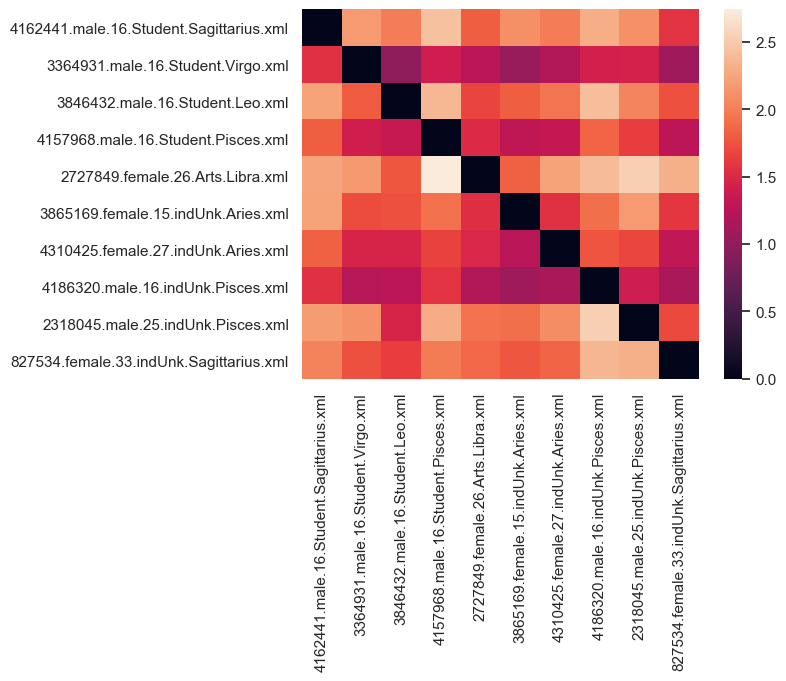

In [423]:
#KL
plot_heatmap('KL', corpora_bl, fileids_bl)

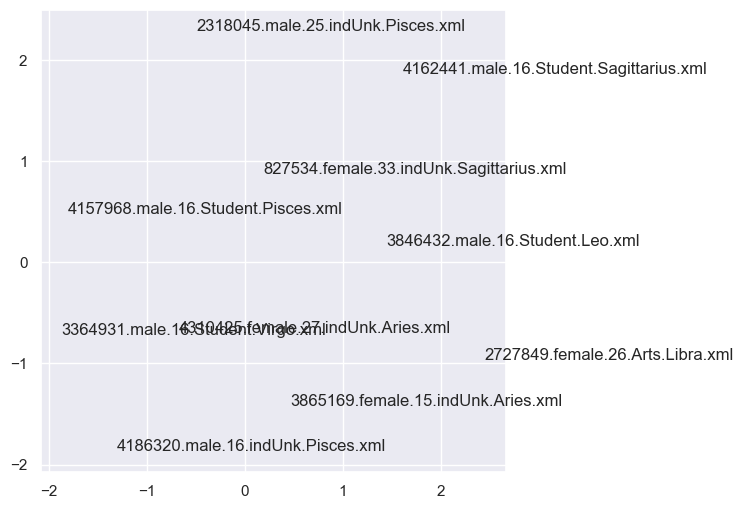

In [428]:
mds('KL', corpora_bl, fileids_bl)

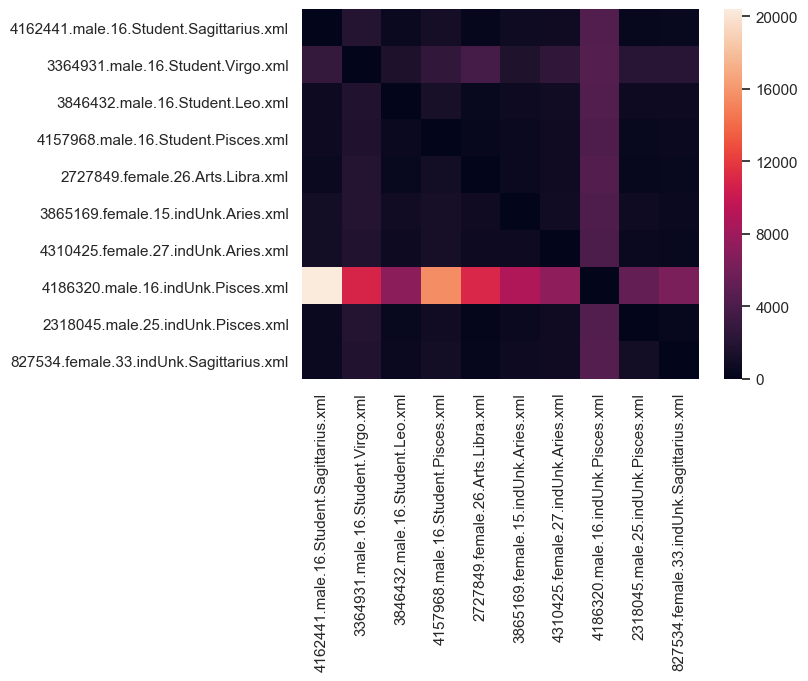

In [429]:
#chi2
plot_heatmap('Chi2', corpora_bl, fileids_bl)

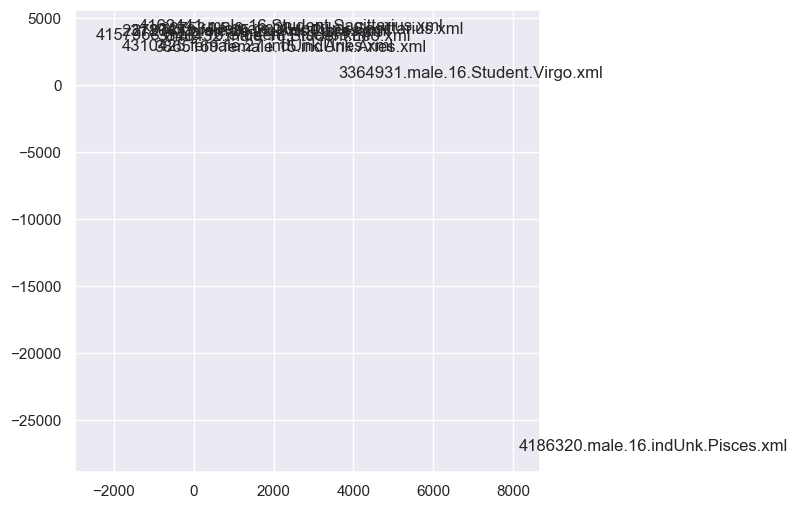

In [431]:
mds('Chi2', corpora_bl, fileids_bl)

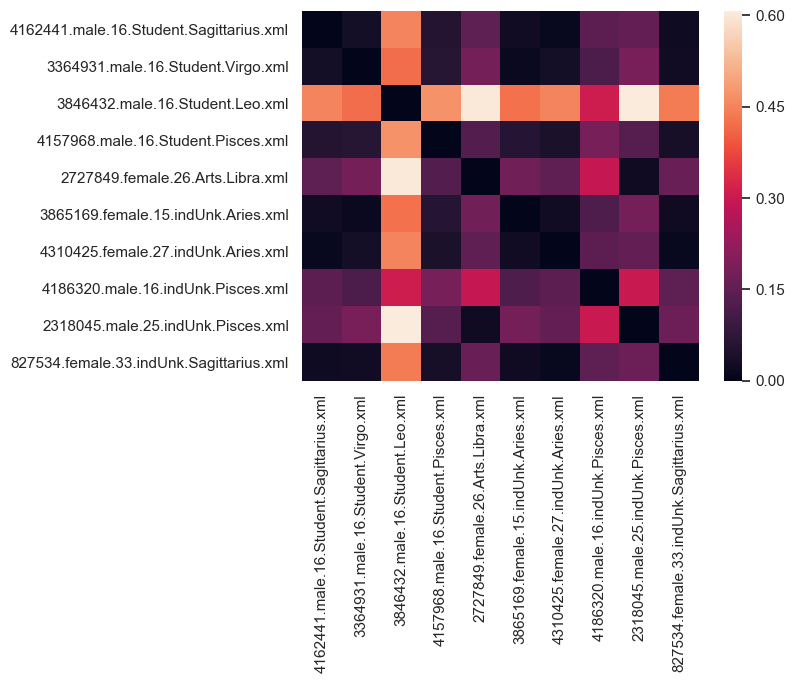

In [432]:
#KS
plot_heatmap('KS', corpora_bl, fileids_bl)

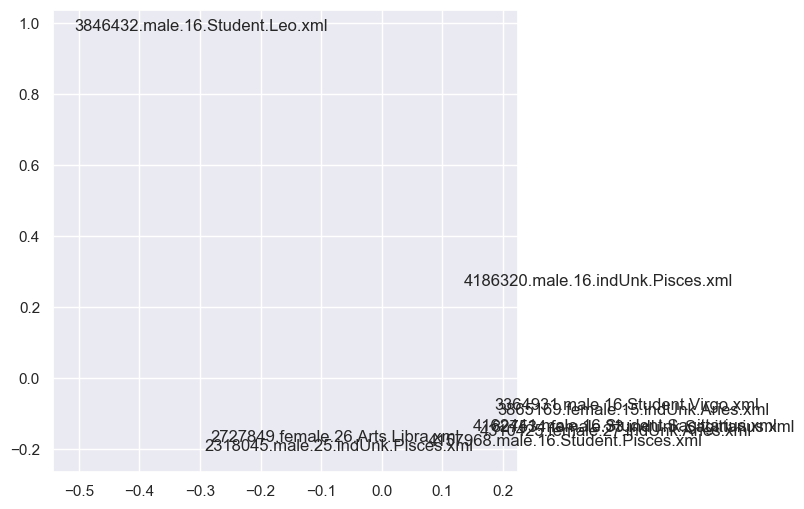

In [433]:
mds('KS', corpora_bl, fileids_bl)

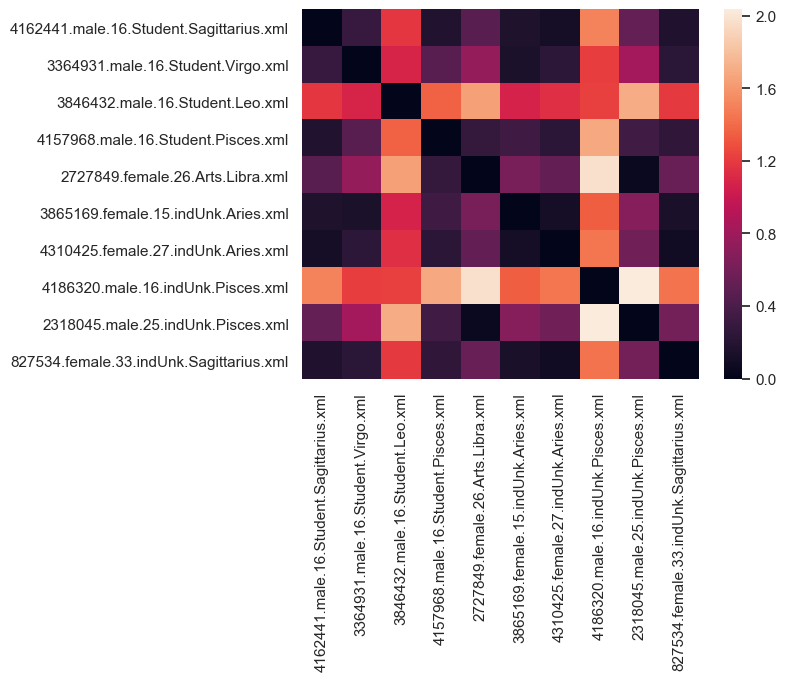

In [434]:
#Wasserstein
plot_heatmap('Wasserstein', corpora_bl, fileids_bl)

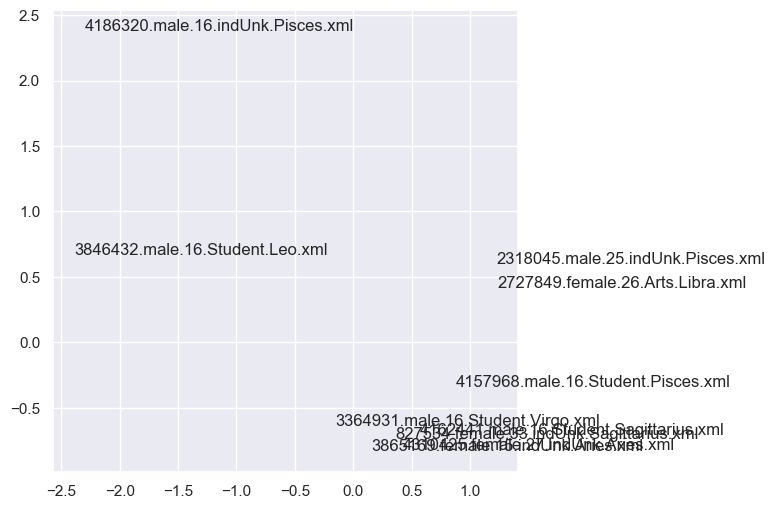

In [435]:
mds('Wasserstein', corpora_bl, fileids_bl)

### Jensen-Shannon Divergence

In [436]:
from scipy.spatial import distance

def js_divergence(X, Y):
    P = X.copy()
    Q = Y.copy()
    P.columns = ['P']
    Q.columns = ['Q']
    df = Q.join(P).fillna(0)
    p = df.iloc[:,1]
    q = df.iloc[:,0]
    D_kl = distance.jensenshannon(p, q)
    return D_kl

def Divergence(corpus1, corpus2, difference="KL"):
    """Difference parameter can equal KL, Chi2, or Wass"""
    freqP = nltk.FreqDist(corpus1)
    P = pandas.DataFrame(list(freqP.values()), columns = ['frequency'], index = list(freqP.keys()))
    freqQ = nltk.FreqDist(corpus2)
    Q = pandas.DataFrame(list(freqQ.values()), columns = ['frequency'], index = list(freqQ.keys()))
    if difference == "KL":
        return kl_divergence(P, Q)
    elif difference == "Chi2":
        return chi2_divergence(P, Q)
    elif difference == "KS":
        try:
            return scipy.stats.ks_2samp(P['frequency'], Q['frequency']).statistic
        except:
            return scipy.stats.ks_2samp(P['frequency'], Q['frequency'])
    elif difference == "Wasserstein":
        try:
            return scipy.stats.wasserstein_distance(P['frequency'], Q['frequency'], u_weights=None, v_weights=None).statistic
        except:
            return scipy.stats.wasserstein_distance(P['frequency'], Q['frequency'], u_weights=None, v_weights=None)
    elif difference == 'JS':
        return js_divergence(P, Q)

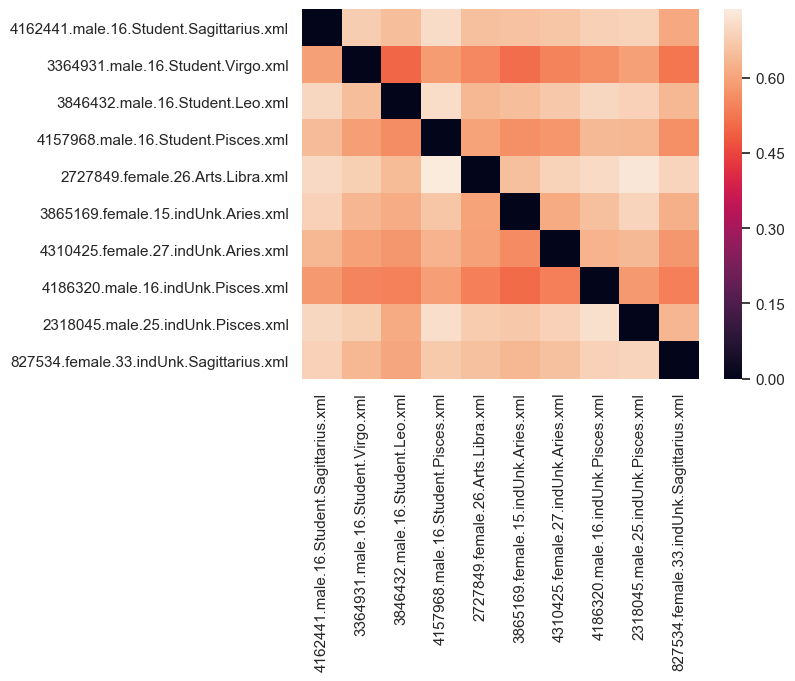

In [437]:
plot_heatmap('JS', corpora_bl, fileids_bl)

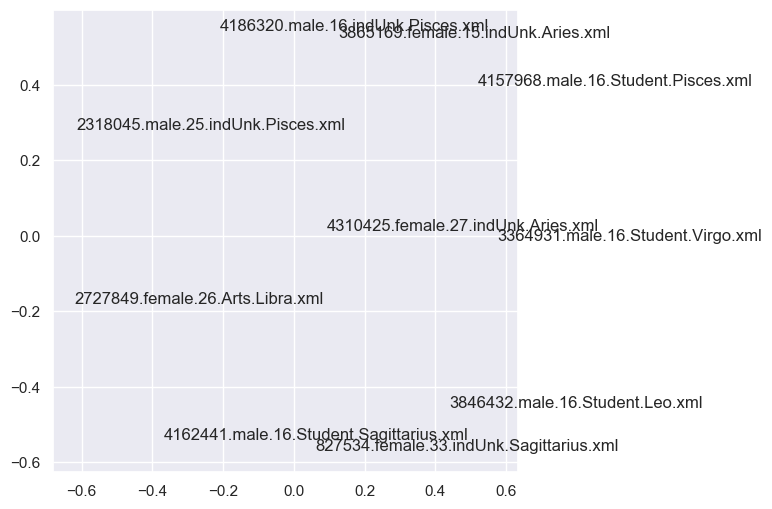

In [438]:
mds('JS', corpora_bl, fileids_bl)

These distance metrics and plots reveal that the blog posts by different authors are distinguishable and are notably different from one another. The Jenson Shannon and the Kullback-Leibler (KL) divergence were metrics that distinguished the different authors the best. In fact, looking at the JS and KL metrics calculated above, it seems that the JS metric is a kind of average over the KL divergence metric such that the comparison two way is symmetrical.